In [2]:
import os
import sys
import time
import traceback
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from scipy import signal
from scipy.stats import zscore

import numpy as np
import pandas as pd

import shutil
import mne
from tensorflow import keras
import tensorflow as tf
# from ecgdetectors import Detectors

DATA_DIR = "/home/siam/MDD_Research/cap-sleep-database-1.0.0/cap-sleep-database-1.0.0"
TARGET_HZ = 64
warnings.filterwarnings('ignore')

2023-09-28 15:29:18.467547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 15:29:18.960672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 15:29:18.965368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 15:29:20.590412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [218]:
#variables
INPUT_DIM=100

In [1]:
pip install py-ecg-detectors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 1.6 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43803 sha256=3f30b432878fd1bb19305d778f922433ced41c80dc9165da2d27082f786d4100
  Stored in directory: /home/siam/.cache/pip/wheels/4c/f6/62/023194c77c6e9a7c3316fd0052706cedacebe136926fb99332
Successfully built gatspy
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_cap_ecg_data_mne(edf_file, fs_target=64, log=print):
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=False)
        ch_idx = -1
        ch_name = None
        for cname in raw.info.get('ch_names'):
            ch_idx += 1
            if cname.find("ECG") > -1:
                ch_name = cname
                break
        hz = mne.pick_info(raw.info, [ch_idx], verbose=False)['sfreq']
        hz = int(hz)
        raw.pick_channels([ch_name])
        recording = raw.get_data().flatten()
        print(f"channel: {cname}")

    except:
        log(f"Error reading {edf_file}, caused by - {traceback.format_exc()}")
        return
    meta = {
        "hz": hz,
        "dt_signal_start": raw.info.get('meas_date')
    }
    # Down sample to 50Hz
    down_factor = meta["hz"] // fs_target
    target_samples = len(recording) // down_factor
    print(f"{edf_file}, @{meta['hz']}, down_factor:{down_factor}, recording:{recording.shape}, target:{target_samples}")
    recording = signal.resample(recording, target_samples)

    # Read annotation
    labels = []
    return (recording, labels, meta)

In [3]:
def generate_rr_signal(ecg_signal):
    rr_signal = np.zeros((ecg_signal.shape[0]))
    r_peaks = ECG_DETECTOR.pan_tompkins_detector(ecg_signal)
    r_peak_diff = np.diff(r_peaks)
    rr_signal[0:len(r_peak_diff)] = r_peak_diff
    return (r_peaks, rr_signal)

In [4]:
def sample_offset_stm(stm_annot, stm_signal, target_hz=64):
    print(f"tm_annot:{stm_annot}, tm_signal:{stm_signal}, target_hz:{target_hz}")
    tm_annot = datetime.strptime(stm_annot, "%H:%M:%S")
    tm_signal = datetime.strptime(stm_signal, "%H:%M:%S")
    delta_sec = int((tm_annot-tm_signal).total_seconds())
    return delta_sec*target_hz

In [5]:
def stm_annot_start(annot_filepath):
    with open(annot_filepath, "r") as f:
        lines = f.readlines()
    reached_sleep_stage_line = False    
    for line in lines:
        # print(line)
        tokens = line.split("\t")
        if not reached_sleep_stage_line and not line.startswith("Sleep Stage"):
            continue
        if line.startswith("Sleep Stage"):
            reached_sleep_stage_line = True
            continue
        # first annotation line
        s_time = tokens[-4]
        if s_time.find(":") < 0:
            print(f"Invalid timestamp | {line}")
            return None
        break
    return s_time

In [2]:
def edf_to_csv(data_directory):
    # Find and read .edf files and corresponding .txt files for annotation.
    #
    count_file = 0
    ignore_file = 0
    bad_files = []
    record_names = []
    target_data_dir = f"{data_directory}/np_data_{TARGET_HZ}"
    if not os.path.exists(target_data_dir):
        os.makedirs(target_data_dir)

    for f in os.listdir(data_directory):
        if not f.endswith(".edf"):
            continue
        rec_name = f[:-4]  # exclude .edf
        try:
            edf_path = f"{data_directory}/{f}"
            recording, _, meta = load_cap_ecg_data_mne(edf_path, fs_target=TARGET_HZ)
            
            # Annotation does not start from the beginning of a singal, 
            # discard un-annotated initial signal samples.
            # 
            stm_annot_begin = stm_annot_start(edf_path.replace('.edf', '.txt'))

            n_samples_skip = sample_offset_stm(stm_annot_begin, meta["dt_signal_start"].time().strftime("%H:%M:%S"))            
            
            print(
                f"{count_file} | {f} | signal:{recording.shape}, "
                f"offset:{n_samples_skip} samples ({stm_annot_begin}-{meta['dt_signal_start'].time().strftime('%H:%M:%S')}), "
                f"signal*:{len(recording)-n_samples_skip}")
            len_before = len(recording)
            recording = recording[n_samples_skip:]
            assert len(recording) == len_before - n_samples_skip

            record_names.append(rec_name)

            np.savetxt(f"{target_data_dir}/{f.replace('.edf', '.csv')}", recording)
            shutil.copy(f"{data_directory}/{f.replace('.edf', '.txt')}", target_data_dir)

            # rr_signal = generate_rr_signal(recording)
            # print(f"rr_signal")
            # break
        except:
            ignore_file += 1
            print(f"error loading {f}")
            traceback.print_exc(file=sys.stdout)
            bad_files.append(f)
            # Ignore corrupted recording.
            continue
        count_file += 1    
        # break
    print(f"{count_file} files created.")

In [7]:
# edf_to_csv(DATA_DIR)

In [240]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
            self, np_data_dir, list_rec_names=None, batch_sz=32, hz=64, n_channels=1, shuffle=True, log=print,
            class_map={
                "S0": 0,
                "S1": 1,
                "S2": 1,
                "S3": 1,
                "S4": 1,
                "REM": 1,
            }
    ):
        self.np_data_dir = np_data_dir
        self.list_rec_names = list_rec_names
        self.batch_sz = batch_sz
        self.hz = hz
        self.class_map = class_map
        self.n_classes = 2
        self.dim = self.hz * 30  # 30 sec @64Hz
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.log = log
        self.samples_meta = []
        self.cached_data={}
        
        self.count_class_0=0
        self.count_class_1=0
        

        self._init_data_dict()
        

    def _init_data_dict(self):
        self.log("Initialise meta data of samples")
        reached_sleep_stage_line = False
        for f in os.listdir(self.np_data_dir):
            reached_sleep_stage_line = False
            seg_count = 0
            if not f.endswith(".csv"):
                continue
            rec_name = f[:-4]
            if not rec_name in self.list_rec_names:
                continue            
            self.log(f"Loading {rec_name}...")
            sig_filepath = f"{self.np_data_dir}/{f}"
            ecg_sig = np.loadtxt(sig_filepath, delimiter=",")
            annot_filepath = sig_filepath.replace('.csv', '.txt')
            with open(annot_filepath, "r") as f:
                lines = f.readlines()
            n_seg_est = ecg_sig.shape[0]//self.dim    
            self.log(f"[{rec_name}] {ecg_sig.shape}, n_seg:{n_seg_est}")
            start = 0
            ignored_annots_bad_len, ignored_annots_bad_label = 0, 0
            self.log(f"recording:{ecg_sig.shape}")
            for line in lines:
                # print(line)
                tokens = line.split("\t")
                if not reached_sleep_stage_line and not line.startswith("Sleep Stage"):
                    continue
                if line.startswith("Sleep Stage"):
                    reached_sleep_stage_line = True
                    continue
                # Annotation starts
                try:
                    tok_is_sleep = tokens[-3]
                    if tok_is_sleep.find("SLEEP-") < 0:
                        current_epoch_len = int(tokens[-2])
                        continue
                    label_str = tok_is_sleep.split("-")[-1]
                    label = self.class_map.get(label_str)
                    current_epoch_len = int(tokens[-2])
                except:
                    self.log(f"--> error parsing epoch-len: {tokens[-2]}")
                    ignored_annots_bad_len += 1
                    continue
                if current_epoch_len != 30:  # not a valid sleep epoch
                    ignored_annots_bad_len += 1
                    self.log(f"--> bad length: {current_epoch_len}")
                    # start += (current_epoch_len*self.hz)
                    continue
                if label is None:
                    self.log(
                        f"Ignored label for label_str:{label_str}->{label} >> {line}")
                    ignored_annots_bad_label += 1
                    start += self.dim
                    continue
                end = start + self.dim
                seg = ecg_sig[start : end]
                remaining = len(ecg_sig) - end

                if len(seg) != self.dim:
                    self.log(f"bad seg_sz:{len(seg)} >> {line}")
                    start += self.dim
                    continue

                self.samples_meta.append((rec_name, start, label,label_str))
                
                #update the label
                if label==0:
                    self.count_class_0 +=1
                elif label==1:
                    self.count_class_1 +=1

                # update start
                start += self.dim
                seg_count += 1    

            self.log(
                f"...[{rec_name}], n_seg:{seg_count} out of {n_seg_est} (lags seg:{n_seg_est-seg_count}, "
                f"samples:{(n_seg_est-seg_count)*self.dim}), bad_label: {ignored_annots_bad_label}, bad_len/ignored: {ignored_annots_bad_len}, "
                f"remaining:{remaining}")
        self.log(f"Total sample-meta loaded: {len(self.samples_meta)}")
        self.indexes = list(range(len(self.samples_meta)))
        self.get_label()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_sz))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_sz:(index+1)*self.batch_sz]
        X, y= self.__data_generation(batch_indexes)
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_sz, INPUT_DIM, self.n_channels))
        y = np.zeros((self.batch_sz), dtype=int)

        # Generate data, retrieve from files
        for i, ID in enumerate(list_IDs_temp):
            self.log(f"i:{i} => {self.samples_meta[self.indexes[i]]} | ID:{ID} => {self.samples_meta[self.indexes[ID]]}")
            rec_name, seg_start, label,label_str = self.samples_meta[self.indexes[ID]]
            cached_key=rec_name+str(seg_start)
            if(self.cached_data.get(cached_key) is not None):
                segment=self.cached_data.get(cached_key)
            else:                
                # sig_filepath = os.path.join(self.data_dir, "np_data_64", f"{rec_name}.csv")
                sig_filepath = os.path.join(self.np_data_dir, f"{rec_name}.csv")
                ecg_sig = np.loadtxt(sig_filepath, delimiter=",")
                segment = ecg_sig[seg_start:seg_start+self.dim]
                
                r_peaks_pan = detectors.pan_tompkins_detector(segment)
                r_peaks_pan= np.asarray(r_peaks_pan)
                rr_intervals = np.diff(r_peaks_pan)
                rr_intervals=resample(rr_intervals,INPUT_DIM)
                
                segment = zscore(rr_intervals)  # normalise segment
                self.cached_data[cached_key]=segment
                
            
            X[i,] = segment.reshape((INPUT_DIM, 1))
            y[i] = label
            
            
            #update the label
#             if label==0:
#                 self.count_class_0 +=1
#             elif label==1:
#                 self.count_class_1 +=1
            

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def get_labels(self):
        labels = []
        for i in self.indexes:
            _, _, label = self.samples_meta[self.indexes[i]]
            labels.append(label)
        return np.array(labels)
    
    def get_label(self):
        total=self.count_class_0+self.count_class_1
        if total ==0:
            return {0:0.0,1:0.0}
        weight_0=self.count_class_1/total
        weight_1=self.count_class_0/total
        return {0:weight_0,1:weight_1}

In [131]:
y=keras.utils.to_categorical([0,1],num_classes=2)
print(y,y.shape)
yy=np.argmax(y,axis=1)
print(yy)

[[1. 0.]
 [0. 1.]] (2, 2)
[0 1]


In [238]:
training_generator = DataGenerator(np_data_dir="/home/siam/MDD_Research/cap-sleep-database-1.0.0/cap-sleep-database-1.0.0/np_data_64", list_rec_names=["n2", "n3"])

Initialise meta data of samples
Loading n2...
[n2] (2104320,), n_seg:1096
recording:(2104320,)
...[n2], n_seg:999 out of 1096 (lags seg:97, samples:186240), bad_label: 0, bad_len/ignored: 0, remaining:186240
Loading n3...
[n3] (1921984,), n_seg:1001
recording:(1921984,)
...[n3], n_seg:999 out of 1001 (lags seg:2, samples:3840), bad_label: 0, bad_len/ignored: 0, remaining:3904
Total sample-meta loaded: 1998


In [5]:
validation_generator = DataGenerator(np_data_dir="/home/siam/MDD_Research/cap-sleep-database-1.0.0/cap-sleep-database-1.0.0/np_data_64", list_rec_names=["n1"])

Initialise meta data of samples
Loading n1...
[n1] (2202240,), n_seg:1147
recording:(2202240,)
...[n1], n_seg:1140 out of 1147 (lags seg:7, samples:13440), bad_label: 0, bad_len/ignored: 0, remaining:13440
Total sample-meta loaded: 1140


In [6]:
print("number of batches:", len(validation_generator))


number of batches: 35


In [7]:
weight_0,weight_1=training_generator.get_label()
print(weight_0,weight_1)

0 1


In [8]:
total=weight_0+weight_1
print(weight_0/total,weight_1/total)

0.0 1.0


In [239]:
batch_x, batch_y=training_generator

i:0 => ('n2', 476160, 1, 'REM') | ID:248 => ('n3', 1814400, 1, 'S3')
(100,)
i:1 => ('n2', 1393920, 1, 'S2') | ID:726 => ('n2', 1088640, 1, 'S4')
(100,)
i:2 => ('n2', 1272960, 0, 'S0') | ID:663 => ('n3', 1555200, 1, 'S2')
(100,)
i:3 => ('n3', 51840, 1, 'S2') | ID:1026 => ('n2', 1595520, 1, 'REM')
(100,)
i:4 => ('n2', 1418880, 1, 'S2') | ID:739 => ('n2', 547200, 1, 'REM')
(100,)
i:5 => ('n2', 1079040, 1, 'S4') | ID:562 => ('n2', 1224960, 1, 'REM')
(100,)
i:6 => ('n2', 456960, 1, 'S2') | ID:238 => ('n2', 856320, 0, 'S0')
(100,)
i:7 => ('n3', 516480, 1, 'REM') | ID:1268 => ('n3', 324480, 1, 'S3')
(100,)
i:8 => ('n2', 109440, 1, 'S3') | ID:57 => ('n3', 405120, 1, 'S3')
(100,)
i:9 => ('n2', 1349760, 1, 'S2') | ID:703 => ('n3', 1893120, 1, 'S2')
(100,)
i:10 => ('n2', 293760, 1, 'S2') | ID:153 => ('n3', 1309440, 0, 'S0')
(100,)
i:11 => ('n3', 1050240, 1, 'REM') | ID:1546 => ('n3', 309120, 1, 'S3')
(100,)
i:12 => ('n3', 591360, 1, 'S2') | ID:1307 => ('n3', 149760, 0, 'S0')
(100,)
i:13 => ('n3',

KeyboardInterrupt: 

In [9]:
print("number of batches:", len(training_generator))
batch_x, batch_y = training_generator[0]
# print("batch-data-shape:", batch_x.shape, ", batch_size:", batch_x.shape[0], ", single-item-in-batch:", batch_x[0].shape)

number of batches: 62
i:0 => ('n2', 1370880, 1, 'S1') | ID:714 => ('n3', 326400, 1, 'S3')
i:1 => ('n3', 504960, 1, 'REM') | ID:1262 => ('n3', 433920, 1, 'S3')
i:2 => ('n3', 34560, 1, 'S1') | ID:1017 => ('n2', 1359360, 1, 'S2')
i:3 => ('n3', 1236480, 1, 'S3') | ID:1643 => ('n2', 1804800, 0, 'S0')
i:4 => ('n3', 689280, 1, 'S4') | ID:1358 => ('n3', 956160, 1, 'REM')
i:5 => ('n2', 1662720, 1, 'S2') | ID:866 => ('n3', 1585920, 1, 'S2')
i:6 => ('n3', 1762560, 1, 'S2') | ID:1917 => ('n3', 209280, 1, 'S2')
i:7 => ('n2', 184320, 1, 'S4') | ID:96 => ('n3', 1549440, 1, 'S2')
i:8 => ('n3', 545280, 1, 'S2') | ID:1283 => ('n2', 789120, 1, 'S2')
i:9 => ('n3', 1372800, 1, 'S1') | ID:1714 => ('n3', 975360, 1, 'REM')
i:10 => ('n2', 842880, 0, 'S0') | ID:439 => ('n2', 1313280, 1, 'S1')
i:11 => ('n2', 372480, 1, 'S3') | ID:194 => ('n3', 1011840, 1, 'REM')
i:12 => ('n3', 587520, 1, 'S2') | ID:1305 => ('n2', 643200, 0, 'S0')
i:13 => ('n3', 395520, 1, 'S4') | ID:1205 => ('n2', 220800, 1, 'S2')
i:14 => ('n2',

In [53]:
from ecgdetectors import Detectors

fs=64

heartbeat = pd.read_csv("/home/siam/MDD_Research/cap-sleep-database-1.0.0/cap-sleep-database-1.0.0/np_data_64/n1.csv")
detectors = Detectors(fs)

In [54]:
num_rows = len(heartbeat)
print(num_rows)

2202239


20
R-R Intervals (in milliseconds): [63 50 51 52 51 50 49 48 50 50 51 51 48 49 49 51 53 54 51]


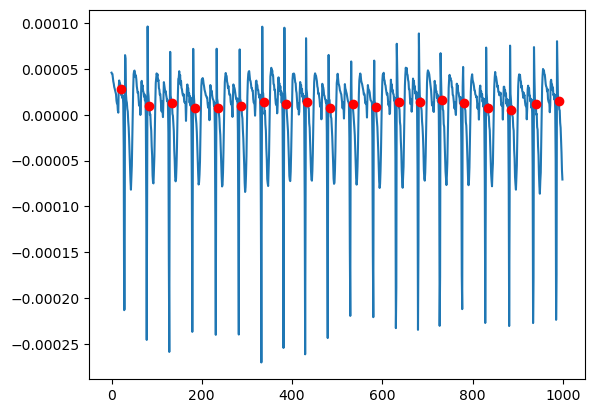

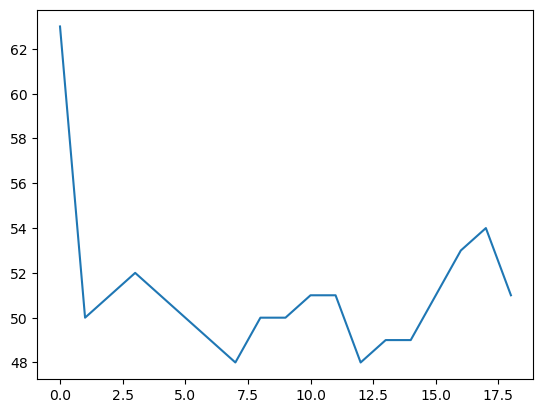

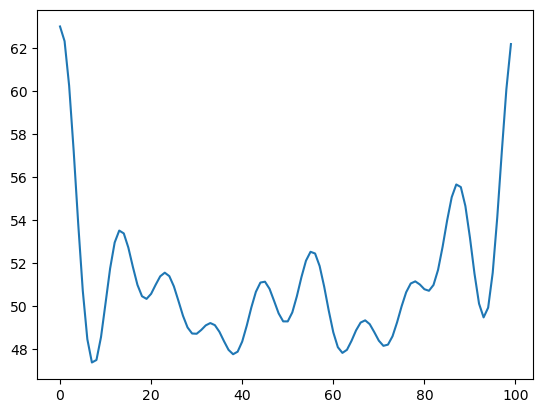

In [217]:

try:
    r_peaks_pan = detectors.pan_tompkins_detector(heartbeat.iloc[:,0][0:1000])
    r_peaks_pan= np.asarray(r_peaks_pan)
    print(len(r_peaks_pan))
    
    
    rr_intervals = np.diff(r_peaks_pan)
    
    sampling_rate = 64  
    rr_intervals_time = rr_intervals / sampling_rate
    
    # Print the R-R intervals
    print("R-R Intervals (in milliseconds):", rr_intervals)
#     print("R-R Intervals (in seconds):", rr_intervals_time)


    plt.plot(heartbeat.iloc[:,0][0:1000])
    plt.plot(r_peaks_pan,heartbeat.iloc[:,0][0:1000][r_peaks_pan], 'ro')
    plt.show()
    
    plt.plot(range(len(rr_intervals)),rr_intervals)
    plt.show()
    
    plt.plot(range(100),resample(rr_intervals,100))
    plt.show()
except Exception as e:
    print("An error occurred:", e)

Total number of R peaks 20
R-R Intervals (in milliseconds): 
 [63 50 51 52 51 50 49 48 50 50 51 51 48 49 49 51 53 54 51]
RR intervals scaled : 
 [[1.        ]
 [0.13333333]
 [0.2       ]
 [0.26666667]
 [0.2       ]
 [0.13333333]
 [0.06666667]
 [0.        ]
 [0.13333333]
 [0.13333333]
 [0.2       ]
 [0.2       ]
 [0.        ]
 [0.06666667]
 [0.06666667]
 [0.2       ]
 [0.33333333]
 [0.4       ]
 [0.2       ]]
rr_intervals_time = 19
resample signal 
 [ 4.58892815e-05  5.65263896e-05  3.84285396e-05 ... -6.56418963e-05
 -8.58582204e-05 -2.97096716e-05]
original signal 
 0      0.000046
1      0.000045
2      0.000044
3      0.000040
4      0.000036
         ...   
995   -0.000014
996   -0.000027
997   -0.000042
998   -0.000061
999   -0.000071
Name: 4.681101559563408072e-05, Length: 1000, dtype: float64
Resmple r peaks pan 
 [  28   50  127  205  285  366  445  524  600  675  753  831  911  990
 1066 1141 1218 1299 1382 1465 1544]
r peaks pan
 [ 20  83 133 184 236 287 337 386 434 484 534 5

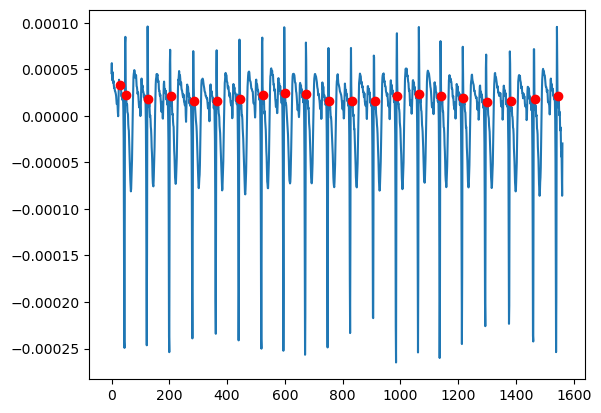

In [214]:
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler

# instance for minmax scaler
scaler = MinMaxScaler()


# using pan tomkins detector 
r_peaks_pan = detectors.pan_tompkins_detector(heartbeat.iloc[:,0][0:1000])
r_peaks_pan = np.asarray(r_peaks_pan)
print("Total number of R peaks",len(r_peaks_pan))

# rr intervals 
rr_intervals = np.diff(r_peaks_pan)
# Print the R-R intervals
print("R-R Intervals (in milliseconds): \n", rr_intervals)

# scalling with minmax scaler
rr_intervals = rr_intervals.reshape(-1, 1) #reshape it bcz minmax scaler expect a 2D array
rr_intervals_scaled = scaler.fit_transform(rr_intervals)
print("RR intervals scaled : \n",rr_intervals_scaled)


sampling_rate = 64  
rr_intervals_time = rr_intervals / sampling_rate
print("rr_intervals_time =",len(rr_interval_time))

# Resample the signal to 100 Hz
target_sampling_rate = 100

resampled_signal = resample(heartbeat.iloc[:,0][0:1000], int(len(heartbeat.iloc[:,0][0:1000]) * (target_sampling_rate / sampling_rate)))
#     resampled_signal = resample(heartbeat.iloc[:,0][0:1000], target_sampling_rate)

resample_rr_intervals=np.diff(resampled_signal)
print("resample signal \n",resampled_signal)
print("original signal \n",heartbeat.iloc[:,0][0:1000])
# Generate a new time array for the resampled signal
#     new_time = np.linspace(0, len(heartbeat.iloc[:,0][0:1000]) / target_sampling_rate, len(resampled_signal), endpoint=False)

#     print(len(new_time))



resm_r_peaks_pan = detectors.pan_tompkins_detector(resampled_signal)
resm_r_peaks_pan = np.asarray(resm_r_peaks_pan)
print("Resmple r peaks pan \n",resm_r_peaks_pan)
print("r peaks pan\n",r_peaks_pan)
# Plot the resampled signal with detected R-peaks
plt.plot(resampled_signal)
plt.plot(resm_r_peaks_pan, resampled_signal[resm_r_peaks_pan], 'ro')


Original Signal: [1, 2, 3, 4, 5]
Resampled Signal: [1.         1.20615913 2.92259402 2.93432178 3.62063635 5.32438558
 3.99190313]


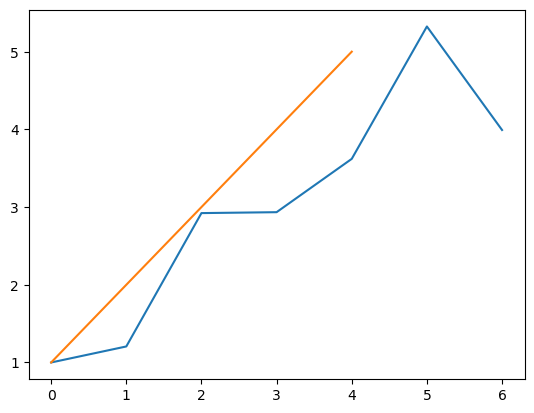

In [207]:
from scipy.signal import resample

# Original signal with a sampling rate of 64 Hz
original_signal = [1, 2, 3, 4, 5]

# Define the original and target sampling rates
original_sampling_rate = 64
target_sampling_rate = 100

# Upsample the signal
resampled_signal = resample(original_signal, int(len(original_signal) * (target_sampling_rate / sampling_rate)))

print("Original Signal:", original_signal)
print("Resampled Signal:", resampled_signal)

plt.plot(resampled_signal)
plt.plot(original_signal)

In [199]:
def R_correction(signal, peaks):
    num_peak=peaks.shape[0]
    peaks_corrected_list=list()
    for index in range(num_peak):
        i=peaks[index]
        cnt=i
        if cnt-1<0:
            break
        if signal[cnt]<signal[cnt-1]:
            while signal[cnt]<signal[cnt-1]:
                cnt-=1
                if cnt<0:
                    break
        elif signal[cnt]<signal[cnt+1]:
            while signal[cnt]<signal[cnt+1]:
                cnt+=1
                if cnt<0:
                    break
        peaks_corrected_list.append(cnt)
    peaks_corrected=np.asarray(peaks_corrected_list)            
    return peaks_corrected

21
Peaks Corrected list [  26   48  125  203  283  364  443  522  598  673  751  829  908  988
 1064 1139 1216 1297 1379 1462 1542]
Resm r peaks pan [  28   50  127  205  285  366  445  524  600  675  753  831  911  990
 1066 1141 1218 1299 1382 1465 1544]


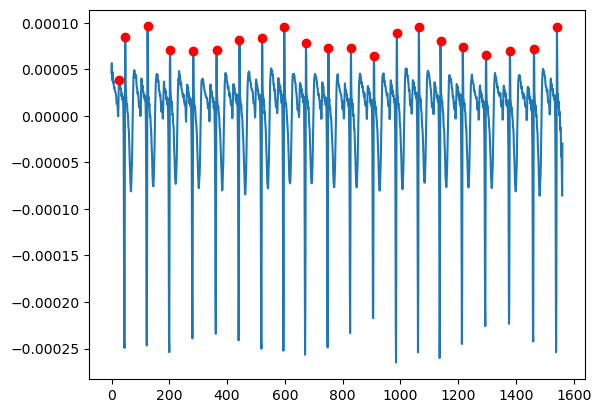

In [200]:
corrected_R_peak=R_correction(resampled_signal,resm_r_peaks_pan)
print(len(corrected_R_peak))
print("Peaks Corrected list",corrected_R_peak)
print("Resm r peaks pan",resm_r_peaks_pan)
plt.plot(resampled_signal)
plt.plot(corrected_R_peak,resampled_signal[corrected_R_peak], 'ro')

(1920,)


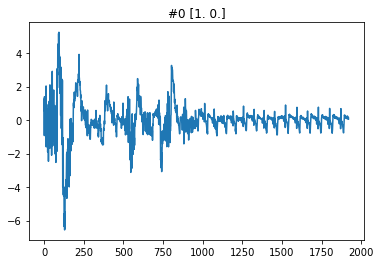

(1920,)


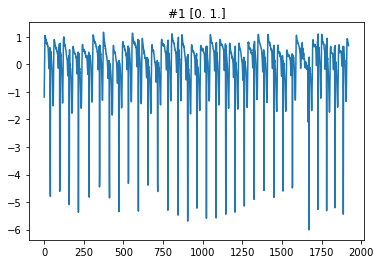

(1920,)


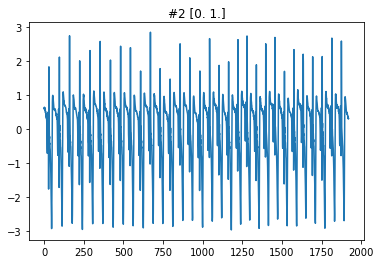

(1920,)


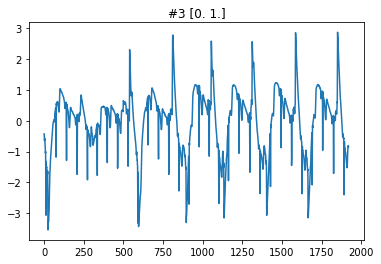

(1920,)


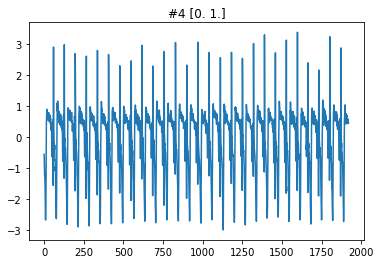

(1920,)


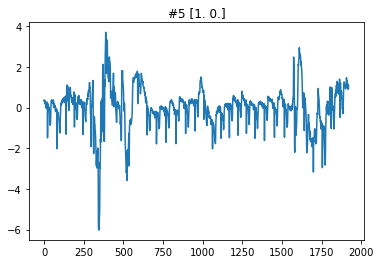

(1920,)


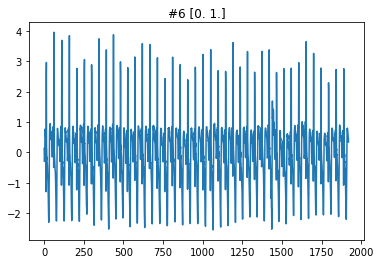

(1920,)


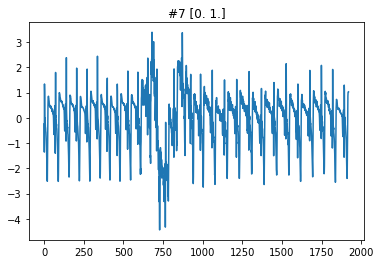

(1920,)


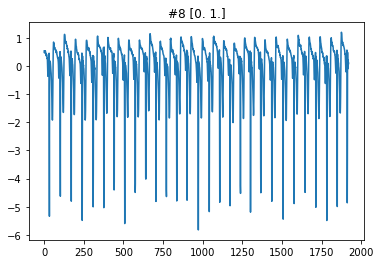

(1920,)


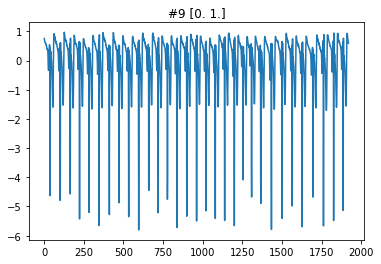

(1920,)


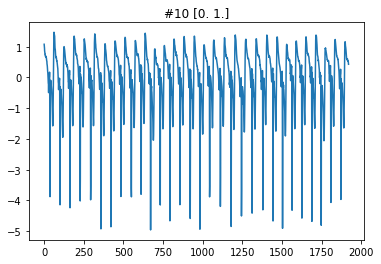

(1920,)


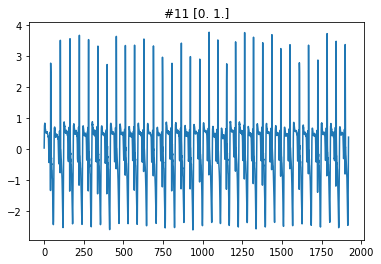

(1920,)


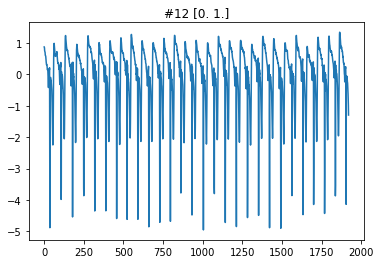

(1920,)


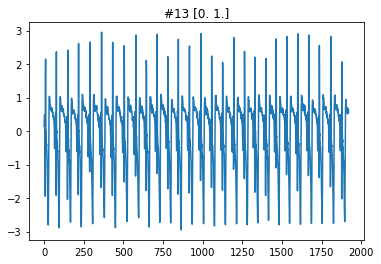

(1920,)


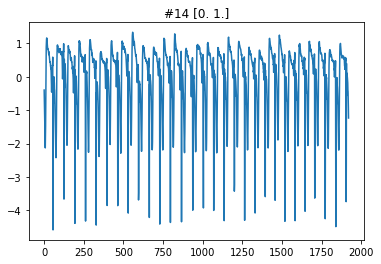

(1920,)


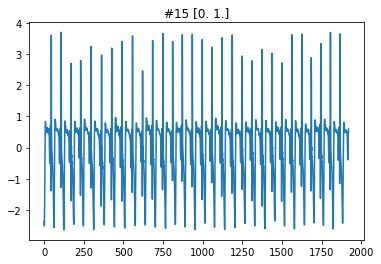

(1920,)


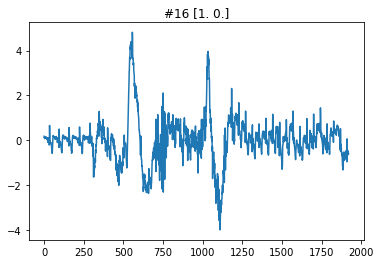

(1920,)


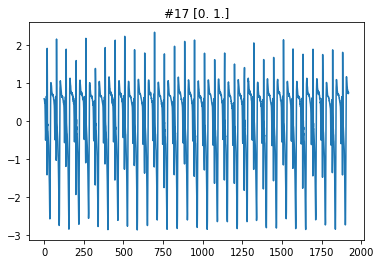

(1920,)


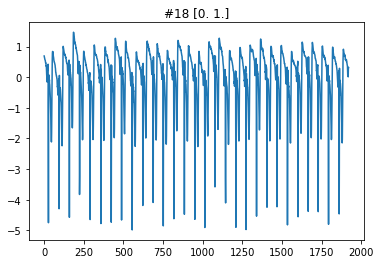

(1920,)


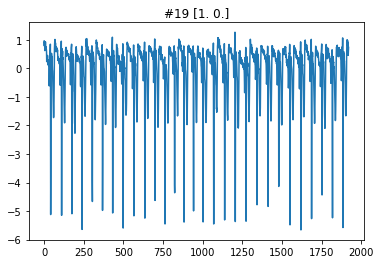

(1920,)


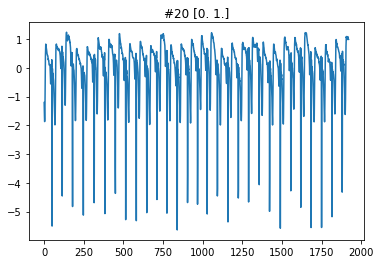

(1920,)


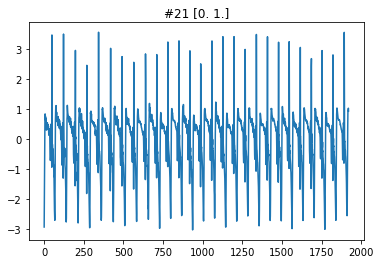

(1920,)


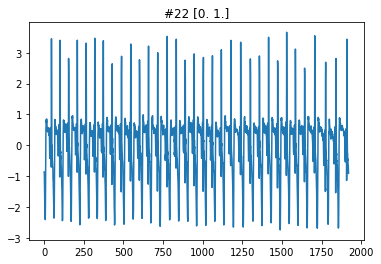

(1920,)


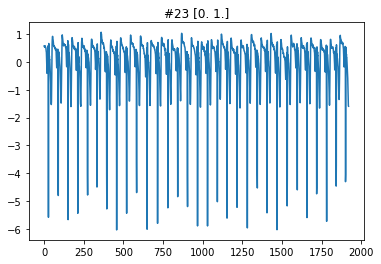

(1920,)


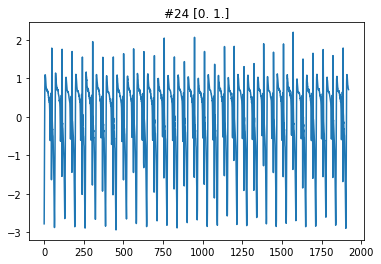

(1920,)


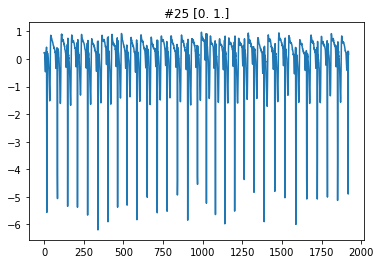

(1920,)


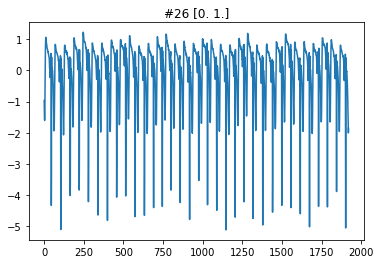

(1920,)


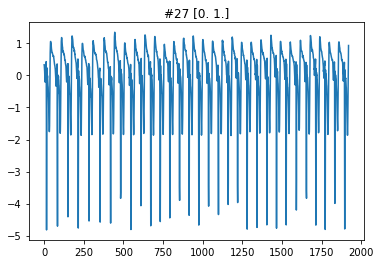

(1920,)


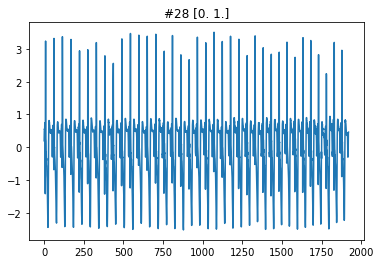

(1920,)


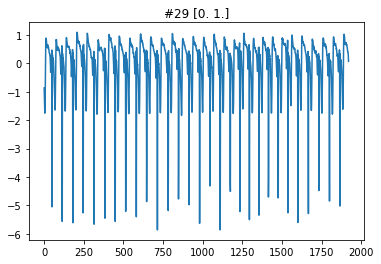

(1920,)


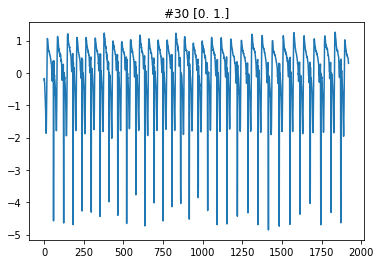

(1920,)


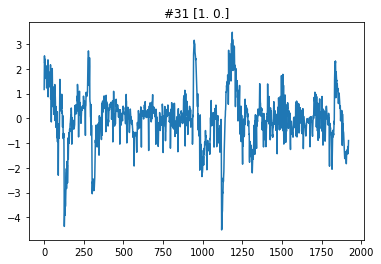

In [56]:
for i in range(batch_x.shape[0]):
    signal = batch_x[i].T[0]
    label = batch_y[i]
    print(signal.shape)
    plt.plot(range(len(signal)), signal)
    plt.title(f"#{i} {label}")
    plt.show()

**Spliting**

**Model**

In [220]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D , Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import max_norm
from keras import backend as K


In [87]:
# def weighted_binary_crossentropy(y_true, y_pred): 
#     weight = K.variable([weight_1, weight_0])
#     y_true = K.cast(y_true, y_pred.dtype)
#     return K.mean(K.binary_crossentropy(y_true, y_pred) * K.sum(weight * y_true, axis=-1), axis=-1)

In [223]:
def get_model():
    model=Sequential()
    model.add(Conv1D(input_shape=(INPUT_DIM,1),filters=64,kernel_size=(5),strides=(1),activation="relu"))
    model.add(Conv1D(filters=64,kernel_size=(5), activation="relu"))    
    model.add(MaxPool1D(pool_size=(2),strides=(2)))
    
    model.add(Conv1D(filters=128,kernel_size=(3),activation="relu"))
    model.add(Conv1D(filters=128,kernel_size=(3), activation="relu"))
    model.add(MaxPool1D(pool_size=(2),strides=(2)))

    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    
    return model

In [224]:
model=get_model()
model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])   

In [225]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 96, 64)            384       
                                                                 
 conv1d_5 (Conv1D)           (None, 92, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 46, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 44, 128)           24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 42, 128)           49280     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0         
 g1D)                                                 

In [31]:
model.layers

In [67]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit(x=training_generator[0], y=training_generator[0].get_labels(), validation_steps=2,epochs=2,steps_per_epoch=5,callbacks=[checkpoint,early])



i:0 => ('n2', 90240, 1, 'S3') | ID:47 => ('n2', 1639680, 1, 'S1')
i:1 => ('n3', 1766400, 1, 'S2') | ID:1919 => ('n2', 360960, 1, 'S3')
i:2 => ('n3', 1655040, 1, 'REM') | ID:1861 => ('n2', 416640, 1, 'S2')
i:3 => ('n3', 631680, 1, 'S3') | ID:1328 => ('n3', 1712640, 1, 'S2')
i:4 => ('n3', 1284480, 0, 'S0') | ID:1668 => ('n2', 1463040, 1, 'S1')
i:5 => ('n3', 487680, 1, 'REM') | ID:1253 => ('n3', 712320, 1, 'S4')
i:6 => ('n2', 1493760, 1, 'S1') | ID:778 => ('n3', 453120, 1, 'REM')
i:7 => ('n3', 1714560, 1, 'S2') | ID:1892 => ('n2', 1363200, 0, 'S0')
i:8 => ('n3', 658560, 1, 'S4') | ID:1342 => ('n3', 1489920, 1, 'S1')
i:9 => ('n2', 220800, 1, 'S2') | ID:115 => ('n3', 1272960, 0, 'S0')
i:10 => ('n2', 668160, 1, 'S2') | ID:348 => ('n3', 1825920, 1, 'S3')
i:11 => ('n3', 1140480, 1, 'S2') | ID:1593 => ('n2', 130560, 1, 'S4')
i:12 => ('n2', 1186560, 1, 'REM') | ID:618 => ('n2', 67200, 1, 'S1')
i:13 => ('n3', 301440, 1, 'S3') | ID:1156 => ('n2', 967680, 1, 'S2')
i:14 => ('n2', 806400, 1, 'REM') |

AttributeError: 'tuple' object has no attribute 'get_labels'

In [12]:
for val in names:
    train = [i for i in names if i != val ]
    print(val,train)
    

n1 ['n2', 'n3']
n2 ['n1', 'n3']
n3 ['n1', 'n2']


In [ ]:
print("Evaluate model on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

In [52]:
# , "n5", "n6", "n7", "n9", "n10", "n11", "n13","n14"
# ,class_weight=training_generator.get_label()

In [241]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

names = ["n1", "n2", "n3"]
np_data_dir = "/home/siam/MDD_Research/cap-sleep-database-1.0.0/cap-sleep-database-1.0.0/np_data_64"

def leave_ones():
    metrics_df = pd.DataFrame(columns=['validation_sub', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'time_per_epoch'])
    
    for i in range(len(names)):
        val = names[i]
        train = names[i+1:] + names[:i]  
        model=get_model()
        
        
#         training and validation generator
        training_generator = DataGenerator(np_data_dir, list_rec_names=train)        
        
        validation_generator = DataGenerator(np_data_dir, list_rec_names=[val])
        
        total=training_generator.count_class_0 + training_generator.count_class_1
        weight_0,weight_1=training_generator.count_class_0/total,training_generator.count_class_1/total
        print(weight_0,weight_1)
        
#         weight = K.variable([weight_0, weight_1])
#         # Define the weighted binary cross-entropy loss function
#         def weighted_binary_crossentropy(y_true, y_pred): 
#             print(y_true.shape,y_pred.shape)
# #             weight = K.variable([0.5, 0.5])
#             weight=tf.constant([0.5, 0.5])
    
#             cross_entropy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)
#             weighted_cross_entropy_loss = tf.reduce_mean(tf.multiply(cross_entropy_loss, weight))
            
# #             y_true = K.cast(y_true, y_pred.dtype)
# #             return K.mean(K.binary_crossentropy(y_true, y_pred) * K.sum(weight * y_true, axis=-1), axis=-1)
#             return weighted_cross_entropy_loss
        


        # Compile the model with the computed class weights
        model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  
        
#         fit the model
        start_time = time.time()
        checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        early = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
        
        
#         model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
#         initial_weights = model.get_weights()
#         print("Initial Weights:",initial_weights)
        hist = model.fit(steps_per_epoch=7, 
                                   x=training_generator,
                                 y=None,
                                   validation_data=validation_generator,
                                class_weight={0:weight_0,1:weight_1},
                                   validation_steps=5, 
                                   epochs=20,
                                   callbacks=[checkpoint, early]
                                  )
#         final_weights = model.get_weights()
#         print("Final Weights:",final_weights)
        end_time = time.time()
        
#         iteration_name = f"Subject-{val}"
#         hist_df = pd.DataFrame(hist.history)
#         hist_df['validation_sub'] = iteration_name
        
#         time_per_epoch = (end_time - start_time) / len(hist.history['loss'])
#         hist_df['time_per_epoch'] = time_per_epoch
        
#         metrics_df = metrics_df.append(hist_df, ignore_index=True)        
        
#         metrics_df.to_excel('metrics.xlsx', index=False)        
        
#         model_val = load_model("vgg16_1.h5")        
        
#         val_generator = DataGenerator(np_data_dir, list_rec_names=[val])        
        
#         predictions = model_val.predict_generator(val_generator)
        
#         # Get the actual labels from the generator
#         actual_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])
        
#         # Create a DataFrame to store the actual and predicted values
#         prediction_df = pd.DataFrame({'Actual': np.argmax(actual_labels,axis=1) , 'Class_0': predictions[:, 0],'Class_1': predictions[:, 1] })        
        
#         prediction_df.to_csv(f'{val}_predictions.csv', index=False)


In [242]:
leave_ones()

Initialise meta data of samples
Loading n2...
[n2] (2104320,), n_seg:1096
recording:(2104320,)
...[n2], n_seg:999 out of 1096 (lags seg:97, samples:186240), bad_label: 0, bad_len/ignored: 0, remaining:186240
Loading n3...
[n3] (1921984,), n_seg:1001
recording:(1921984,)
...[n3], n_seg:999 out of 1001 (lags seg:2, samples:3840), bad_label: 0, bad_len/ignored: 0, remaining:3904
Total sample-meta loaded: 1998
Initialise meta data of samples
Loading n1...
[n1] (2202240,), n_seg:1147
recording:(2202240,)
...[n1], n_seg:1140 out of 1147 (lags seg:7, samples:13440), bad_label: 0, bad_len/ignored: 0, remaining:13440
Total sample-meta loaded: 1140
0.13963963963963963 0.8603603603603603
i:0 => ('n3', 1825920, 1, 'S3') | ID:1950 => ('n3', 1522560, 1, 'S2')
i:1 => ('n3', 23040, 0, 'S0') | ID:1011 => ('n2', 401280, 1, 'S2')
i:2 => ('n2', 1294080, 0, 'S0') | ID:674 => ('n3', 34560, 1, 'S1')
i:3 => ('n2', 720000, 1, 'S2') | ID:375 => ('n3', 1017600, 1, 'REM')
i:4 => ('n2', 0, 0, 'S0') | ID:0 => ('n3'

i:9 => ('n2', 322560, 1, 'S2') | ID:909 => ('n2', 896640, 1, 'S1')
i:10 => ('n3', 514560, 1, 'REM') | ID:810 => ('n2', 1100160, 1, 'S4')
i:11 => ('n2', 190080, 1, 'S4') | ID:746 => ('n2', 32640, 1, 'S1')
i:12 => ('n3', 867840, 1, 'S2') | ID:1503 => ('n3', 1770240, 1, 'S2')
i:13 => ('n3', 518400, 1, 'REM') | ID:713 => ('n2', 155520, 1, 'S4')
i:14 => ('n3', 533760, 1, 'S1') | ID:1647 => ('n2', 869760, 1, 'S2')
i:15 => ('n2', 120960, 1, 'S4') | ID:1041 => ('n3', 1895040, 1, 'S2')
i:16 => ('n3', 1420800, 1, 'S2') | ID:953 => ('n2', 1426560, 1, 'S2')
i:17 => ('n2', 595200, 1, 'S2') | ID:930 => ('n3', 1791360, 1, 'S3')
i:18 => ('n2', 1904640, 0, 'S0') | ID:465 => ('n3', 382080, 1, 'S4')
i:19 => ('n2', 1034880, 1, 'S4') | ID:1910 => ('n2', 1585920, 1, 'S1')
i:20 => ('n3', 560640, 1, 'S2') | ID:1331 => ('n3', 900480, 0, 'S0')
i:21 => ('n3', 28800, 0, 'S0') | ID:1370 => ('n2', 134400, 1, 'S4')
i:22 => ('n2', 1488000, 1, 'S2') | ID:511 => ('n3', 261120, 1, 'S4')
i:23 => ('n2', 816000, 1, 'REM') 

i:29 => ('n2', 1468800, 1, 'S2') | ID:1937 => ('n3', 675840, 1, 'S4')
i:30 => ('n2', 71040, 1, 'S1') | ID:1655 => ('n3', 1453440, 1, 'S2')
i:31 => ('n3', 424320, 1, 'S3') | ID:554 => ('n2', 203520, 1, 'S4')
i:0 => ('n3', 1825920, 1, 'S3') | ID:458 => ('n3', 666240, 1, 'S4')
6/7 [========================>.....] - ETA: 31s - loss: 0.2672 - accuracy: 0.8229 i:1 => ('n3', 23040, 0, 'S0') | ID:516 => ('n2', 835200, 1, 'REM')
i:2 => ('n2', 1294080, 0, 'S0') | ID:1012 => ('n3', 735360, 1, 'S4')
i:3 => ('n2', 720000, 1, 'S2') | ID:1552 => ('n2', 387840, 1, 'S3')
i:4 => ('n2', 0, 0, 'S0') | ID:942 => ('n2', 1190400, 1, 'REM')
i:5 => ('n3', 1630080, 1, 'REM') | ID:145 => ('n2', 1401600, 1, 'S1')
i:6 => ('n3', 1322880, 0, 'S0') | ID:1983 => ('n3', 1841280, 1, 'S4')
i:7 => ('n2', 1067520, 1, 'S4') | ID:760 => ('n2', 585600, 1, 'S1')
i:8 => ('n3', 1230720, 1, 'S3') | ID:334 => ('n2', 746880, 1, 'S2')
i:9 => ('n2', 322560, 1, 'S2') | ID:699 => ('n2', 631680, 0, 'S0')
i:10 => ('n3', 514560, 1, 'REM')

i:3 => ('n2', 720000, 1, 'S2') | ID:1465 => ('n2', 430080, 1, 'S2')
i:1 => ('n1', 2136960, 1, 'S2') | ID:827 => ('n1', 1962240, 1, 'REM')
i:4 => ('n2', 0, 0, 'S0') | ID:833 => ('n3', 1257600, 0, 'S0')
i:2 => ('n1', 1107840, 1, 'S4') | ID:834 => ('n1', 576000, 1, 'S4')
i:5 => ('n3', 1630080, 1, 'REM') | ID:1788 => ('n3', 1495680, 1, 'S2')
i:3 => ('n1', 328320, 1, 'S2') | ID:1015 => ('n1', 1340160, 1, 'S2')
i:6 => ('n3', 1322880, 0, 'S0') | ID:545 => ('n3', 1098240, 1, 'REM')
i:7 => ('n2', 1067520, 1, 'S4') | ID:1567 => ('n2', 1138560, 1, 'REM')
i:4 => ('n1', 1440000, 1, 'S2') | ID:557 => ('n1', 288000, 1, 'S1')
i:8 => ('n3', 1230720, 1, 'S3') | ID:8 => ('n3', 1230720, 1, 'S3')
i:5 => ('n1', 1691520, 1, 'S2') | ID:737 => ('n1', 1848960, 1, 'S2')
i:9 => ('n2', 322560, 1, 'S2') | ID:1533 => ('n2', 464640, 1, 'S2')
i:6 => ('n1', 1895040, 1, 'REM') | ID:256 => ('n1', 1493760, 0, 'S0')
i:10 => ('n3', 514560, 1, 'REM') | ID:573 => ('n2', 316800, 1, 'S2')
i:7 => ('n1', 401280, 1, 'S2') | ID:112

i:1 => ('n3', 23040, 0, 'S0') | ID:1368 => ('n2', 1282560, 0, 'S0')
i:26 => ('n1', 1724160, 1, 'S2') | ID:823 => ('n1', 622080, 1, 'S3')
i:2 => ('n2', 1294080, 0, 'S0') | ID:945 => ('n2', 1881600, 0, 'S0')
i:27 => ('n1', 1128960, 1, 'S2') | ID:713 => ('n1', 888960, 1, 'S2')
i:3 => ('n2', 720000, 1, 'S2') | ID:1985 => ('n2', 1783680, 1, 'S4')
i:28 => ('n1', 1032960, 1, 'S3') | ID:852 => ('n1', 656640, 1, 'S4')
i:4 => ('n2', 0, 0, 'S0') | ID:1699 => ('n3', 1555200, 1, 'S2')
i:29 => ('n1', 865920, 1, 'S2') | ID:928 => ('n1', 902400, 1, 'S2')
i:5 => ('n3', 1630080, 1, 'REM') | ID:1905 => ('n2', 754560, 1, 'S2')
i:30 => ('n1', 261120, 1, 'S2') | ID:457 => ('n1', 1057920, 1, 'S2')
i:6 => ('n3', 1322880, 0, 'S0') | ID:1720 => ('n3', 1407360, 1, 'S2')
i:7 => ('n2', 1067520, 1, 'S4') | ID:160 => ('n2', 1173120, 1, 'REM')
i:31 => ('n1', 1852800, 0, 'S0') | ID:986 => ('n1', 65280, 1, 'S2')
i:8 => ('n3', 1230720, 1, 'S3') | ID:1416 => ('n3', 107520, 0, 'S0')
i:0 => ('n1', 1344000, 1, 'S2') | ID:10

i:1 => ('n3', 23040, 0, 'S0') | ID:1543 => ('n3', 480000, 1, 'REM')
i:18 => ('n1', 2069760, 1, 'S2') | ID:954 => ('n1', 848640, 1, 'S2')
i:2 => ('n2', 1294080, 0, 'S0') | ID:1725 => ('n3', 1489920, 1, 'S1')
i:19 => ('n1', 1584000, 1, 'REM') | ID:830 => ('n1', 1910400, 1, 'REM')
i:3 => ('n2', 720000, 1, 'S2') | ID:1537 => ('n3', 69120, 1, 'S3')
i:20 => ('n1', 222720, 1, 'S4') | ID:285 => ('n1', 1196160, 1, 'REM')
i:4 => ('n2', 0, 0, 'S0') | ID:1208 => ('n2', 414720, 1, 'S1')
i:21 => ('n1', 1912320, 1, 'REM') | ID:959 => ('n1', 739200, 1, 'S2')
i:5 => ('n3', 1630080, 1, 'REM') | ID:1969 => ('n3', 1620480, 1, 'REM')
i:6 => ('n3', 1322880, 0, 'S0') | ID:1864 => ('n2', 560640, 1, 'S1')
i:22 => ('n1', 1461120, 1, 'S2') | ID:200 => ('n1', 1161600, 1, 'REM')
i:7 => ('n2', 1067520, 1, 'S4') | ID:1163 => ('n2', 437760, 1, 'S2')
i:23 => ('n1', 1920, 0, 'S0') | ID:378 => ('n1', 420480, 1, 'S3')
i:8 => ('n3', 1230720, 1, 'S3') | ID:1785 => ('n3', 132480, 0, 'S0')
i:24 => ('n1', 1883520, 1, 'S2') | 

i:7 => ('n2', 364800, 1, 'S3') | ID:1088 => ('n3', 844800, 1, 'S2')
i:8 => ('n3', 973440, 1, 'REM') | ID:175 => ('n2', 1507200, 1, 'S2')
i:9 => ('n2', 1430400, 1, 'S2') | ID:1597 => ('n3', 1409280, 1, 'S2')
i:10 => ('n3', 1359360, 1, 'S2') | ID:1281 => ('n2', 1057920, 1, 'S4')
i:11 => ('n3', 236160, 1, 'S4') | ID:915 => ('n2', 1772160, 1, 'S3')
i:12 => ('n3', 1447680, 1, 'S1') | ID:1644 => ('n3', 1380480, 1, 'S2')
i:13 => ('n2', 624000, 1, 'S2') | ID:345 => ('n2', 1724160, 1, 'S2')
i:14 => ('n2', 1409280, 1, 'S2') | ID:921 => ('n2', 1597440, 1, 'REM')
i:15 => ('n2', 714240, 1, 'S2') | ID:1457 => ('n2', 1200000, 1, 'S1')
i:16 => ('n3', 1795200, 1, 'S3') | ID:878 => ('n3', 389760, 1, 'S4')
i:17 => ('n3', 314880, 1, 'S2') | ID:896 => ('n2', 1413120, 1, 'S2')
i:18 => ('n2', 1802880, 0, 'S0') | ID:83 => ('n3', 1221120, 1, 'S3')
i:19 => ('n3', 99840, 1, 'S4') | ID:858 => ('n3', 952320, 1, 'REM')
i:20 => ('n2', 1347840, 1, 'S2') | ID:1731 => ('n3', 906240, 1, 'S1')
i:21 => ('n3', 771840, 1, '

i:28 => ('n3', 1313280, 0, 'S0') | ID:1608 => ('n3', 1265280, 0, 'S0')
i:29 => ('n2', 1599360, 1, 'REM') | ID:285 => ('n2', 393600, 1, 'S2')
i:30 => ('n2', 493440, 1, 'REM') | ID:548 => ('n2', 1486080, 1, 'S2')
i:31 => ('n3', 395520, 1, 'S4') | ID:1419 => ('n2', 1102080, 1, 'S4')
i:0 => ('n3', 631680, 1, 'S3') | ID:653 => ('n3', 94080, 1, 'S4')
i:1 => ('n3', 856320, 1, 'S2') | ID:480 => ('n2', 775680, 1, 'S2')
4/7 [================>.............] - ETA: 1:17 - loss: 0.1225 - accuracy: 0.8750i:2 => ('n3', 82560, 1, 'S4') | ID:956 => ('n2', 149760, 1, 'S4')
i:3 => ('n2', 97920, 1, 'S3') | ID:1969 => ('n3', 1180800, 1, 'S2')
i:4 => ('n3', 257280, 1, 'S4') | ID:1637 => ('n3', 794880, 1, 'S3')
i:5 => ('n2', 1641600, 1, 'S1') | ID:595 => ('n2', 696960, 1, 'S2')
i:6 => ('n2', 1716480, 1, 'S2') | ID:928 => ('n3', 264960, 1, 'S4')
i:7 => ('n2', 364800, 1, 'S3') | ID:969 => ('n3', 224640, 1, 'S3')
i:8 => ('n3', 973440, 1, 'REM') | ID:1723 => ('n2', 485760, 1, 'REM')
i:9 => ('n2', 1430400, 1, 'S2

i:6 => ('n1', 875520, 1, 'S2') | ID:456 => ('n1', 472320, 0, 'S0')
i:10 => ('n3', 1359360, 1, 'S2') | ID:1276 => ('n3', 668160, 1, 'S4')
i:7 => ('n1', 2062080, 1, 'S2') | ID:1074 => ('n1', 1249920, 1, 'S2')
i:11 => ('n3', 236160, 1, 'S4') | ID:137 => ('n2', 1463040, 1, 'S1')
i:8 => ('n1', 322560, 1, 'S2') | ID:168 => ('n1', 675840, 1, 'S4')
i:12 => ('n3', 1447680, 1, 'S1') | ID:863 => ('n3', 1651200, 1, 'REM')
i:13 => ('n2', 624000, 1, 'S2') | ID:810 => ('n2', 268800, 1, 'S2')i:9 => ('n1', 1309440, 1, 'S2') | ID:682 => ('n1', 1330560, 1, 'S2')

i:10 => ('n1', 543360, 1, 'S3') | ID:283 => ('n1', 1977600, 1, 'REM')
i:14 => ('n2', 1409280, 1, 'S2') | ID:597 => ('n2', 595200, 1, 'S2')
i:11 => ('n1', 1098240, 1, 'S4') | ID:572 => ('n1', 1292160, 1, 'S2')
i:15 => ('n2', 714240, 1, 'S2') | ID:425 => ('n3', 1860480, 1, 'S2')
i:16 => ('n3', 1795200, 1, 'S3') | ID:1631 => ('n2', 476160, 1, 'REM')
i:12 => ('n1', 140160, 1, 'S4') | ID:73 => ('n1', 948480, 1, 'S2')
i:13 => ('n1', 1464960, 1, 'S2') 

i:11 => ('n3', 236160, 1, 'S4') | ID:1621 => ('n3', 739200, 1, 'S4')
i:28 => ('n1', 2144640, 1, 'S2') | ID:593 => ('n1', 209280, 1, 'S4')
i:12 => ('n3', 1447680, 1, 'S1') | ID:102 => ('n2', 1678080, 1, 'S2')
i:29 => ('n1', 664320, 1, 'S4') | ID:42 => ('n1', 804480, 1, 'REM')
i:13 => ('n2', 624000, 1, 'S2') | ID:1971 => ('n2', 167040, 1, 'S4')
i:30 => ('n1', 147840, 1, 'S4') | ID:1108 => ('n1', 1027200, 1, 'S3')
i:14 => ('n2', 1409280, 1, 'S2') | ID:1301 => ('n3', 595200, 1, 'S2')
i:31 => ('n1', 1678080, 1, 'S2') | ID:969 => ('n1', 55680, 1, 'S3')
i:15 => ('n2', 714240, 1, 'S2') | ID:1553 => ('n3', 1188480, 1, 'S2')
i:16 => ('n3', 1795200, 1, 'S3') | ID:798 => ('n2', 1743360, 1, 'S3')
i:0 => ('n1', 1466880, 1, 'S2') | ID:0 => ('n1', 1466880, 1, 'S2')
i:17 => ('n3', 314880, 1, 'S2') | ID:1618 => ('n2', 1541760, 1, 'REM')
i:1 => ('n1', 865920, 1, 'S2') | ID:1 => ('n1', 865920, 1, 'S2')
i:18 => ('n2', 1802880, 0, 'S0') | ID:1743 => ('n2', 816000, 1, 'REM')
i:2 => ('n1', 460800, 1, 'S4') | 

i:12 => ('n3', 1447680, 1, 'S1') | ID:1896 => ('n3', 1390080, 1, 'S2')
i:18 => ('n1', 981120, 1, 'S2') | ID:1110 => ('n1', 1689600, 1, 'S2')
i:13 => ('n2', 624000, 1, 'S2') | ID:792 => ('n2', 1482240, 1, 'S2')
i:19 => ('n1', 1906560, 1, 'REM') | ID:404 => ('n1', 773760, 1, 'REM')
i:14 => ('n2', 1409280, 1, 'S2') | ID:279 => ('n3', 633600, 1, 'S3')
i:15 => ('n2', 714240, 1, 'S2') | ID:1386 => ('n3', 1772160, 1, 'S2')
i:20 => ('n1', 447360, 1, 'S4') | ID:758 => ('n1', 1086720, 1, 'S4')
i:16 => ('n3', 1795200, 1, 'S3') | ID:292 => ('n2', 176640, 1, 'S4')
i:17 => ('n3', 314880, 1, 'S2') | ID:1458 => ('n2', 161280, 1, 'S4')
i:21 => ('n1', 900480, 1, 'S2') | ID:1002 => ('n1', 1184640, 1, 'REM')
i:18 => ('n2', 1802880, 0, 'S0') | ID:679 => ('n2', 1614720, 1, 'REM')
i:19 => ('n3', 99840, 1, 'S4') | ID:1228 => ('n2', 480000, 1, 'REM')
i:20 => ('n2', 1347840, 1, 'S2') | ID:970 => ('n3', 854400, 1, 'S2')
i:22 => ('n1', 1862400, 0, 'S0') | ID:353 => ('n1', 203520, 1, 'S4')
i:21 => ('n3', 771840, 1

i:12 => ('n3', 1447680, 1, 'S1') | ID:1753 => ('n2', 132480, 1, 'S4')
i:10 => ('n1', 948480, 1, 'S2') | ID:427 => ('n1', 1067520, 1, 'S3')
i:13 => ('n2', 624000, 1, 'S2') | ID:325 => ('n2', 1299840, 1, 'S1')
i:11 => ('n1', 2090880, 1, 'S2') | ID:756 => ('n1', 1361280, 1, 'S2')
i:14 => ('n2', 1409280, 1, 'S2') | ID:734 => ('n3', 1326720, 0, 'S0')
i:15 => ('n2', 714240, 1, 'S2') | ID:372 => ('n3', 1388160, 1, 'S2')
i:16 => ('n3', 1795200, 1, 'S3') | ID:1934 => ('n2', 808320, 1, 'REM')
i:12 => ('n1', 1568640, 1, 'REM') | ID:197 => ('n1', 1125120, 1, 'S1')
i:13 => ('n1', 1226880, 1, 'S2') | ID:977 => ('n1', 236160, 1, 'S4')
i:17 => ('n3', 314880, 1, 'S2') | ID:1163 => ('n3', 1559040, 1, 'S2')
i:14 => ('n1', 1743360, 1, 'S2') | ID:7 => ('n1', 777600, 1, 'REM')
i:15 => ('n1', 518400, 1, 'S2') | ID:584 => ('n1', 324480, 1, 'S2')
i:16 => ('n1', 130560, 1, 'S4') | ID:10 => ('n1', 948480, 1, 'S2')
i:17 => ('n1', 545280, 1, 'S3') | ID:354 => ('n1', 610560, 1, 'S4')
i:18 => ('n2', 1802880, 0, 'S0'

i:8 => ('n3', 455040, 1, 'REM') | ID:462 => ('n2', 1128960, 1, 'S1')
i:9 => ('n2', 760320, 1, 'S2') | ID:1928 => ('n3', 1182720, 1, 'S2')
i:10 => ('n2', 428160, 1, 'S2') | ID:624 => ('n3', 424320, 1, 'S3')
i:11 => ('n2', 929280, 1, 'S2') | ID:1599 => ('n3', 362880, 1, 'S4')
i:12 => ('n3', 34560, 1, 'S1') | ID:985 => ('n3', 32640, 1, 'S1')
i:13 => ('n3', 1799040, 1, 'S3') | ID:76 => ('n2', 787200, 1, 'S2')
i:14 => ('n2', 1336320, 1, 'S1') | ID:332 => ('n3', 994560, 1, 'REM')
i:15 => ('n3', 737280, 1, 'S4') | ID:1005 => ('n2', 1161600, 1, 'REM')
i:16 => ('n2', 374400, 1, 'S3') | ID:1693 => ('n3', 518400, 1, 'REM')
i:17 => ('n2', 806400, 1, 'REM') | ID:20 => ('n3', 372480, 1, 'S4')
i:18 => ('n2', 1879680, 0, 'S0') | ID:51 => ('n2', 1299840, 1, 'S1')
i:19 => ('n3', 894720, 0, 'S0') | ID:1818 => ('n2', 944640, 1, 'S2')
i:20 => ('n3', 372480, 1, 'S4') | ID:1750 => ('n3', 1793280, 1, 'S3')
i:21 => ('n3', 1578240, 1, 'S2') | ID:1206 => ('n2', 773760, 1, 'S2')
i:22 => ('n3', 107520, 0, 'S0') | 

i:29 => ('n3', 900480, 0, 'S0') | ID:421 => ('n3', 1779840, 1, 'S2')
i:30 => ('n2', 1689600, 1, 'S2') | ID:942 => ('n2', 59520, 0, 'S0')
i:31 => ('n2', 1384320, 1, 'S2') | ID:972 => ('n2', 1320960, 1, 'S1')
i:0 => ('n3', 1518720, 1, 'S2') | ID:160 => ('n3', 954240, 1, 'REM')
i:1 => ('n2', 668160, 1, 'S2') | ID:1305 => ('n3', 1296000, 0, 'S0')
i:2 => ('n2', 1319040, 0, 'S0') | ID:511 => ('n3', 278400, 1, 'S4')
6/7 [========================>.....] - ETA: 19s - loss: 0.0868 - accuracy: 0.9010i:3 => ('n3', 562560, 1, 'S2') | ID:638 => ('n3', 1192320, 1, 'S2')
i:4 => ('n2', 251520, 1, 'S2') | ID:1277 => ('n3', 245760, 1, 'S4')
i:5 => ('n2', 1059840, 1, 'S4') | ID:1881 => ('n2', 1822080, 0, 'S0')
i:6 => ('n3', 1424640, 1, 'S2') | ID:1825 => ('n3', 1777920, 1, 'S2')
i:7 => ('n2', 1105920, 1, 'S4') | ID:1549 => ('n3', 1516800, 1, 'S2')
i:8 => ('n3', 455040, 1, 'REM') | ID:1462 => ('n2', 810240, 1, 'REM')
i:9 => ('n2', 760320, 1, 'S2') | ID:1347 => ('n2', 226560, 1, 'S1')
i:10 => ('n2', 428160,

i:14 => ('n2', 1336320, 1, 'S1') | ID:1588 => ('n3', 892800, 0, 'S0')
i:4 => ('n1', 944640, 1, 'S1') | ID:499 => ('n1', 1845120, 1, 'S2')
i:15 => ('n3', 737280, 1, 'S4') | ID:13 => ('n3', 1799040, 1, 'S3')
i:5 => ('n1', 1777920, 1, 'S3') | ID:1033 => ('n1', 2060160, 1, 'S2')
i:6 => ('n1', 1182720, 1, 'REM') | ID:357 => ('n1', 76800, 1, 'S3')
i:7 => ('n1', 777600, 1, 'REM') | ID:1032 => ('n1', 2167680, 1, 'S2')
i:16 => ('n2', 374400, 1, 'S3') | ID:1220 => ('n3', 1351680, 1, 'S1')
i:17 => ('n2', 806400, 1, 'REM') | ID:1888 => ('n3', 1493760, 1, 'S2')
i:18 => ('n2', 1879680, 0, 'S0') | ID:1883 => ('n3', 1155840, 1, 'S2')
i:8 => ('n1', 63360, 1, 'S3') | ID:529 => ('n1', 2177280, 1, 'S2')
i:19 => ('n3', 894720, 0, 'S0') | ID:4 => ('n2', 251520, 1, 'S2')
i:9 => ('n1', 1230720, 1, 'S2') | ID:473 => ('n1', 1562880, 1, 'REM')
i:20 => ('n3', 372480, 1, 'S4') | ID:702 => ('n3', 1319040, 0, 'S0')
i:10 => ('n1', 948480, 1, 'S2') | ID:741 => ('n1', 399360, 1, 'S2')
i:21 => ('n3', 1578240, 1, 'S2') |

i:20 => ('n1', 990720, 1, 'S2') | ID:920 => ('n1', 1647360, 1, 'REM')
i:21 => ('n1', 1013760, 1, 'S3') | ID:338 => ('n1', 1430400, 1, 'S2')
i:22 => ('n1', 355200, 1, 'REM') | ID:352 => ('n1', 892800, 1, 'S2')
i:23 => ('n1', 1601280, 1, 'REM') | ID:306 => ('n1', 341760, 1, 'REM')
i:21 => ('n3', 1578240, 1, 'S2') | ID:660 => ('n2', 1153920, 1, 'REM')
i:24 => ('n1', 802560, 1, 'REM') | ID:161 => ('n1', 1376640, 1, 'S2')
i:22 => ('n3', 107520, 0, 'S0') | ID:1908 => ('n3', 1522560, 1, 'S2')
i:23 => ('n3', 1297920, 0, 'S0') | ID:862 => ('n3', 266880, 1, 'S4')
i:24 => ('n2', 420480, 1, 'S2') | ID:1406 => ('n3', 1860480, 1, 'S2')
i:25 => ('n2', 1411200, 1, 'S2') | ID:1487 => ('n2', 1023360, 1, 'S4')
i:25 => ('n1', 1173120, 1, 'REM') | ID:300 => ('n1', 266880, 1, 'S2')
i:26 => ('n1', 1420800, 1, 'S2') | ID:761 => ('n1', 595200, 1, 'S4')
i:27 => ('n1', 1297920, 1, 'S2') | ID:367 => ('n1', 1464960, 1, 'S2')
i:26 => ('n3', 472320, 1, 'REM') | ID:737 => ('n2', 741120, 1, 'S2')
i:27 => ('n2', 120384

i:6 => ('n1', 1182720, 1, 'REM') | ID:590 => ('n1', 887040, 1, 'S2')
i:26 => ('n3', 472320, 1, 'REM') | ID:402 => ('n3', 439680, 1, 'REM')
i:27 => ('n2', 1203840, 1, 'REM') | ID:1266 => ('n3', 1292160, 0, 'S0')
i:28 => ('n2', 42240, 1, 'S2') | ID:1022 => ('n2', 80640, 1, 'S2')
i:7 => ('n1', 777600, 1, 'REM') | ID:715 => ('n1', 397440, 1, 'S2')
i:29 => ('n3', 900480, 0, 'S0') | ID:1636 => ('n2', 1764480, 1, 'S3')
i:8 => ('n1', 63360, 1, 'S3') | ID:10 => ('n1', 948480, 1, 'S2')
i:9 => ('n1', 1230720, 1, 'S2') | ID:426 => ('n1', 113280, 1, 'S4')
i:30 => ('n2', 1689600, 1, 'S2') | ID:1199 => ('n2', 1330560, 0, 'S0')
i:31 => ('n2', 1384320, 1, 'S2') | ID:1039 => ('n3', 1898880, 1, 'S2')
i:10 => ('n1', 948480, 1, 'S2') | ID:448 => ('n1', 2067840, 1, 'S2')
i:0 => ('n3', 1518720, 1, 'S2') | ID:613 => ('n2', 624000, 1, 'S2')
i:1 => ('n2', 668160, 1, 'S2') | ID:1450 => ('n3', 1259520, 0, 'S0')
i:2 => ('n2', 1319040, 0, 'S0') | ID:447 => ('n3', 291840, 1, 'S3')
i:11 => ('n1', 2090880, 1, 'S2') | 

i:25 => ('n2', 643200, 0, 'S0') | ID:1728 => ('n2', 526080, 1, 'REM')
i:26 => ('n3', 1837440, 1, 'S4') | ID:1639 => ('n2', 1854720, 0, 'S0')
i:27 => ('n3', 253440, 1, 'S4') | ID:1116 => ('n2', 1910400, 0, 'S0')
i:28 => ('n3', 1178880, 1, 'S2') | ID:948 => ('n3', 1762560, 1, 'S2')
i:29 => ('n3', 1092480, 1, 'REM') | ID:847 => ('n2', 952320, 1, 'S2')
i:30 => ('n2', 768000, 1, 'S2') | ID:1274 => ('n3', 34560, 1, 'S1')
i:31 => ('n3', 1061760, 1, 'REM') | ID:43 => ('n3', 130560, 0, 'S0')
i:0 => ('n2', 1000320, 1, 'S3') | ID:369 => ('n2', 1480320, 1, 'S2')
i:1 => ('n3', 1511040, 1, 'S2') | ID:156 => ('n2', 1092480, 1, 'S4')
i:2 => ('n2', 1902720, 0, 'S0') | ID:1297 => ('n3', 318720, 1, 'S3')
1/7 [===>..........................] - ETA: 1:39 - loss: 0.1012 - accuracy: 0.8438i:3 => ('n3', 1495680, 1, 'S2') | ID:726 => ('n3', 835200, 1, 'S2')
i:4 => ('n3', 1409280, 1, 'S2') | ID:472 => ('n3', 249600, 1, 'S4')
i:5 => ('n3', 1739520, 1, 'S2') | ID:1775 => ('n3', 983040, 1, 'REM')
i:6 => ('n3', 159

i:11 => ('n2', 414720, 1, 'S1') | ID:1336 => ('n2', 1363200, 0, 'S0')
i:12 => ('n3', 1278720, 0, 'S0') | ID:1824 => ('n3', 766080, 1, 'S4')
i:13 => ('n3', 1102080, 1, 'S2') | ID:911 => ('n2', 372480, 1, 'S3')
i:14 => ('n3', 107520, 0, 'S0') | ID:973 => ('n2', 172800, 1, 'S4')
i:15 => ('n3', 1493760, 1, 'S2') | ID:1305 => ('n2', 1128960, 1, 'S1')
i:16 => ('n3', 1772160, 1, 'S2') | ID:1505 => ('n3', 1539840, 1, 'S2')
i:17 => ('n2', 639360, 0, 'S0') | ID:21 => ('n2', 1908480, 0, 'S0')
i:18 => ('n3', 324480, 1, 'S3') | ID:1408 => ('n2', 451200, 1, 'S2')
i:19 => ('n2', 1549440, 1, 'REM') | ID:222 => ('n3', 1724160, 1, 'S2')
i:20 => ('n2', 879360, 0, 'S0') | ID:1694 => ('n2', 190080, 1, 'S4')
i:21 => ('n2', 1908480, 0, 'S0') | ID:1443 => ('n2', 645120, 0, 'S0')
i:22 => ('n3', 193920, 1, 'S2') | ID:1569 => ('n3', 407040, 1, 'S3')
i:23 => ('n3', 554880, 1, 'S2') | ID:1401 => ('n2', 1511040, 1, 'S2')
i:24 => ('n2', 180480, 1, 'S4') | ID:486 => ('n2', 529920, 1, 'REM')
i:25 => ('n2', 643200, 0, 

i:22 => ('n3', 193920, 1, 'S2') | ID:1624 => ('n2', 1157760, 1, 'REM')
i:11 => ('n1', 320640, 1, 'S2') | ID:167 => ('n1', 1472640, 1, 'S2')
i:23 => ('n3', 554880, 1, 'S2') | ID:943 => ('n2', 789120, 1, 'S2')
i:24 => ('n2', 180480, 1, 'S4') | ID:1129 => ('n2', 954240, 1, 'S2')
i:25 => ('n2', 643200, 0, 'S0') | ID:450 => ('n2', 1436160, 1, 'S2')
i:26 => ('n3', 1837440, 1, 'S4') | ID:1270 => ('n2', 1539840, 1, 'REM')
i:12 => ('n1', 1344000, 1, 'S2') | ID:700 => ('n1', 510720, 1, 'S2')
i:13 => ('n1', 673920, 1, 'S4') | ID:351 => ('n1', 595200, 1, 'S4')
i:14 => ('n1', 1923840, 1, 'REM') | ID:1002 => ('n1', 1153920, 1, 'REM')
i:15 => ('n1', 1754880, 1, 'S3') | ID:914 => ('n1', 489600, 1, 'S2')
i:16 => ('n1', 405120, 1, 'S2') | ID:211 => ('n1', 159360, 1, 'S4')
i:27 => ('n3', 253440, 1, 'S4') | ID:1563 => ('n3', 1368960, 0, 'S0')
i:28 => ('n3', 1178880, 1, 'S2') | ID:801 => ('n2', 779520, 1, 'S2')
i:29 => ('n3', 1092480, 1, 'REM') | ID:1242 => ('n2', 1839360, 0, 'S0')
i:30 => ('n2', 768000, 1

i:0 => ('n1', 936960, 1, 'S2') | ID:390 => ('n1', 833280, 1, 'REM')
i:24 => ('n2', 180480, 1, 'S4') | ID:710 => ('n2', 1355520, 1, 'S2')
i:1 => ('n1', 840960, 1, 'REM') | ID:318 => ('n1', 1674240, 1, 'S2')
i:25 => ('n2', 643200, 0, 'S0') | ID:1283 => ('n3', 266880, 1, 'S4')
i:26 => ('n3', 1837440, 1, 'S4') | ID:1395 => ('n2', 42240, 1, 'S2')
i:27 => ('n3', 253440, 1, 'S4') | ID:556 => ('n2', 149760, 1, 'S4')
i:28 => ('n3', 1178880, 1, 'S2') | ID:1403 => ('n2', 1142400, 1, 'REM')
i:29 => ('n3', 1092480, 1, 'REM') | ID:1818 => ('n2', 810240, 1, 'REM')
i:30 => ('n2', 768000, 1, 'S2') | ID:797 => ('n2', 1630080, 0, 'S0')
i:31 => ('n3', 1061760, 1, 'REM') | ID:1594 => ('n2', 1776000, 1, 'S4')
i:2 => ('n1', 2017920, 1, 'REM') | ID:898 => ('n1', 382080, 1, 'S2')
i:3 => ('n1', 591360, 1, 'S4') | ID:365 => ('n1', 1157760, 1, 'REM')
i:0 => ('n2', 1000320, 1, 'S3') | ID:1389 => ('n3', 1860480, 1, 'S2')
i:1 => ('n3', 1511040, 1, 'S2') | ID:1 => ('n3', 1511040, 1, 'S2')
i:2 => ('n2', 1902720, 0, 'S

i:21 => ('n2', 1908480, 0, 'S0') | ID:252 => ('n2', 983040, 1, 'S2')
i:22 => ('n3', 193920, 1, 'S2') | ID:1051 => ('n3', 670080, 1, 'S4')
i:23 => ('n3', 554880, 1, 'S2') | ID:1592 => ('n3', 167040, 0, 'S0')
i:26 => ('n1', 812160, 1, 'REM') | ID:491 => ('n1', 1635840, 1, 'REM')
i:24 => ('n2', 180480, 1, 'S4') | ID:1384 => ('n2', 802560, 1, 'S2')
i:27 => ('n1', 2010240, 1, 'REM') | ID:502 => ('n1', 332160, 1, 'REM')
i:25 => ('n2', 643200, 0, 'S0') | ID:1170 => ('n2', 971520, 1, 'S2')
i:26 => ('n3', 1837440, 1, 'S4') | ID:1268 => ('n2', 263040, 1, 'S2')
i:27 => ('n3', 253440, 1, 'S4') | ID:599 => ('n2', 1390080, 1, 'S2')
i:28 => ('n1', 172800, 1, 'S4') | ID:727 => ('n1', 518400, 1, 'S2')
i:29 => ('n1', 481920, 1, 'S2') | ID:350 => ('n1', 1729920, 1, 'S2')
i:28 => ('n3', 1178880, 1, 'S2') | ID:1338 => ('n3', 760320, 1, 'S4')
i:29 => ('n3', 1092480, 1, 'REM') | ID:696 => ('n3', 240000, 1, 'S4')
i:30 => ('n2', 768000, 1, 'S2') | ID:1897 => ('n2', 791040, 1, 'S1')
i:31 => ('n3', 1061760, 1, '

i:21 => ('n1', 1835520, 1, 'S3') | ID:736 => ('n1', 1299840, 1, 'S2')
i:22 => ('n1', 278400, 1, 'S2') | ID:959 => ('n1', 533760, 1, 'S2')
i:18 => ('n3', 324480, 1, 'S3') | ID:1787 => ('n3', 1491840, 1, 'S1')
i:19 => ('n2', 1549440, 1, 'REM') | ID:779 => ('n2', 1741440, 1, 'S3')
i:23 => ('n1', 885120, 1, 'S2') | ID:60 => ('n1', 1138560, 1, 'REM')
i:24 => ('n1', 426240, 1, 'S3') | ID:333 => ('n1', 1261440, 1, 'S2')
i:20 => ('n2', 879360, 0, 'S0') | ID:498 => ('n3', 1393920, 1, 'S2')
i:25 => ('n1', 683520, 1, 'S4') | ID:1066 => ('n1', 735360, 1, 'S2')
i:26 => ('n1', 583680, 1, 'S4') | ID:693 => ('n1', 739200, 1, 'S2')
i:27 => ('n1', 1800960, 1, 'S3') | ID:692 => ('n1', 1263360, 1, 'S2')
i:21 => ('n2', 1908480, 0, 'S0') | ID:1307 => ('n2', 1104000, 1, 'S4')
i:28 => ('n1', 122880, 1, 'S4') | ID:739 => ('n1', 942720, 1, 'S2')
i:29 => ('n1', 1647360, 1, 'REM') | ID:118 => ('n1', 341760, 1, 'REM')
i:30 => ('n1', 1217280, 1, 'REM') | ID:448 => ('n1', 17280, 0, 'S0')
i:22 => ('n3', 193920, 1, 'S

i:27 => ('n3', 1536000, 1, 'S2') | ID:1820 => ('n3', 827520, 1, 'S2')
i:28 => ('n2', 1841280, 0, 'S0') | ID:528 => ('n3', 1311360, 0, 'S0')
i:29 => ('n2', 464640, 1, 'S2') | ID:849 => ('n2', 1562880, 1, 'REM')
i:30 => ('n2', 839040, 0, 'S0') | ID:212 => ('n3', 1280640, 0, 'S0')
i:31 => ('n3', 929280, 1, 'S2') | ID:861 => ('n3', 852480, 1, 'S2')
i:0 => ('n3', 1370880, 1, 'S1') | ID:261 => ('n2', 316800, 1, 'S2')
i:1 => ('n2', 1889280, 0, 'S0') | ID:451 => ('n3', 437760, 1, 'REM')
i:2 => ('n3', 1464960, 1, 'S1') | ID:1304 => ('n3', 1294080, 0, 'S0')
i:3 => ('n2', 324480, 1, 'S2') | ID:717 => ('n2', 921600, 1, 'S2')
3/7 [===========>..................] - ETA: 1:07 - loss: 0.0712 - accuracy: 0.9167i:4 => ('n3', 896640, 0, 'S0') | ID:498 => ('n2', 1368960, 1, 'S1')
i:5 => ('n2', 1749120, 1, 'S3') | ID:1809 => ('n3', 627840, 1, 'S3')
i:6 => ('n2', 1570560, 1, 'REM') | ID:1048 => ('n2', 144000, 1, 'S4')
i:7 => ('n3', 249600, 1, 'S4') | ID:1885 => ('n2', 712320, 1, 'S2')
i:8 => ('n2', 24960, 1

i:15 => ('n2', 664320, 1, 'S2') | ID:8 => ('n2', 24960, 1, 'S2')
i:16 => ('n3', 890880, 0, 'S0') | ID:1217 => ('n3', 1860480, 1, 'S2')
i:17 => ('n2', 1438080, 1, 'S2') | ID:735 => ('n3', 1380480, 1, 'S2')
i:18 => ('n3', 885120, 1, 'S1') | ID:203 => ('n2', 53760, 1, 'S2')
i:19 => ('n3', 1539840, 1, 'S2') | ID:50 => ('n3', 1789440, 1, 'S3')
i:20 => ('n2', 410880, 1, 'S2') | ID:1899 => ('n2', 825600, 1, 'REM')
i:21 => ('n3', 1374720, 0, 'S0') | ID:980 => ('n2', 1392000, 1, 'S2')
i:22 => ('n2', 510720, 1, 'REM') | ID:1546 => ('n2', 63360, 1, 'S1')
i:23 => ('n3', 124800, 0, 'S0') | ID:753 => ('n2', 318720, 1, 'S2')
i:24 => ('n2', 282240, 1, 'S2') | ID:1009 => ('n2', 355200, 1, 'S3')
i:25 => ('n3', 1395840, 1, 'S2') | ID:441 => ('n2', 1614720, 1, 'REM')
i:26 => ('n2', 791040, 1, 'S1') | ID:1625 => ('n2', 848640, 0, 'S0')
i:27 => ('n3', 1536000, 1, 'S2') | ID:250 => ('n3', 956160, 1, 'REM')
i:28 => ('n2', 1841280, 0, 'S0') | ID:1295 => ('n2', 399360, 1, 'S2')
i:29 => ('n2', 464640, 1, 'S2') |

i:9 => ('n1', 917760, 1, 'S2') | ID:398 => ('n1', 1914240, 1, 'REM')
i:29 => ('n2', 464640, 1, 'S2') | ID:1786 => ('n3', 278400, 1, 'S4')
i:30 => ('n2', 839040, 0, 'S0') | ID:226 => ('n2', 1735680, 1, 'S3')
i:31 => ('n3', 929280, 1, 'S2') | ID:1467 => ('n2', 696960, 1, 'S2')
i:0 => ('n3', 1370880, 1, 'S1') | ID:1841 => ('n3', 944640, 1, 'REM')
i:10 => ('n1', 247680, 1, 'S4') | ID:1061 => ('n1', 1432320, 1, 'S2')
i:1 => ('n2', 1889280, 0, 'S0') | ID:1848 => ('n2', 1785600, 1, 'S4')
i:2 => ('n3', 1464960, 1, 'S1') | ID:977 => ('n2', 362880, 1, 'S3')
i:11 => ('n1', 40320, 1, 'S3') | ID:299 => ('n1', 1278720, 1, 'S2')
i:3 => ('n2', 324480, 1, 'S2') | ID:234 => ('n2', 458880, 1, 'S2')
i:4 => ('n3', 896640, 0, 'S0') | ID:739 => ('n2', 910080, 0, 'S0')
i:5 => ('n2', 1749120, 1, 'S3') | ID:575 => ('n3', 40320, 1, 'S2')
i:6 => ('n2', 1570560, 1, 'REM') | ID:138 => ('n3', 560640, 1, 'S2')
i:7 => ('n3', 249600, 1, 'S4') | ID:1487 => ('n3', 332160, 1, 'S3')
i:12 => ('n1', 904320, 1, 'S2') | ID:705

i:13 => ('n1', 1850880, 0, 'S0') | ID:1057 => ('n1', 552960, 1, 'S3')
i:18 => ('n3', 885120, 1, 'S1') | ID:1276 => ('n3', 1751040, 0, 'S0')
i:19 => ('n3', 1539840, 1, 'S2') | ID:116 => ('n3', 1426560, 0, 'S0')
i:14 => ('n1', 1616640, 1, 'REM') | ID:492 => ('n1', 284160, 1, 'S2')
i:20 => ('n2', 410880, 1, 'S2') | ID:663 => ('n2', 543360, 1, 'REM')
i:21 => ('n3', 1374720, 0, 'S0') | ID:881 => ('n2', 1795200, 0, 'S0')
i:22 => ('n2', 510720, 1, 'REM') | ID:456 => ('n3', 1194240, 1, 'S2')
i:15 => ('n1', 2154240, 1, 'S2') | ID:422 => ('n1', 2083200, 1, 'S2')
i:16 => ('n1', 1169280, 1, 'REM') | ID:715 => ('n1', 1541760, 1, 'S2')
i:17 => ('n1', 2046720, 1, 'S2') | ID:497 => ('n1', 1246080, 1, 'S2')
i:23 => ('n3', 124800, 0, 'S0') | ID:1414 => ('n3', 1015680, 1, 'REM')
i:24 => ('n2', 282240, 1, 'S2') | ID:796 => ('n3', 1808640, 1, 'S3')
i:25 => ('n3', 1395840, 1, 'S2') | ID:1778 => ('n2', 211200, 1, 'S4')
i:26 => ('n2', 791040, 1, 'S1') | ID:1995 => ('n3', 581760, 1, 'S2')
i:18 => ('n1', 161472

i:23 => ('n1', 885120, 1, 'S2') | ID:875 => ('n1', 787200, 1, 'REM')
i:24 => ('n1', 426240, 1, 'S3') | ID:355 => ('n1', 420480, 1, 'S3')
i:25 => ('n1', 683520, 1, 'S4') | ID:466 => ('n1', 1042560, 1, 'S3')
i:26 => ('n1', 583680, 1, 'S4') | ID:848 => ('n1', 1985280, 1, 'REM')
i:27 => ('n1', 1800960, 1, 'S3') | ID:345 => ('n1', 422400, 1, 'S3')
i:28 => ('n1', 122880, 1, 'S4') | ID:240 => ('n1', 84480, 1, 'S4')
i:29 => ('n1', 1647360, 1, 'REM') | ID:454 => ('n1', 1157760, 1, 'REM')
i:30 => ('n1', 1217280, 1, 'REM') | ID:653 => ('n1', 1674240, 1, 'S2')
i:31 => ('n1', 412800, 1, 'S3') | ID:568 => ('n1', 796800, 1, 'REM')
i:0 => ('n1', 1862400, 0, 'S0') | ID:319 => ('n1', 462720, 0, 'S0')
i:1 => ('n1', 2027520, 1, 'S2') | ID:458 => ('n1', 299520, 1, 'S2')
i:2 => ('n1', 36480, 1, 'S3') | ID:294 => ('n1', 883200, 1, 'S2')
i:3 => ('n1', 737280, 1, 'S2') | ID:574 => ('n1', 720000, 0, 'S0')
i:4 => ('n1', 1522560, 1, 'S2') | ID:361 => ('n1', 261120, 1, 'S2')
i:5 => ('n1', 802560, 1, 'REM') | ID:10

i:10 => ('n2', 1178880, 1, 'REM') | ID:1448 => ('n2', 1004160, 1, 'S3')
i:11 => ('n2', 293760, 1, 'S2') | ID:1411 => ('n2', 1082880, 1, 'S4')
i:12 => ('n2', 1296000, 1, 'S1') | ID:1399 => ('n3', 942720, 1, 'REM')
i:13 => ('n2', 435840, 1, 'S2') | ID:563 => ('n2', 1259520, 1, 'S1')
i:14 => ('n3', 46080, 1, 'S2') | ID:1561 => ('n2', 424320, 1, 'S2')
i:15 => ('n2', 933120, 1, 'S2') | ID:517 => ('n3', 938880, 1, 'REM')
i:16 => ('n2', 1862400, 0, 'S0') | ID:1696 => ('n3', 823680, 1, 'S2')
i:17 => ('n3', 599040, 1, 'S2') | ID:1683 => ('n2', 1718400, 1, 'S2')
i:18 => ('n3', 353280, 1, 'S4') | ID:1924 => ('n2', 136320, 1, 'S4')
i:19 => ('n2', 1255680, 1, 'S1') | ID:458 => ('n3', 1685760, 1, 'REM')
i:20 => ('n2', 1593600, 1, 'REM') | ID:1610 => ('n3', 119040, 0, 'S0')
i:21 => ('n3', 7680, 1, 'S1') | ID:1004 => ('n3', 1336320, 0, 'S0')
i:22 => ('n2', 652800, 1, 'S1') | ID:1154 => ('n3', 1380480, 1, 'S2')
i:23 => ('n3', 23040, 0, 'S0') | ID:1982 => ('n3', 399360, 1, 'S3')
i:24 => ('n3', 372480, 1

i:31 => ('n3', 551040, 1, 'S2') | ID:610 => ('n2', 1416960, 1, 'S2')
i:0 => ('n3', 247680, 1, 'S4') | ID:1498 => ('n2', 1532160, 1, 'S1')
5/7 [====================>.........] - ETA: 35s - loss: 0.0818 - accuracy: 0.8875i:1 => ('n3', 1334400, 0, 'S0') | ID:1299 => ('n2', 1472640, 1, 'S2')
i:2 => ('n2', 1167360, 1, 'REM') | ID:1943 => ('n3', 1566720, 1, 'S2')
i:3 => ('n2', 1021440, 1, 'S3') | ID:868 => ('n3', 956160, 1, 'REM')
i:4 => ('n2', 1534080, 1, 'REM') | ID:347 => ('n2', 1770240, 1, 'S3')
i:5 => ('n3', 1728000, 1, 'S2') | ID:1568 => ('n2', 817920, 1, 'REM')
i:6 => ('n3', 57600, 1, 'S3') | ID:747 => ('n2', 1048320, 1, 'S4')
i:7 => ('n2', 1762560, 1, 'S3') | ID:1940 => ('n2', 794880, 1, 'S1')
i:8 => ('n2', 1783680, 1, 'S4') | ID:523 => ('n2', 1760640, 1, 'S3')
i:9 => ('n3', 126720, 0, 'S0') | ID:1874 => ('n3', 1729920, 1, 'S2')
i:10 => ('n2', 1178880, 1, 'REM') | ID:1333 => ('n2', 1317120, 1, 'S1')
i:11 => ('n2', 293760, 1, 'S2') | ID:1162 => ('n2', 1599360, 1, 'REM')
i:12 => ('n2',

i:15 => ('n1', 708480, 1, 'S3') | ID:369 => ('n1', 1080960, 1, 'S4')
i:16 => ('n1', 328320, 1, 'S2') | ID:171 => ('n1', 1607040, 1, 'REM')
i:10 => ('n2', 1178880, 1, 'REM') | ID:1385 => ('n2', 447360, 1, 'S2')
i:17 => ('n1', 151680, 1, 'S4') | ID:79 => ('n1', 1269120, 1, 'S2')
i:18 => ('n1', 326400, 1, 'S2') | ID:170 => ('n1', 1175040, 1, 'REM')
i:19 => ('n1', 683520, 1, 'S4') | ID:356 => ('n1', 1612800, 1, 'REM')
i:20 => ('n1', 1601280, 1, 'REM') | ID:834 => ('n1', 1201920, 1, 'REM')
i:21 => ('n1', 1501440, 1, 'S1') | ID:782 => ('n1', 1925760, 1, 'REM')
i:11 => ('n2', 293760, 1, 'S2') | ID:631 => ('n2', 255360, 1, 'S2')
i:22 => ('n1', 2152320, 1, 'S2') | ID:1121 => ('n1', 301440, 1, 'S2')
i:23 => ('n1', 1278720, 1, 'S2') | ID:666 => ('n1', 1107840, 1, 'S4')
i:24 => ('n1', 1073280, 1, 'S3') | ID:559 => ('n1', 754560, 1, 'REM')
i:25 => ('n1', 558720, 1, 'S3') | ID:291 => ('n1', 1687680, 1, 'S2')
i:26 => ('n1', 1941120, 1, 'REM') | ID:1011 => ('n1', 723840, 1, 'S1')
i:12 => ('n2', 129600

i:10 => ('n1', 2087040, 1, 'S2') | ID:1053 => ('n1', 103680, 1, 'S4')
i:11 => ('n1', 2008320, 1, 'REM') | ID:646 => ('n1', 1777920, 1, 'S3')
i:12 => ('n1', 689280, 1, 'S4') | ID:364 => ('n1', 1614720, 1, 'REM')
i:11 => ('n2', 293760, 1, 'S2') | ID:1178 => ('n3', 700800, 1, 'S4')
i:12 => ('n2', 1296000, 1, 'S1') | ID:1025 => ('n2', 1393920, 1, 'S2')
i:13 => ('n1', 898560, 1, 'S2') | ID:630 => ('n1', 282240, 1, 'S2')
i:14 => ('n1', 883200, 1, 'S2') | ID:767 => ('n1', 973440, 1, 'S2')
i:15 => ('n1', 708480, 1, 'S3') | ID:661 => ('n1', 2183040, 1, 'S1')
i:16 => ('n1', 328320, 1, 'S2') | ID:77 => ('n1', 1209600, 1, 'REM')
i:17 => ('n1', 151680, 1, 'S4') | ID:95 => ('n1', 1009920, 1, 'S3')
i:13 => ('n2', 435840, 1, 'S2') | ID:54 => ('n3', 677760, 1, 'S4')
i:14 => ('n3', 46080, 1, 'S2') | ID:1336 => ('n2', 165120, 1, 'S4')
i:18 => ('n1', 326400, 1, 'S2') | ID:202 => ('n1', 1916160, 1, 'REM')
i:19 => ('n1', 683520, 1, 'S4') | ID:431 => ('n1', 1491840, 0, 'S0')
i:15 => ('n2', 933120, 1, 'S2') |

i:0 => ('n1', 1186560, 1, 'REM') | ID:634 => ('n1', 382080, 1, 'S2')
i:1 => ('n1', 374400, 1, 'S2') | ID:791 => ('n1', 1238400, 1, 'S2')
i:2 => ('n1', 1205760, 1, 'REM') | ID:348 => ('n1', 1735680, 1, 'S2')
i:25 => ('n2', 862080, 1, 'S1') | ID:474 => ('n2', 462720, 1, 'S2')
i:26 => ('n2', 184320, 1, 'S4') | ID:1209 => ('n3', 1257600, 0, 'S0')
i:27 => ('n3', 608640, 1, 'S2') | ID:259 => ('n3', 1075200, 1, 'S1')
i:28 => ('n2', 153600, 1, 'S4') | ID:1890 => ('n3', 1146240, 1, 'S2')
i:29 => ('n2', 748800, 1, 'S2') | ID:1891 => ('n2', 1526400, 0, 'S0')
i:3 => ('n1', 979200, 1, 'S2') | ID:759 => ('n1', 1739520, 1, 'S2')
i:30 => ('n3', 831360, 1, 'S2') | ID:1911 => ('n3', 445440, 1, 'REM')
i:4 => ('n1', 566400, 1, 'S3') | ID:1043 => ('n1', 1203840, 1, 'REM')
i:31 => ('n3', 551040, 1, 'S2') | ID:1024 => ('n2', 1278720, 0, 'S0')
i:0 => ('n3', 247680, 1, 'S4') | ID:185 => ('n2', 919680, 1, 'S2')
i:1 => ('n3', 1334400, 0, 'S0') | ID:1896 => ('n2', 155520, 1, 'S4')
i:2 => ('n2', 1167360, 1, 'REM')

i:25 => ('n3', 1445760, 1, 'S2') | ID:1337 => ('n3', 1455360, 1, 'S2')
i:26 => ('n3', 672000, 1, 'S4') | ID:630 => ('n2', 1624320, 0, 'S0')
i:27 => ('n2', 1557120, 1, 'REM') | ID:450 => ('n2', 1543680, 1, 'REM')
i:28 => ('n3', 1630080, 1, 'REM') | ID:1534 => ('n2', 255360, 1, 'S2')
i:29 => ('n3', 802560, 1, 'S2') | ID:1528 => ('n2', 1434240, 1, 'S2')
i:30 => ('n3', 1620480, 1, 'REM') | ID:820 => ('n3', 954240, 1, 'REM')
i:31 => ('n3', 998400, 1, 'REM') | ID:1289 => ('n3', 1130880, 1, 'S2')
i:0 => ('n3', 1430400, 1, 'S1') | ID:232 => ('n2', 1534080, 1, 'REM')
i:1 => ('n3', 754560, 1, 'S4') | ID:1885 => ('n3', 1046400, 1, 'REM')
i:2 => ('n3', 729600, 1, 'S4') | ID:1213 => ('n2', 1386240, 1, 'S2')
1/7 [===>..........................] - ETA: 49s - loss: 0.0965 - accuracy: 0.8438i:3 => ('n3', 812160, 1, 'S2') | ID:1759 => ('n2', 529920, 1, 'REM')
i:4 => ('n2', 1681920, 1, 'S2') | ID:552 => ('n2', 1843200, 0, 'S0')
i:5 => ('n3', 128640, 1, 'S1') | ID:1568 => ('n3', 1710720, 1, 'S2')
i:6 => (

i:19 => ('n2', 1808640, 0, 'S0') | ID:1766 => ('n3', 1443840, 1, 'S2')
i:20 => ('n2', 107520, 1, 'S3') | ID:868 => ('n2', 1248000, 1, 'S1')
i:21 => ('n2', 616320, 1, 'S2') | ID:788 => ('n2', 1593600, 1, 'REM')
i:22 => ('n3', 1388160, 1, 'S2') | ID:1958 => ('n2', 1052160, 1, 'S4')
i:23 => ('n2', 648960, 1, 'S1') | ID:95 => ('n3', 230400, 1, 'S3')
i:24 => ('n3', 1211520, 1, 'S2') | ID:747 => ('n2', 725760, 1, 'S2')
i:25 => ('n3', 1445760, 1, 'S2') | ID:1895 => ('n3', 600960, 1, 'S2')
i:26 => ('n3', 672000, 1, 'S4') | ID:311 => ('n3', 1096320, 1, 'REM')
i:27 => ('n2', 1557120, 1, 'REM') | ID:1628 => ('n2', 1616640, 1, 'REM')
i:28 => ('n3', 1630080, 1, 'REM') | ID:1561 => ('n3', 971520, 1, 'REM')
i:29 => ('n3', 802560, 1, 'S2') | ID:1900 => ('n3', 391680, 1, 'S4')
i:30 => ('n3', 1620480, 1, 'REM') | ID:133 => ('n3', 1107840, 1, 'S2')
i:31 => ('n3', 998400, 1, 'REM') | ID:1867 => ('n2', 654720, 1, 'S1')
i:0 => ('n3', 1430400, 1, 'S1') | ID:834 => ('n2', 1368960, 1, 'S1')
i:1 => ('n3', 75456

i:18 => ('n1', 418560, 1, 'S3') | ID:218 => ('n1', 174720, 1, 'S4')
i:20 => ('n2', 107520, 1, 'S3') | ID:405 => ('n2', 1551360, 1, 'REM')
i:21 => ('n2', 616320, 1, 'S2') | ID:1314 => ('n2', 1587840, 1, 'REM')
i:22 => ('n3', 1388160, 1, 'S2') | ID:1919 => ('n2', 151680, 1, 'S4')
i:23 => ('n2', 648960, 1, 'S1') | ID:404 => ('n3', 1201920, 1, 'S2')
i:24 => ('n3', 1211520, 1, 'S2') | ID:1176 => ('n3', 1754880, 1, 'S2')
i:25 => ('n3', 1445760, 1, 'S2') | ID:607 => ('n2', 1866240, 0, 'S0')
i:19 => ('n1', 1486080, 1, 'S2') | ID:774 => ('n1', 1040640, 1, 'S3')
i:20 => ('n1', 2033280, 1, 'S2') | ID:1059 => ('n1', 1956480, 1, 'REM')
i:21 => ('n1', 1167360, 1, 'REM') | ID:608 => ('n1', 727680, 1, 'S1')
i:26 => ('n3', 672000, 1, 'S4') | ID:219 => ('n2', 1464960, 1, 'S1')
i:27 => ('n2', 1557120, 1, 'REM') | ID:694 => ('n3', 78720, 1, 'S4')
i:28 => ('n3', 1630080, 1, 'REM') | ID:1179 => ('n3', 833280, 1, 'S2')
i:22 => ('n1', 2098560, 1, 'S2') | ID:1093 => ('n1', 1687680, 1, 'S2')
i:23 => ('n1', 2031

i:25 => ('n3', 1445760, 1, 'S2') | ID:558 => ('n2', 389760, 1, 'S3')
i:5 => ('n1', 259200, 1, 'S2') | ID:797 => ('n1', 1086720, 1, 'S4')
i:6 => ('n1', 1739520, 1, 'S2') | ID:524 => ('n1', 858240, 1, 'S2')
i:7 => ('n1', 547200, 1, 'S3') | ID:961 => ('n1', 1317120, 1, 'S2')
i:8 => ('n1', 806400, 1, 'REM') | ID:243 => ('n1', 1059840, 1, 'S3')
i:9 => ('n1', 1127040, 1, 'S1') | ID:595 => ('n1', 453120, 1, 'S4')
i:10 => ('n1', 42240, 1, 'S3') | ID:141 => ('n1', 1153920, 1, 'REM')
i:11 => ('n1', 1416960, 1, 'S2') | ID:85 => ('n1', 647040, 1, 'S4')
i:12 => ('n1', 1376640, 1, 'S2') | ID:174 => ('n1', 1038720, 1, 'S3')
i:13 => ('n1', 1190400, 1, 'REM') | ID:873 => ('n1', 1908480, 1, 'REM')
i:26 => ('n3', 672000, 1, 'S4') | ID:517 => ('n3', 1511040, 1, 'S2')
i:27 => ('n2', 1557120, 1, 'REM') | ID:1147 => ('n3', 1434240, 1, 'S2')
i:28 => ('n3', 1630080, 1, 'REM') | ID:856 => ('n2', 489600, 1, 'REM')
i:29 => ('n3', 802560, 1, 'S2') | ID:366 => ('n3', 218880, 1, 'S2')
i:30 => ('n3', 1620480, 1, 'REM

i:16 => ('n1', 336000, 1, 'REM') | ID:1096 => ('n1', 234240, 1, 'S4')
i:7 => ('n3', 378240, 1, 'S4') | ID:682 => ('n2', 384000, 1, 'S2')
i:8 => ('n2', 593280, 1, 'S1') | ID:1460 => ('n3', 1570560, 1, 'S2')
i:17 => ('n1', 1979520, 1, 'REM') | ID:1136 => ('n1', 528000, 1, 'S2')
i:9 => ('n2', 887040, 0, 'S0') | ID:1860 => ('n3', 1760640, 1, 'S2')
i:10 => ('n3', 896640, 0, 'S0') | ID:1056 => ('n2', 1080960, 1, 'S4')
i:11 => ('n2', 416640, 1, 'S2') | ID:386 => ('n3', 760320, 1, 'S4')
i:12 => ('n3', 1680000, 1, 'REM') | ID:1193 => ('n3', 1724160, 1, 'S2')
i:13 => ('n2', 1171200, 1, 'REM') | ID:1665 => ('n3', 455040, 1, 'REM')
i:14 => ('n2', 1802880, 0, 'S0') | ID:1960 => ('n2', 1509120, 1, 'S2')
i:18 => ('n1', 418560, 1, 'S3') | ID:611 => ('n1', 40320, 1, 'S3')
i:15 => ('n3', 1380480, 1, 'S2') | ID:1915 => ('n2', 433920, 1, 'S2')
i:16 => ('n3', 948480, 1, 'REM') | ID:1728 => ('n2', 1601280, 1, 'REM')
i:17 => ('n2', 585600, 1, 'S1') | ID:64 => ('n3', 1883520, 1, 'S2')
i:18 => ('n3', 1518720, 

i:15 => ('n1', 2110080, 1, 'S2') | ID:616 => ('n1', 355200, 1, 'REM')
i:16 => ('n1', 1497600, 1, 'S1') | ID:400 => ('n1', 255360, 1, 'S3')
i:17 => ('n1', 2008320, 1, 'REM') | ID:645 => ('n1', 1676160, 1, 'S2')
i:18 => ('n1', 577920, 1, 'S4') | ID:43 => ('n1', 1618560, 1, 'REM')
i:19 => ('n1', 796800, 1, 'REM') | ID:343 => ('n1', 1309440, 1, 'S2')
i:20 => ('n1', 220800, 1, 'S4') | ID:953 => ('n1', 971520, 1, 'S2')
i:21 => ('n1', 1376640, 1, 'S2') | ID:937 => ('n1', 704640, 1, 'S3')
i:22 => ('n1', 134400, 1, 'S4') | ID:996 => ('n1', 566400, 1, 'S3')
i:23 => ('n1', 1259520, 1, 'S2') | ID:295 => ('n1', 88320, 1, 'S4')
i:24 => ('n1', 860160, 1, 'S2') | ID:344 => ('n1', 1505280, 1, 'S1')
i:25 => ('n1', 76800, 1, 'S3') | ID:274 => ('n1', 927360, 1, 'S2')
i:26 => ('n1', 17280, 0, 'S0') | ID:679 => ('n1', 541440, 1, 'S3')
i:27 => ('n1', 49920, 1, 'S3') | ID:558 => ('n1', 1977600, 1, 'REM')
i:28 => ('n1', 1530240, 1, 'S2') | ID:313 => ('n1', 151680, 1, 'S4')
i:29 => ('n1', 969600, 1, 'S2') | ID:

3/7 [===========>..................] - ETA: 22s - loss: 0.0891 - accuracy: 0.8646i:1 => ('n3', 1344000, 0, 'S0') | ID:1565 => ('n2', 1027200, 1, 'S4')
i:2 => ('n2', 1818240, 0, 'S0') | ID:313 => ('n3', 1388160, 1, 'S2')
i:3 => ('n2', 1251840, 1, 'S1') | ID:23 => ('n2', 1710720, 1, 'S2')
i:4 => ('n2', 819840, 1, 'REM') | ID:1645 => ('n3', 610560, 1, 'S2')
i:5 => ('n3', 1080960, 1, 'S2') | ID:572 => ('n2', 410880, 1, 'S2')
i:6 => ('n3', 775680, 1, 'S4') | ID:1997 => ('n3', 1729920, 1, 'S2')
i:7 => ('n3', 295680, 1, 'S3') | ID:1373 => ('n2', 1870080, 0, 'S0')
i:8 => ('n3', 1683840, 1, 'REM') | ID:441 => ('n2', 1656960, 1, 'S1')
i:9 => ('n2', 1104000, 1, 'S4') | ID:1270 => ('n2', 144000, 1, 'S4')
i:10 => ('n2', 1685760, 1, 'S2') | ID:745 => ('n2', 854400, 0, 'S0')
i:11 => ('n3', 391680, 1, 'S4') | ID:65 => ('n3', 159360, 0, 'S0')
i:12 => ('n2', 472320, 1, 'REM') | ID:1824 => ('n3', 1436160, 1, 'S2')
i:13 => ('n3', 679680, 1, 'S4') | ID:450 => ('n2', 115200, 1, 'S3')
i:14 => ('n2', 351360, 

i:20 => ('n3', 1464960, 1, 'S1') | ID:1092 => ('n2', 1278720, 0, 'S0')
i:21 => ('n3', 408960, 1, 'S3') | ID:1016 => ('n2', 1196160, 1, 'S1')
i:22 => ('n3', 1693440, 1, 'REM') | ID:75 => ('n3', 1618560, 1, 'REM')
i:23 => ('n2', 1710720, 1, 'S2') | ID:1383 => ('n2', 1816320, 0, 'S0')
i:24 => ('n2', 168960, 1, 'S4') | ID:1730 => ('n2', 568320, 1, 'S1')
i:25 => ('n2', 1864320, 0, 'S0') | ID:1605 => ('n2', 944640, 1, 'S2')
i:26 => ('n2', 1326720, 1, 'S1') | ID:31 => ('n2', 1747200, 1, 'S3')
i:27 => ('n2', 1213440, 1, 'REM') | ID:808 => ('n3', 124800, 0, 'S0')
i:28 => ('n3', 743040, 1, 'S4') | ID:717 => ('n3', 879360, 0, 'S0')
i:29 => ('n3', 1486080, 0, 'S0') | ID:413 => ('n3', 1501440, 1, 'S2')
i:30 => ('n2', 316800, 1, 'S2') | ID:1224 => ('n3', 7680, 1, 'S1')
i:31 => ('n2', 1747200, 1, 'S3') | ID:1962 => ('n3', 725760, 1, 'S4')
i:0 => ('n2', 96000, 1, 'S3') | ID:21 => ('n3', 408960, 1, 'S3')
i:1 => ('n3', 1344000, 0, 'S0') | ID:180 => ('n3', 1622400, 1, 'REM')
7/7 [========================

i:5 => ('n1', 1499520, 1, 'S1') | ID:739 => ('n1', 288000, 1, 'S1')
i:6 => ('n1', 1297920, 1, 'S2') | ID:783 => ('n1', 2088960, 1, 'S2')
i:7 => ('n1', 683520, 1, 'S4') | ID:411 => ('n1', 1299840, 1, 'S2')
i:8 => ('n1', 888960, 1, 'S2') | ID:763 => ('n1', 332160, 1, 'REM')
i:9 => ('n1', 40320, 1, 'S3') | ID:583 => ('n1', 695040, 1, 'S4')
i:10 => ('n1', 1188480, 1, 'REM') | ID:230 => ('n1', 1434240, 1, 'S2')
i:11 => ('n1', 2069760, 1, 'S2') | ID:843 => ('n1', 1013760, 1, 'S3')
i:12 => ('n1', 1486080, 1, 'S2') | ID:1025 => ('n1', 1745280, 1, 'S3')
i:5 => ('n3', 1080960, 1, 'S2') | ID:332 => ('n2', 1392000, 1, 'S2')
i:6 => ('n3', 775680, 1, 'S4') | ID:812 => ('n2', 1272960, 0, 'S0')
i:7 => ('n3', 295680, 1, 'S3') | ID:1668 => ('n2', 1390080, 1, 'S2')
i:8 => ('n3', 1683840, 1, 'REM') | ID:1675 => ('n2', 485760, 1, 'REM')
i:9 => ('n2', 1104000, 1, 'S4') | ID:1533 => ('n2', 1048320, 1, 'S4')
i:10 => ('n2', 1685760, 1, 'S2') | ID:757 => ('n2', 1194240, 1, 'S1')
i:11 => ('n3', 391680, 1, 'S4') 

i:9 => ('n1', 40320, 1, 'S3') | ID:751 => ('n1', 376320, 1, 'S2')
i:25 => ('n2', 1864320, 0, 'S0') | ID:231 => ('n2', 476160, 1, 'REM')
i:26 => ('n2', 1326720, 1, 'S1') | ID:1641 => ('n2', 266880, 1, 'S2')
i:27 => ('n2', 1213440, 1, 'REM') | ID:527 => ('n3', 1178880, 1, 'S2')
i:28 => ('n3', 743040, 1, 'S4') | ID:1290 => ('n3', 648960, 1, 'S4')
i:29 => ('n3', 1486080, 0, 'S0') | ID:1658 => ('n2', 510720, 1, 'REM')
i:30 => ('n2', 316800, 1, 'S2') | ID:415 => ('n3', 1203840, 1, 'S2')
i:31 => ('n2', 1747200, 1, 'S3') | ID:703 => ('n2', 881280, 0, 'S0')
i:0 => ('n2', 96000, 1, 'S3') | ID:116 => ('n3', 794880, 1, 'S3')
i:1 => ('n3', 1344000, 0, 'S0') | ID:1817 => ('n2', 1910400, 0, 'S0')
i:2 => ('n2', 1818240, 0, 'S0') | ID:574 => ('n3', 343680, 1, 'S4')
i:3 => ('n2', 1251840, 1, 'S1') | ID:1401 => ('n3', 107520, 0, 'S0')
i:4 => ('n2', 819840, 1, 'REM') | ID:1584 => ('n3', 796800, 1, 'S3')
i:10 => ('n1', 1188480, 1, 'REM') | ID:373 => ('n1', 478080, 1, 'S2')
i:11 => ('n1', 2069760, 1, 'S2') 

i:9 => ('n1', 40320, 1, 'S3') | ID:863 => ('n1', 1121280, 0, 'S0')
i:10 => ('n1', 1188480, 1, 'REM') | ID:892 => ('n1', 393600, 1, 'S2')
i:11 => ('n1', 2069760, 1, 'S2') | ID:668 => ('n1', 1082880, 1, 'S4')
i:12 => ('n1', 1486080, 1, 'S2') | ID:341 => ('n1', 1269120, 1, 'S2')
i:13 => ('n1', 981120, 1, 'S2') | ID:499 => ('n1', 1104000, 1, 'S4')
i:14 => ('n1', 384000, 1, 'S2') | ID:539 => ('n1', 935040, 1, 'S2')
i:15 => ('n1', 2110080, 1, 'S2') | ID:761 => ('n1', 1960320, 1, 'REM')
i:16 => ('n1', 1497600, 1, 'S1') | ID:728 => ('n1', 1777920, 1, 'S3')
i:17 => ('n1', 2008320, 1, 'REM') | ID:130 => ('n1', 940800, 1, 'S2')
i:18 => ('n1', 577920, 1, 'S4') | ID:135 => ('n1', 1317120, 1, 'S2')
i:19 => ('n1', 796800, 1, 'REM') | ID:167 => ('n1', 1345920, 1, 'S2')
i:20 => ('n1', 220800, 1, 'S4') | ID:507 => ('n1', 1200000, 1, 'REM')
i:21 => ('n1', 1376640, 1, 'S2') | ID:329 => ('n1', 806400, 1, 'REM')
i:22 => ('n1', 134400, 1, 'S4') | ID:1068 => ('n1', 1388160, 1, 'S2')
i:23 => ('n1', 1259520, 1,

i:30 => ('n2', 286080, 1, 'S2') | ID:1313 => ('n2', 1895040, 0, 'S0')
i:31 => ('n3', 823680, 1, 'S2') | ID:1068 => ('n3', 430080, 1, 'S3')
i:0 => ('n3', 1330560, 0, 'S0') | ID:1895 => ('n3', 1000320, 1, 'REM')
2/7 [=======>......................] - ETA: 25s - loss: 0.1065 - accuracy: 0.8125i:1 => ('n2', 1416960, 1, 'S2') | ID:778 => ('n2', 1643520, 1, 'S1')
i:2 => ('n2', 345600, 1, 'S3') | ID:1927 => ('n2', 105600, 1, 'S3')
i:3 => ('n3', 1896960, 1, 'S2') | ID:899 => ('n3', 391680, 1, 'S4')
i:4 => ('n2', 385920, 1, 'S2') | ID:968 => ('n2', 1401600, 1, 'S1')
i:5 => ('n2', 1082880, 1, 'S4') | ID:1002 => ('n2', 769920, 1, 'S2')
i:6 => ('n2', 120960, 1, 'S4') | ID:1297 => ('n2', 1347840, 1, 'S2')
i:7 => ('n3', 40320, 1, 'S2') | ID:508 => ('n2', 103680, 1, 'S3')
i:8 => ('n3', 190080, 1, 'S2') | ID:1186 => ('n2', 1476480, 1, 'S2')
i:9 => ('n3', 320640, 1, 'S3') | ID:588 => ('n3', 1217280, 1, 'S3')
i:10 => ('n3', 42240, 1, 'S2') | ID:1665 => ('n3', 1280640, 0, 'S0')
i:11 => ('n2', 1829760, 0,

i:19 => ('n2', 873600, 1, 'S2') | ID:145 => ('n2', 1090560, 1, 'S4')
i:20 => ('n3', 948480, 1, 'REM') | ID:1089 => ('n2', 1776000, 1, 'S4')
i:21 => ('n3', 1791360, 1, 'S3') | ID:1623 => ('n3', 387840, 1, 'S4')
i:22 => ('n3', 384000, 1, 'S4') | ID:915 => ('n2', 1292160, 0, 'S0')
i:23 => ('n2', 1054080, 1, 'S4') | ID:490 => ('n3', 1443840, 1, 'S2')
i:24 => ('n2', 1374720, 1, 'S1') | ID:551 => ('n2', 912000, 0, 'S0')
i:25 => ('n3', 1480320, 0, 'S0') | ID:1149 => ('n3', 443520, 1, 'REM')
i:26 => ('n2', 232320, 1, 'S2') | ID:1029 => ('n3', 182400, 1, 'S1')
i:27 => ('n2', 1395840, 1, 'S1') | ID:626 => ('n3', 1633920, 1, 'REM')
i:28 => ('n3', 268800, 1, 'S4') | ID:378 => ('n2', 1683840, 1, 'S2')
i:29 => ('n3', 744960, 1, 'S4') | ID:1938 => ('n3', 1873920, 1, 'S2')
i:30 => ('n2', 286080, 1, 'S2') | ID:1231 => ('n3', 1052160, 1, 'REM')
i:31 => ('n3', 823680, 1, 'S2') | ID:618 => ('n2', 1209600, 1, 'REM')
i:0 => ('n3', 1330560, 0, 'S0') | ID:559 => ('n3', 739200, 1, 'S4')
i:1 => ('n2', 1416960, 

i:17 => ('n2', 616320, 1, 'S2') | ID:538 => ('n3', 1096320, 1, 'REM')
i:18 => ('n3', 929280, 1, 'S2') | ID:36 => ('n2', 1716480, 1, 'S2')
i:19 => ('n2', 873600, 1, 'S2') | ID:693 => ('n2', 1165440, 1, 'REM')
i:20 => ('n3', 948480, 1, 'REM') | ID:1742 => ('n3', 270720, 1, 'S4')
i:21 => ('n3', 1791360, 1, 'S3') | ID:1774 => ('n3', 768000, 1, 'S4')
i:22 => ('n3', 384000, 1, 'S4') | ID:515 => ('n3', 117120, 0, 'S0')
i:23 => ('n2', 1054080, 1, 'S4') | ID:1095 => ('n3', 1436160, 1, 'S2')
i:24 => ('n2', 1374720, 1, 'S1') | ID:143 => ('n3', 766080, 1, 'S4')
i:25 => ('n3', 1480320, 0, 'S0') | ID:1567 => ('n3', 1253760, 0, 'S0')
i:25 => ('n1', 672000, 1, 'S4') | ID:350 => ('n1', 384000, 1, 'S2')
i:26 => ('n1', 1511040, 1, 'S1') | ID:787 => ('n1', 2169600, 1, 'S2')
i:27 => ('n1', 1779840, 1, 'S3') | ID:927 => ('n1', 1539840, 1, 'S2')
i:28 => ('n1', 326400, 1, 'S2') | ID:170 => ('n1', 1340160, 1, 'S2')
i:29 => ('n1', 1294080, 1, 'S2') | ID:674 => ('n1', 1658880, 1, 'REM')
i:30 => ('n1', 1537920, 1

i:3 => ('n1', 1643520, 1, 'REM') | ID:530 => ('n1', 230400, 1, 'S4')
i:9 => ('n3', 320640, 1, 'S3') | ID:507 => ('n3', 919680, 1, 'S2')
i:10 => ('n3', 42240, 1, 'S2') | ID:1010 => ('n2', 1760640, 1, 'S3')
i:11 => ('n2', 1829760, 0, 'S0') | ID:1761 => ('n3', 1728000, 1, 'S2')
i:12 => ('n3', 1011840, 1, 'REM') | ID:254 => ('n3', 1370880, 1, 'S1')
i:4 => ('n1', 408960, 1, 'S2') | ID:877 => ('n1', 693120, 1, 'S4')
i:5 => ('n1', 1668480, 1, 'S2') | ID:871 => ('n1', 96000, 1, 'S4')
i:13 => ('n3', 1622400, 1, 'REM') | ID:355 => ('n3', 1378560, 1, 'S1')
i:14 => ('n2', 1050240, 1, 'S4') | ID:82 => ('n2', 654720, 1, 'S1')
i:15 => ('n2', 374400, 1, 'S3') | ID:1512 => ('n3', 1509120, 1, 'S2')
i:16 => ('n3', 1200000, 1, 'S2') | ID:617 => ('n2', 1906560, 0, 'S0')
i:6 => ('n1', 1224960, 1, 'S2') | ID:181 => ('n1', 574080, 1, 'S3')
i:7 => ('n1', 860160, 1, 'S2') | ID:1121 => ('n1', 1219200, 1, 'REM')
i:17 => ('n2', 616320, 1, 'S2') | ID:385 => ('n2', 752640, 1, 'S2')
i:18 => ('n3', 929280, 1, 'S2') | 

i:29 => ('n3', 744960, 1, 'S4') | ID:420 => ('n3', 746880, 1, 'S4')
i:30 => ('n2', 286080, 1, 'S2') | ID:1779 => ('n3', 925440, 1, 'S2')
i:31 => ('n3', 823680, 1, 'S2') | ID:1106 => ('n2', 42240, 1, 'S2')
i:8 => ('n1', 178560, 1, 'S4') | ID:1132 => ('n1', 393600, 1, 'S2')
i:9 => ('n1', 938880, 1, 'S2') | ID:899 => ('n1', 264960, 1, 'S2')
i:10 => ('n1', 453120, 1, 'S4') | ID:561 => ('n1', 2154240, 1, 'S2')
i:11 => ('n1', 1075200, 1, 'S3') | ID:942 => ('n1', 1714560, 1, 'S2')
i:12 => ('n1', 1670400, 1, 'S2') | ID:699 => ('n1', 57600, 1, 'S3')
i:13 => ('n1', 2081280, 1, 'S2') | ID:1111 => ('n1', 1872000, 1, 'S1')
i:14 => ('n1', 1764480, 1, 'S2') | ID:1044 => ('n1', 1019520, 1, 'S3')
i:15 => ('n1', 1576320, 1, 'REM') | ID:368 => ('n1', 1027200, 1, 'S3')
i:16 => ('n1', 1875840, 1, 'S2') | ID:179 => ('n1', 1378560, 1, 'S2')
i:17 => ('n1', 1134720, 1, 'S2') | ID:332 => ('n1', 526080, 1, 'S2')
i:18 => ('n1', 1791360, 1, 'S3') | ID:149 => ('n1', 1272960, 1, 'S2')
i:19 => ('n1', 1545600, 1, 'S2'

i:26 => ('n2', 1489920, 1, 'S2') | ID:115 => ('n2', 551040, 0, 'S0')
i:27 => ('n2', 1334400, 1, 'S1') | ID:939 => ('n2', 468480, 1, 'REM')
i:28 => ('n3', 1841280, 1, 'S4') | ID:352 => ('n3', 1891200, 1, 'S2')
i:29 => ('n3', 1040640, 1, 'REM') | ID:1583 => ('n2', 1584000, 1, 'S1')
i:30 => ('n2', 1752960, 1, 'S3') | ID:1773 => ('n2', 597120, 1, 'S2')
i:31 => ('n3', 362880, 1, 'S4') | ID:1114 => ('n2', 145920, 1, 'S4')
i:0 => ('n2', 1793280, 1, 'S4') | ID:422 => ('n3', 547200, 1, 'S2')
i:1 => ('n2', 1461120, 1, 'S1') | ID:1760 => ('n2', 929280, 1, 'S2')
i:2 => ('n3', 1004160, 1, 'REM') | ID:1508 => ('n2', 1034880, 1, 'S4')
i:3 => ('n3', 1307520, 0, 'S0') | ID:1810 => ('n3', 1125120, 1, 'S2')
i:4 => ('n2', 1150080, 1, 'REM') | ID:384 => ('n2', 291840, 1, 'S2')
i:5 => ('n2', 835200, 1, 'REM') | ID:1120 => ('n2', 800640, 1, 'S2')
1/7 [===>..........................] - ETA: 19s - loss: 0.0590 - accuracy: 0.9062i:6 => ('n3', 721920, 1, 'S4') | ID:350 => ('n2', 1908480, 0, 'S0')
i:7 => ('n3', 1

5/7 [====================>.........] - ETA: 7s - loss: 0.0795 - accuracy: 0.8687 i:19 => ('n3', 1140480, 1, 'S2') | ID:868 => ('n3', 1607040, 1, 'REM')
i:20 => ('n3', 625920, 1, 'S3') | ID:765 => ('n3', 368640, 1, 'S4')
i:21 => ('n3', 1098240, 1, 'REM') | ID:900 => ('n2', 1104000, 1, 'S4')
i:22 => ('n2', 205440, 1, 'S4') | ID:231 => ('n2', 840960, 0, 'S0')
i:23 => ('n3', 1706880, 1, 'REM') | ID:1122 => ('n2', 1724160, 1, 'S2')
i:24 => ('n2', 610560, 1, 'S2') | ID:50 => ('n3', 1879680, 0, 'S0')
i:25 => ('n3', 768000, 1, 'S4') | ID:1743 => ('n3', 364800, 1, 'S4')
i:26 => ('n2', 1489920, 1, 'S2') | ID:390 => ('n3', 825600, 1, 'S2')
i:27 => ('n2', 1334400, 1, 'S1') | ID:1297 => ('n3', 881280, 0, 'S0')
i:28 => ('n3', 1841280, 1, 'S4') | ID:419 => ('n3', 387840, 1, 'S4')
i:29 => ('n3', 1040640, 1, 'REM') | ID:377 => ('n2', 539520, 1, 'REM')
i:30 => ('n2', 1752960, 1, 'S3') | ID:1058 => ('n2', 466560, 1, 'REM')
i:31 => ('n3', 362880, 1, 'S4') | ID:582 => ('n3', 616320, 1, 'S3')
i:0 => ('n2', 

i:27 => ('n1', 579840, 1, 'S4') | ID:302 => ('n1', 222720, 1, 'S4')
i:28 => ('n1', 1319040, 1, 'S2') | ID:687 => ('n1', 203520, 1, 'S4')
i:29 => ('n1', 2071680, 1, 'S2') | ID:1079 => ('n1', 533760, 1, 'S2')
i:30 => ('n1', 779520, 1, 'REM') | ID:406 => ('n1', 1752960, 1, 'S3')
i:31 => ('n1', 1491840, 0, 'S0') | ID:777 => ('n1', 1505280, 1, 'S1')
i:0 => ('n1', 1968000, 1, 'REM') | ID:171 => ('n1', 65280, 1, 'S2')
i:1 => ('n1', 38400, 1, 'S3') | ID:338 => ('n1', 681600, 1, 'S4')
i:2 => ('n1', 1367040, 1, 'S2') | ID:1135 => ('n1', 883200, 1, 'S2')
i:3 => ('n1', 2108160, 1, 'S2') | ID:884 => ('n1', 1292160, 1, 'S2')
i:4 => ('n1', 1791360, 1, 'S3') | ID:227 => ('n1', 589440, 1, 'S4')
i:5 => ('n1', 1034880, 1, 'S3') | ID:842 => ('n1', 850560, 1, 'S2')
i:6 => ('n1', 48000, 1, 'S3') | ID:324 => ('n1', 337920, 1, 'REM')
i:19 => ('n3', 1140480, 1, 'S2') | ID:647 => ('n2', 351360, 1, 'S3')
i:7 => ('n1', 2110080, 1, 'S2') | ID:358 => ('n1', 802560, 1, 'REM')
i:8 => ('n1', 2006400, 1, 'REM') | ID:46

i:12 => ('n1', 1971840, 1, 'REM') | ID:619 => ('n1', 1918080, 1, 'REM')
i:13 => ('n1', 1163520, 1, 'REM') | ID:140 => ('n1', 1201920, 1, 'REM')
i:14 => ('n1', 1541760, 1, 'S2') | ID:969 => ('n1', 7680, 0, 'S0')
i:15 => ('n1', 810240, 1, 'REM') | ID:974 => ('n1', 155520, 1, 'S4')
i:16 => ('n1', 917760, 1, 'S2') | ID:628 => ('n1', 597120, 1, 'S4')
i:17 => ('n1', 97920, 1, 'S4') | ID:405 => ('n1', 1802880, 1, 'S2')
i:18 => ('n1', 2146560, 1, 'S2') | ID:65 => ('n1', 1430400, 1, 'S2')
i:19 => ('n1', 1480320, 1, 'S2') | ID:609 => ('n1', 1269120, 1, 'S2')
i:20 => ('n1', 74880, 1, 'S3') | ID:1108 => ('n1', 1046400, 1, 'S3')
i:21 => ('n1', 1451520, 1, 'S2') | ID:983 => ('n1', 1793280, 1, 'S3')
i:22 => ('n1', 1274880, 1, 'S2') | ID:506 => ('n1', 2129280, 1, 'S2')
i:23 => ('n1', 289920, 1, 'S2') | ID:1069 => ('n1', 881280, 1, 'S2')
i:24 => ('n1', 138240, 1, 'S4') | ID:612 => ('n1', 865920, 1, 'S2')
i:25 => ('n1', 1228800, 1, 'S2') | ID:785 => ('n1', 1943040, 1, 'REM')
i:26 => ('n1', 888960, 1, 'S

i:5 => ('n2', 835200, 1, 'REM') | ID:707 => ('n2', 1134720, 1, 'S1')
i:6 => ('n3', 721920, 1, 'S4') | ID:516 => ('n2', 57600, 1, 'S2')
i:7 => ('n3', 1737600, 1, 'S1') | ID:185 => ('n2', 1046400, 1, 'S4')
i:8 => ('n2', 1806720, 0, 'S0') | ID:257 => ('n2', 1539840, 1, 'REM')
i:9 => ('n3', 1729920, 1, 'S2') | ID:27 => ('n2', 1334400, 1, 'S1')
i:27 => ('n1', 579840, 1, 'S4') | ID:458 => ('n1', 1271040, 1, 'S2')
i:28 => ('n1', 1319040, 1, 'S2') | ID:414 => ('n1', 1165440, 1, 'REM')
i:29 => ('n1', 2071680, 1, 'S2') | ID:916 => ('n1', 2102400, 1, 'S2')
i:10 => ('n2', 334080, 1, 'S2') | ID:1262 => ('n3', 314880, 1, 'S2')
i:11 => ('n3', 529920, 0, 'S0') | ID:1722 => ('n2', 1526400, 0, 'S0')
i:12 => ('n3', 170880, 0, 'S0') | ID:1400 => ('n3', 201600, 1, 'S2')
i:13 => ('n3', 1704960, 1, 'REM') | ID:1712 => ('n2', 890880, 0, 'S0')
i:30 => ('n1', 779520, 1, 'REM') | ID:897 => ('n1', 741120, 1, 'S2')
i:14 => ('n2', 1307520, 1, 'S1') | ID:255 => ('n3', 481920, 1, 'REM')
i:15 => ('n3', 1589760, 1, 'S2

i:28 => ('n2', 232320, 1, 'S2') | ID:1547 => ('n3', 1463040, 1, 'S2')
i:29 => ('n3', 397440, 1, 'S3') | ID:716 => ('n2', 756480, 1, 'S2')
i:30 => ('n2', 639360, 0, 'S0') | ID:270 => ('n3', 981120, 1, 'REM')
i:31 => ('n3', 1831680, 1, 'S4') | ID:1876 => ('n3', 1347840, 1, 'S1')
i:0 => ('n2', 1622400, 0, 'S0') | ID:1746 => ('n3', 816000, 1, 'S2')
i:1 => ('n2', 314880, 1, 'S2') | ID:1745 => ('n3', 1040640, 1, 'REM')
i:2 => ('n3', 720000, 1, 'S4') | ID:1357 => ('n3', 1278720, 0, 'S0')
i:3 => ('n3', 224640, 1, 'S3') | ID:1921 => ('n2', 282240, 1, 'S2')
i:4 => ('n3', 892800, 0, 'S0') | ID:873 => ('n2', 624000, 1, 'S2')
i:5 => ('n2', 372480, 1, 'S3') | ID:1067 => ('n3', 1585920, 1, 'S2')
i:6 => ('n2', 944640, 1, 'S2') | ID:1653 => ('n2', 1221120, 1, 'REM')
i:7 => ('n2', 1612800, 1, 'REM') | ID:950 => ('n2', 1461120, 1, 'S1')
i:8 => ('n3', 806400, 1, 'S2') | ID:619 => ('n2', 1589760, 1, 'REM')
i:9 => ('n3', 1716480, 1, 'S2') | ID:1947 => ('n3', 1833600, 1, 'S4')
i:10 => ('n3', 1004160, 1, 'REM

4/7 [================>.............] - ETA: 6s - loss: 0.0869 - accuracy: 0.8516i:22 => ('n2', 1747200, 1, 'S3') | ID:503 => ('n3', 384000, 1, 'S4')
i:23 => ('n3', 30720, 0, 'S0') | ID:1756 => ('n2', 1484160, 1, 'S2')
i:24 => ('n3', 163200, 1, 'S1') | ID:1879 => ('n3', 286080, 1, 'S4')
i:25 => ('n2', 1802880, 0, 'S0') | ID:1951 => ('n2', 923520, 1, 'S2')
i:26 => ('n3', 1107840, 1, 'S2') | ID:1188 => ('n2', 501120, 1, 'REM')
i:27 => ('n3', 266880, 1, 'S4') | ID:301 => ('n2', 145920, 1, 'S4')
i:28 => ('n2', 232320, 1, 'S2') | ID:319 => ('n3', 128640, 1, 'S1')
i:29 => ('n3', 397440, 1, 'S3') | ID:633 => ('n2', 831360, 1, 'REM')
i:30 => ('n2', 639360, 0, 'S0') | ID:74 => ('n2', 1355520, 1, 'S2')
i:31 => ('n3', 1831680, 1, 'S4') | ID:912 => ('n2', 735360, 1, 'S2')
i:0 => ('n2', 1622400, 0, 'S0') | ID:1697 => ('n3', 556800, 1, 'S2')
i:1 => ('n2', 314880, 1, 'S2') | ID:1914 => ('n2', 1635840, 1, 'S1')
i:2 => ('n3', 720000, 1, 'S4') | ID:1738 => ('n2', 418560, 1, 'S2')
i:3 => ('n3', 224640, 1,

i:14 => ('n1', 1096320, 1, 'S4') | ID:571 => ('n1', 1852800, 0, 'S0')
i:15 => ('n1', 422400, 1, 'S3') | ID:220 => ('n1', 7680, 0, 'S0')
i:16 => ('n1', 654720, 1, 'S4') | ID:341 => ('n1', 1703040, 1, 'S2')
i:5 => ('n2', 372480, 1, 'S3') | ID:597 => ('n3', 1311360, 0, 'S0')
i:6 => ('n2', 944640, 1, 'S2') | ID:1248 => ('n2', 1067520, 1, 'S4')
i:7 => ('n2', 1612800, 1, 'REM') | ID:1993 => ('n3', 1693440, 1, 'REM')
i:8 => ('n3', 806400, 1, 'S2') | ID:1972 => ('n2', 195840, 1, 'S4')
i:9 => ('n3', 1716480, 1, 'S2') | ID:1333 => ('n2', 1244160, 1, 'REM')
i:10 => ('n3', 1004160, 1, 'REM') | ID:316 => ('n3', 1511040, 1, 'S2')
i:11 => ('n2', 829440, 1, 'REM') | ID:1150 => ('n2', 825600, 1, 'REM')
i:12 => ('n2', 618240, 1, 'S2') | ID:705 => ('n3', 1639680, 1, 'REM')
i:13 => ('n3', 1413120, 1, 'S2') | ID:187 => ('n2', 956160, 1, 'S2')
i:14 => ('n2', 1666560, 1, 'S2') | ID:69 => ('n3', 1430400, 1, 'S1')
i:15 => ('n3', 1367040, 0, 'S0') | ID:190 => ('n2', 1459200, 1, 'S1')
i:16 => ('n3', 660480, 1, '

i:7 => ('n2', 1612800, 1, 'REM') | ID:314 => ('n3', 1351680, 1, 'S1')
i:8 => ('n3', 806400, 1, 'S2') | ID:222 => ('n2', 11520, 0, 'S0')
i:18 => ('n1', 126720, 1, 'S4') | ID:1082 => ('n1', 1232640, 1, 'S2')
i:19 => ('n1', 182400, 1, 'S4') | ID:501 => ('n1', 693120, 1, 'S4')
i:20 => ('n1', 21120, 1, 'S1') | ID:400 => ('n1', 322560, 1, 'S2')
i:21 => ('n1', 992640, 1, 'S2') | ID:1118 => ('n1', 1808640, 1, 'S2')
i:22 => ('n1', 305280, 1, 'S2') | ID:731 => ('n1', 1372800, 1, 'S2')
i:23 => ('n1', 1868160, 1, 'S1') | ID:804 => ('n1', 460800, 1, 'S4')
i:9 => ('n3', 1716480, 1, 'S2') | ID:1442 => ('n2', 1019520, 1, 'S3')
i:10 => ('n3', 1004160, 1, 'REM') | ID:1139 => ('n2', 1009920, 1, 'S3')
i:11 => ('n2', 829440, 1, 'REM') | ID:696 => ('n3', 1059840, 1, 'REM')
i:12 => ('n2', 618240, 1, 'S2') | ID:1099 => ('n2', 149760, 1, 'S4')
i:13 => ('n3', 1413120, 1, 'S2') | ID:1613 => ('n3', 1248000, 0, 'S0')
i:14 => ('n2', 1666560, 1, 'S2') | ID:496 => ('n2', 211200, 1, 'S4')
i:15 => ('n3', 1367040, 0, 'S

i:19 => ('n1', 182400, 1, 'S4') | ID:617 => ('n1', 1968000, 1, 'REM')
i:20 => ('n1', 21120, 1, 'S1') | ID:317 => ('n1', 888960, 1, 'S2')
i:21 => ('n1', 992640, 1, 'S2') | ID:398 => ('n1', 821760, 1, 'REM')
i:22 => ('n1', 305280, 1, 'S2') | ID:491 => ('n1', 259200, 1, 'S2')
i:23 => ('n1', 1868160, 1, 'S1') | ID:540 => ('n1', 1271040, 1, 'S2')
i:24 => ('n1', 1681920, 1, 'S2') | ID:91 => ('n1', 668160, 1, 'S4')
i:25 => ('n1', 1213440, 1, 'REM') | ID:772 => ('n1', 1787520, 1, 'S3')
i:26 => ('n1', 756480, 1, 'REM') | ID:382 => ('n1', 1445760, 1, 'S2')
i:27 => ('n1', 1472640, 1, 'S2') | ID:1039 => ('n1', 848640, 1, 'S2')
i:28 => ('n1', 241920, 1, 'S4') | ID:100 => ('n1', 1935360, 1, 'REM')
i:29 => ('n1', 407040, 1, 'S2') | ID:978 => ('n1', 1201920, 1, 'REM')
i:30 => ('n1', 1340160, 1, 'S2') | ID:1054 => ('n1', 990720, 1, 'S2')
i:31 => ('n1', 288000, 1, 'S1') | ID:748 => ('n1', 904320, 1, 'S2')
i:0 => ('n1', 220800, 1, 'S4') | ID:336 => ('n1', 1549440, 1, 'S2')
i:1 => ('n1', 1136640, 1, 'S2')

i:27 => ('n3', 1632000, 1, 'REM') | ID:1990 => ('n1', 241920, 1, 'S4')
i:28 => ('n1', 1190400, 1, 'REM') | ID:620 => ('n1', 1992960, 1, 'REM')
i:29 => ('n1', 441600, 1, 'S4') | ID:230 => ('n3', 522240, 1, 'REM')
i:30 => ('n1', 309120, 1, 'S2') | ID:161 => ('n1', 529920, 1, 'S2')
i:31 => ('n1', 998400, 1, 'S2') | ID:520 => ('n1', 675840, 1, 'S4')
Epoch 1/20
i:0 => ('n1', 1336320, 1, 'S2') | ID:1031 => ('n3', 1712640, 1, 'S2')
i:1 => ('n3', 1401600, 1, 'S2') | ID:114 => ('n1', 2040960, 1, 'S2')
i:2 => ('n1', 349440, 1, 'REM') | ID:2097 => ('n3', 1691520, 1, 'REM')
i:3 => ('n1', 1912320, 1, 'REM') | ID:297 => ('n1', 186240, 1, 'S4')
i:4 => ('n3', 1286400, 0, 'S0') | ID:659 => ('n1', 1656960, 1, 'REM')
i:5 => ('n1', 57600, 1, 'S3') | ID:764 => ('n1', 840960, 1, 'REM')
i:6 => ('n1', 1334400, 1, 'S2') | ID:2053 => ('n3', 606720, 1, 'S2')
i:7 => ('n1', 591360, 1, 'S4') | ID:65 => ('n1', 1376640, 1, 'S2')
i:8 => ('n1', 556800, 1, 'S3') | ID:1618 => ('n3', 84480, 1, 'S4')
i:9 => ('n3', 1363200,

i:15 => ('n1', 474240, 1, 'S1') | ID:512 => ('n3', 124800, 0, 'S0')
i:16 => ('n1', 2165760, 1, 'S2') | ID:866 => ('n3', 921600, 1, 'S2')
i:17 => ('n1', 2060160, 1, 'S2') | ID:17 => ('n1', 2060160, 1, 'S2')
i:18 => ('n3', 1382400, 1, 'S2') | ID:292 => ('n1', 1710720, 1, 'S2')
i:19 => ('n1', 1545600, 1, 'S2') | ID:1384 => ('n1', 706560, 1, 'S3')
i:20 => ('n3', 74880, 1, 'S4') | ID:1695 => ('n3', 485760, 1, 'REM')
i:21 => ('n1', 1489920, 0, 'S0') | ID:664 => ('n1', 1580160, 1, 'REM')
i:22 => ('n3', 1025280, 1, 'REM') | ID:1113 => ('n1', 768000, 1, 'REM')
i:23 => ('n1', 59520, 1, 'S3') | ID:274 => ('n1', 2106240, 1, 'S2')
i:24 => ('n1', 1034880, 1, 'S3') | ID:329 => ('n1', 2186880, 0, 'S0')
i:25 => ('n3', 984960, 1, 'REM') | ID:1106 => ('n1', 339840, 1, 'REM')
i:26 => ('n3', 1155840, 1, 'S2') | ID:1284 => ('n1', 808320, 1, 'REM')
i:27 => ('n3', 1632000, 1, 'REM') | ID:163 => ('n1', 1328640, 1, 'S2')
i:28 => ('n1', 1190400, 1, 'REM') | ID:9 => ('n3', 1363200, 0, 'S0')
i:29 => ('n1', 441600,

7/7 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9152 i:0 => ('n2', 973440, 1, 'S2') | ID:507 => ('n2', 303360, 1, 'S2')
i:1 => ('n3', 1401600, 1, 'S2') | ID:66 => ('n1', 2083200, 1, 'S2')
i:1 => ('n2', 1908480, 0, 'S0') | ID:994 => ('n2', 226560, 1, 'S1')
i:2 => ('n1', 349440, 1, 'REM') | ID:1098 => ('n3', 1378560, 1, 'S1')
i:2 => ('n2', 1733760, 1, 'S3') | ID:903 => ('n2', 614400, 1, 'S2')
i:3 => ('n1', 1912320, 1, 'REM') | ID:153 => ('n3', 541440, 1, 'S1')
i:3 => ('n2', 587520, 1, 'S2') | ID:306 => ('n2', 1355520, 1, 'S2')
i:4 => ('n3', 1286400, 0, 'S0') | ID:160 => ('n1', 848640, 1, 'S2')
i:4 => ('n2', 1176960, 1, 'REM') | ID:613 => ('n2', 17280, 1, 'S1')
i:5 => ('n1', 57600, 1, 'S3') | ID:1859 => ('n1', 1728000, 1, 'S2')
i:5 => ('n2', 1599360, 1, 'REM') | ID:833 => ('n2', 1772160, 1, 'S3')
i:6 => ('n1', 1334400, 1, 'S2') | ID:373 => ('n1', 284160, 1, 'S2')
i:6 => ('n2', 34560, 1, 'S2') | ID:18 => ('n2', 1188480, 1, 'REM')
i:7 => ('n1', 591360, 1, 'S4') |

i:14 => ('n1', 1873920, 1, 'S2') | ID:1470 => ('n1', 1699200, 1, 'S2')
i:9 => ('n2', 1520640, 1, 'S2') | ID:227 => ('n2', 825600, 1, 'REM')
i:15 => ('n1', 474240, 1, 'S1') | ID:2125 => ('n1', 122880, 1, 'S4')
i:10 => ('n2', 1200000, 1, 'S1') | ID:164 => ('n2', 240000, 1, 'S2')
i:16 => ('n1', 2165760, 1, 'S2') | ID:1013 => ('n3', 1246080, 0, 'S0')
i:11 => ('n2', 1645440, 1, 'S1') | ID:335 => ('n2', 1799040, 0, 'S0')
i:17 => ('n1', 2060160, 1, 'S2') | ID:1516 => ('n1', 673920, 1, 'S4')
i:12 => ('n2', 5760, 0, 'S0') | ID:464 => ('n2', 3840, 0, 'S0')
i:18 => ('n3', 1382400, 1, 'S2') | ID:1190 => ('n3', 1119360, 1, 'S2')
i:13 => ('n2', 1401600, 1, 'S1') | ID:474 => ('n2', 1032960, 1, 'S4')
i:19 => ('n1', 1545600, 1, 'S2') | ID:560 => ('n1', 391680, 1, 'S2')
i:14 => ('n2', 1150080, 1, 'REM') | ID:609 => ('n2', 1441920, 1, 'S2')
i:20 => ('n3', 74880, 1, 'S4') | ID:1191 => ('n3', 5760, 1, 'S1')
i:15 => ('n2', 1541760, 1, 'REM') | ID:710 => ('n2', 526080, 1, 'REM')
i:21 => ('n1', 1489920, 0, 'S

i:3 => ('n2', 587520, 1, 'S2') | ID:592 => ('n2', 293760, 1, 'S2')
i:11 => ('n3', 625920, 1, 'S3') | ID:1527 => ('n1', 1203840, 1, 'REM')
i:4 => ('n2', 1176960, 1, 'REM') | ID:470 => ('n2', 1307520, 1, 'S1')
i:12 => ('n1', 702720, 1, 'S4') | ID:80 => ('n1', 741120, 1, 'S2')
i:5 => ('n2', 1599360, 1, 'REM') | ID:231 => ('n2', 1347840, 1, 'S2')
i:13 => ('n1', 1393920, 1, 'S2') | ID:1177 => ('n1', 581760, 1, 'S4')
i:6 => ('n2', 34560, 1, 'S2') | ID:621 => ('n2', 1213440, 1, 'REM')
i:14 => ('n1', 1873920, 1, 'S2') | ID:1536 => ('n3', 186240, 1, 'S2')
i:7 => ('n2', 1152000, 1, 'REM') | ID:70 => ('n2', 952320, 1, 'S2')
i:15 => ('n1', 474240, 1, 'S1') | ID:362 => ('n1', 385920, 1, 'S2')
i:8 => ('n2', 1672320, 1, 'S2') | ID:798 => ('n2', 645120, 0, 'S0')
i:16 => ('n1', 2165760, 1, 'S2') | ID:248 => ('n1', 1426560, 1, 'S2')
i:9 => ('n2', 1520640, 1, 'S2') | ID:68 => ('n2', 1729920, 1, 'S3')
i:17 => ('n1', 2060160, 1, 'S2') | ID:91 => ('n1', 1292160, 1, 'S2')
i:10 => ('n2', 1200000, 1, 'S1') | I

i:27 => ('n2', 808320, 1, 'REM') | ID:353 => ('n2', 1870080, 0, 'S0')
i:10 => ('n1', 2014080, 1, 'REM') | ID:898 => ('n3', 1914240, 0, 'S0')
i:28 => ('n2', 597120, 1, 'S2') | ID:215 => ('n2', 439680, 1, 'S2')
i:11 => ('n3', 625920, 1, 'S3') | ID:407 => ('n3', 1447680, 1, 'S1')
i:29 => ('n2', 1403520, 1, 'S1') | ID:435 => ('n2', 1274880, 0, 'S0')
i:12 => ('n1', 702720, 1, 'S4') | ID:835 => ('n1', 1478400, 1, 'S2')
i:30 => ('n2', 1678080, 1, 'S2') | ID:365 => ('n2', 906240, 1, 'S2')
i:13 => ('n1', 1393920, 1, 'S2') | ID:605 => ('n3', 1649280, 1, 'REM')
i:31 => ('n2', 1395840, 1, 'S1') | ID:333 => ('n2', 833280, 1, 'REM')
i:14 => ('n1', 1873920, 1, 'S2') | ID:566 => ('n3', 301440, 1, 'S3')
i:0 => ('n2', 973440, 1, 'S2') | ID:45 => ('n2', 910080, 0, 'S0')
i:15 => ('n1', 474240, 1, 'S1') | ID:1326 => ('n1', 1407360, 1, 'S2')
i:1 => ('n2', 549120, 1, 'S1') | ID:301 => ('n2', 1054080, 1, 'S4')
i:16 => ('n1', 2165760, 1, 'S2') | ID:1368 => ('n1', 531840, 1, 'S2')
i:2 => ('n2', 274560, 1, 'S2')

i:27 => ('n1', 848640, 1, 'S2') | ID:254 => ('n3', 1203840, 1, 'S2')
i:28 => ('n3', 1766400, 1, 'S2') | ID:69 => ('n1', 78720, 1, 'S4')
i:29 => ('n1', 526080, 1, 'S2') | ID:315 => ('n1', 712320, 1, 'S2')
i:30 => ('n3', 796800, 1, 'S3') | ID:912 => ('n3', 449280, 1, 'REM')
i:31 => ('n1', 860160, 1, 'S2') | ID:330 => ('n1', 1409280, 1, 'S2')
i:0 => ('n1', 1534080, 1, 'S2') | ID:1904 => ('n1', 1313280, 1, 'S2')
i:1 => ('n1', 1560960, 1, 'REM') | ID:1333 => ('n1', 908160, 1, 'S2')
1/7 [===>..........................] - ETA: 3:34 - loss: 0.0857 - accuracy: 0.9375i:2 => ('n1', 420480, 1, 'S3') | ID:998 => ('n3', 1808640, 1, 'S3')
i:3 => ('n3', 1520640, 1, 'S2') | ID:781 => ('n3', 1628160, 1, 'REM')
i:4 => ('n3', 59520, 1, 'S3') | ID:960 => ('n1', 2163840, 1, 'S2')
i:5 => ('n3', 289920, 1, 'S4') | ID:934 => ('n1', 819840, 1, 'REM')
i:6 => ('n1', 1006080, 1, 'S2') | ID:1076 => ('n1', 1338240, 1, 'S2')
i:7 => ('n3', 359040, 1, 'S4') | ID:150 => ('n1', 2002560, 1, 'REM')
i:8 => ('n1', 1908480, 1

i:12 => ('n1', 1743360, 1, 'S2') | ID:1281 => ('n3', 983040, 1, 'REM')
i:13 => ('n3', 1620480, 1, 'REM') | ID:1359 => ('n3', 1422720, 1, 'S2')
i:14 => ('n1', 1246080, 1, 'S2') | ID:1519 => ('n3', 960000, 1, 'REM')
i:15 => ('n3', 1683840, 1, 'REM') | ID:874 => ('n1', 1814400, 1, 'S2')
i:16 => ('n1', 28800, 1, 'S2') | ID:1374 => ('n3', 579840, 1, 'S2')
i:17 => ('n1', 1658880, 1, 'REM') | ID:743 => ('n3', 602880, 1, 'S2')
i:18 => ('n3', 1641600, 1, 'REM') | ID:378 => ('n3', 1864320, 1, 'S2')
i:19 => ('n3', 261120, 1, 'S4') | ID:477 => ('n3', 539520, 1, 'S1')
i:20 => ('n1', 1872000, 1, 'S1') | ID:1204 => ('n1', 38400, 1, 'S3')
i:21 => ('n1', 1121280, 0, 'S0') | ID:1852 => ('n3', 1127040, 1, 'S2')
i:22 => ('n3', 1843200, 1, 'S4') | ID:1760 => ('n3', 896640, 0, 'S0')
i:23 => ('n1', 1966080, 1, 'REM') | ID:2092 => ('n1', 1255680, 1, 'S2')
i:24 => ('n3', 1635840, 1, 'REM') | ID:2098 => ('n3', 124800, 0, 'S0')
i:25 => ('n3', 1668480, 1, 'REM') | ID:1288 => ('n1', 846720, 1, 'REM')
i:26 => ('n1'

i:15 => ('n2', 927360, 1, 'S2') | ID:483 => ('n2', 610560, 1, 'S2')
i:16 => ('n1', 28800, 1, 'S2') | ID:792 => ('n1', 364800, 1, 'REM')
i:16 => ('n2', 798720, 1, 'S1') | ID:416 => ('n2', 577920, 1, 'S1')
i:17 => ('n1', 1658880, 1, 'REM') | ID:745 => ('n1', 1739520, 1, 'S2')
i:17 => ('n2', 405120, 1, 'S2') | ID:211 => ('n2', 443520, 1, 'S2')
i:18 => ('n3', 1641600, 1, 'REM') | ID:1014 => ('n3', 647040, 1, 'S4')
i:18 => ('n2', 693120, 1, 'S2') | ID:361 => ('n2', 881280, 0, 'S0')
i:19 => ('n3', 261120, 1, 'S4') | ID:1385 => ('n1', 597120, 1, 'S4')
i:19 => ('n2', 587520, 1, 'S2') | ID:306 => ('n2', 1680000, 1, 'S2')
i:20 => ('n1', 1872000, 1, 'S1') | ID:2026 => ('n1', 2079360, 1, 'S2')
i:20 => ('n2', 940800, 1, 'S2') | ID:490 => ('n2', 88320, 1, 'S2')
i:21 => ('n1', 1121280, 0, 'S0') | ID:1303 => ('n3', 1315200, 0, 'S0')
i:21 => ('n2', 760320, 1, 'S2') | ID:396 => ('n2', 138240, 1, 'S4')
i:22 => ('n2', 1282560, 0, 'S0') | ID:668 => ('n2', 1630080, 0, 'S0')
i:22 => ('n3', 1843200, 1, 'S4') 

i:19 => ('n3', 261120, 1, 'S4') | ID:532 => ('n3', 1877760, 1, 'S2')
i:3 => ('n2', 249600, 1, 'S2') | ID:984 => ('n2', 1086720, 1, 'S4')
i:4 => ('n2', 725760, 1, 'S2') | ID:754 => ('n2', 1088640, 1, 'S4')
i:20 => ('n1', 1872000, 1, 'S1') | ID:1734 => ('n3', 1349760, 1, 'S1')
i:21 => ('n1', 1121280, 0, 'S0') | ID:1246 => ('n1', 716160, 1, 'S2')
i:5 => ('n2', 1681920, 1, 'S2') | ID:748 => ('n2', 1242240, 1, 'REM')
i:22 => ('n3', 1843200, 1, 'S4') | ID:1797 => ('n3', 1680000, 1, 'REM')
i:6 => ('n2', 1850880, 0, 'S0') | ID:453 => ('n2', 1488000, 1, 'S2')
i:23 => ('n1', 1966080, 1, 'REM') | ID:1931 => ('n1', 1405440, 1, 'S2')
i:7 => ('n2', 7680, 0, 'S0') | ID:634 => ('n2', 1415040, 1, 'S2')
i:24 => ('n3', 1635840, 1, 'REM') | ID:1702 => ('n3', 631680, 1, 'S3')
i:25 => ('n3', 1668480, 1, 'REM') | ID:1340 => ('n1', 746880, 1, 'S2')
i:8 => ('n2', 1472640, 1, 'S2') | ID:619 => ('n2', 426240, 1, 'S2')
i:26 => ('n1', 2110080, 1, 'S2') | ID:1018 => ('n3', 666240, 1, 'S4')
i:9 => ('n2', 963840, 1, 

i:24 => ('n2', 1528320, 1, 'S1') | ID:810 => ('n2', 1238400, 1, 'REM')
i:21 => ('n1', 1121280, 0, 'S0') | ID:584 => ('n1', 476160, 1, 'S2')
i:22 => ('n3', 1843200, 1, 'S4') | ID:2100 => ('n3', 1860480, 1, 'S2')i:25 => ('n2', 1768320, 1, 'S3') | ID:537 => ('n2', 1232640, 1, 'REM')

i:23 => ('n1', 1966080, 1, 'REM') | ID:1024 => ('n3', 478080, 1, 'REM')
i:26 => ('n2', 247680, 1, 'S2') | ID:98 => ('n2', 1077120, 1, 'S4')
i:24 => ('n3', 1635840, 1, 'REM') | ID:1992 => ('n1', 1820160, 1, 'S2')
i:27 => ('n2', 758400, 1, 'S2') | ID:845 => ('n2', 1192320, 1, 'S1')
i:25 => ('n3', 1668480, 1, 'REM') | ID:2009 => ('n1', 1712640, 1, 'S2')
i:28 => ('n2', 1019520, 1, 'S3') | ID:784 => ('n2', 689280, 1, 'S2')
i:26 => ('n1', 2110080, 1, 'S2') | ID:1099 => ('n1', 1109760, 1, 'S4')
i:27 => ('n1', 848640, 1, 'S2') | ID:442 => ('n3', 731520, 1, 'S4')
i:28 => ('n3', 1766400, 1, 'S2') | ID:2060 => ('n3', 541440, 1, 'S1')
i:29 => ('n1', 526080, 1, 'S2') | ID:274 => ('n1', 2023680, 1, 'S2')
i:30 => ('n3', 796

i:22 => ('n3', 1843200, 1, 'S4') | ID:363 => ('n1', 1382400, 1, 'S2')
i:15 => ('n2', 1516800, 1, 'S2') | ID:106 => ('n2', 1426560, 1, 'S2')
i:23 => ('n1', 1966080, 1, 'REM') | ID:1222 => ('n1', 2158080, 1, 'S2')
i:16 => ('n2', 405120, 1, 'S2') | ID:776 => ('n2', 1536000, 1, 'REM')
i:24 => ('n3', 1635840, 1, 'REM') | ID:503 => ('n3', 489600, 1, 'REM')
i:25 => ('n3', 1668480, 1, 'REM') | ID:1041 => ('n3', 1779840, 1, 'S2')
i:17 => ('n2', 1459200, 1, 'S1') | ID:411 => ('n2', 1737600, 1, 'S3')
i:26 => ('n1', 2110080, 1, 'S2') | ID:678 => ('n3', 1760640, 1, 'S2')
i:18 => ('n2', 76800, 1, 'S2') | ID:946 => ('n2', 627840, 1, 'S2')
i:19 => ('n2', 1416960, 1, 'S2') | ID:360 => ('n2', 1198080, 1, 'S1')
i:20 => ('n2', 1766400, 1, 'S3') | ID:367 => ('n2', 1282560, 0, 'S0')
i:27 => ('n1', 848640, 1, 'S2') | ID:1811 => ('n3', 1731840, 1, 'S2')
i:21 => ('n2', 128640, 1, 'S4') | ID:763 => ('n2', 967680, 1, 'S2')
i:28 => ('n3', 1766400, 1, 'S2') | ID:1608 => ('n3', 954240, 1, 'REM')
i:29 => ('n1', 5260

i:23 => ('n3', 1610880, 1, 'REM') | ID:691 => ('n3', 499200, 1, 'REM')
i:24 => ('n3', 480000, 1, 'REM') | ID:1949 => ('n1', 408960, 1, 'S2')
i:25 => ('n3', 1217280, 1, 'S3') | ID:143 => ('n3', 871680, 1, 'S2')
i:26 => ('n3', 155520, 0, 'S0') | ID:522 => ('n3', 998400, 1, 'REM')
i:27 => ('n3', 958080, 1, 'REM') | ID:570 => ('n1', 1215360, 1, 'REM')
i:28 => ('n1', 2104320, 1, 'S2') | ID:226 => ('n1', 2081280, 1, 'S2')
i:29 => ('n3', 593280, 1, 'S2') | ID:284 => ('n3', 604800, 1, 'S2')
i:30 => ('n3', 1328640, 0, 'S0') | ID:2109 => ('n3', 1215360, 1, 'S3')
i:31 => ('n3', 355200, 1, 'S4') | ID:858 => ('n1', 1601280, 1, 'REM')
i:0 => ('n3', 362880, 1, 'S4') | ID:12 => ('n1', 1507200, 1, 'S1')
i:1 => ('n3', 1438080, 1, 'S2') | ID:1738 => ('n1', 270720, 1, 'S2')
3/7 [===========>..................] - ETA: 1:23 - loss: 0.0610 - accuracy: 0.9167i:2 => ('n1', 1169280, 1, 'REM') | ID:22 => ('n3', 1637760, 1, 'REM')
i:3 => ('n3', 516480, 1, 'REM') | ID:1822 => ('n1', 117120, 1, 'S4')
i:4 => ('n1', 

i:11 => ('n3', 1441920, 1, 'S2') | ID:639 => ('n1', 900480, 1, 'S2')
i:12 => ('n1', 1507200, 1, 'S1') | ID:2054 => ('n3', 948480, 1, 'REM')
i:13 => ('n3', 1622400, 1, 'REM') | ID:202 => ('n1', 910080, 1, 'S2')
i:14 => ('n1', 293760, 1, 'S2') | ID:192 => ('n1', 1213440, 1, 'REM')
i:15 => ('n3', 228480, 1, 'S3') | ID:963 => ('n1', 1472640, 1, 'S2')
i:16 => ('n3', 80640, 1, 'S4') | ID:120 => ('n1', 1280640, 1, 'S2')
i:17 => ('n1', 1182720, 1, 'REM') | ID:1328 => ('n3', 996480, 1, 'REM')
i:18 => ('n3', 940800, 1, 'REM') | ID:610 => ('n3', 449280, 1, 'REM')
i:19 => ('n1', 1929600, 1, 'REM') | ID:863 => ('n3', 182400, 1, 'S1')
i:20 => ('n3', 264960, 1, 'S4') | ID:1545 => ('n1', 341760, 1, 'REM')
i:21 => ('n1', 2021760, 1, 'S2') | ID:2008 => ('n3', 691200, 1, 'S4')
i:22 => ('n3', 1637760, 1, 'REM') | ID:1883 => ('n3', 919680, 1, 'S2')
i:23 => ('n3', 1610880, 1, 'REM') | ID:936 => ('n3', 873600, 1, 'S2')
i:24 => ('n3', 480000, 1, 'REM') | ID:232 => ('n1', 865920, 1, 'S2')
i:25 => ('n3', 121728

i:16 => ('n3', 80640, 1, 'S4') | ID:1659 => ('n1', 1420800, 1, 'S2')
i:18 => ('n2', 76800, 1, 'S2') | ID:322 => ('n2', 1351680, 1, 'S2')
i:19 => ('n2', 1416960, 1, 'S2') | ID:953 => ('n2', 1340160, 1, 'S1')
i:17 => ('n1', 1182720, 1, 'REM') | ID:615 => ('n3', 758400, 1, 'S4')
i:18 => ('n3', 940800, 1, 'REM') | ID:1443 => ('n1', 1328640, 1, 'S2')
i:19 => ('n1', 1929600, 1, 'REM') | ID:2045 => ('n1', 552960, 1, 'S3')
i:20 => ('n3', 264960, 1, 'S4') | ID:721 => ('n3', 1716480, 1, 'S2')
i:20 => ('n2', 1766400, 1, 'S3') | ID:266 => ('n2', 1374720, 1, 'S1')
i:21 => ('n2', 128640, 1, 'S4') | ID:555 => ('n2', 339840, 1, 'S3')
i:21 => ('n1', 2021760, 1, 'S2') | ID:372 => ('n1', 1388160, 1, 'S2')
i:22 => ('n2', 1591680, 1, 'REM') | ID:450 => ('n2', 1464960, 1, 'S1')
i:22 => ('n3', 1637760, 1, 'REM') | ID:216 => ('n1', 445440, 1, 'S4')
i:23 => ('n2', 11520, 0, 'S0') | ID:243 => ('n2', 1532160, 1, 'S1')
i:24 => ('n2', 1449600, 1, 'S2') | ID:542 => ('n2', 1787520, 1, 'S4')
i:25 => ('n2', 537600, 1,

i:12 => ('n1', 1507200, 1, 'S1') | ID:870 => ('n3', 28800, 0, 'S0')
i:13 => ('n3', 1622400, 1, 'REM') | ID:2061 => ('n3', 1488000, 0, 'S0')
i:14 => ('n1', 293760, 1, 'S2') | ID:1944 => ('n1', 1839360, 1, 'S2')
i:15 => ('n3', 228480, 1, 'S3') | ID:1685 => ('n1', 648960, 1, 'S4')
i:14 => ('n2', 55680, 1, 'S2') | ID:587 => ('n2', 1680000, 1, 'S2')
i:15 => ('n2', 1516800, 1, 'S2') | ID:567 => ('n2', 1726080, 1, 'S3')
i:16 => ('n2', 405120, 1, 'S2') | ID:633 => ('n2', 931200, 1, 'S2')
i:16 => ('n3', 80640, 1, 'S4') | ID:947 => ('n3', 812160, 1, 'S2')
i:17 => ('n2', 1459200, 1, 'S1') | ID:508 => ('n2', 220800, 1, 'S2')
i:17 => ('n1', 1182720, 1, 'REM') | ID:433 => ('n1', 1714560, 1, 'S2')
i:18 => ('n3', 940800, 1, 'REM') | ID:1676 => ('n1', 1415040, 1, 'S2')
i:18 => ('n2', 76800, 1, 'S2') | ID:709 => ('n2', 729600, 1, 'S2')
i:19 => ('n2', 1416960, 1, 'S2') | ID:404 => ('n2', 408960, 1, 'S2')
i:20 => ('n2', 1766400, 1, 'S3') | ID:158 => ('n2', 228480, 1, 'S1')
i:19 => ('n1', 1929600, 1, 'REM'

i:6 => ('n2', 1879680, 0, 'S0') | ID:811 => ('n2', 1092480, 1, 'S4')
i:11 => ('n3', 1441920, 1, 'S2') | ID:1135 => ('n3', 1223040, 1, 'S3')
i:12 => ('n1', 1507200, 1, 'S1') | ID:1502 => ('n3', 775680, 1, 'S4')
i:7 => ('n2', 157440, 1, 'S4') | ID:30 => ('n2', 1345920, 1, 'S2')
i:8 => ('n2', 1130880, 1, 'S1') | ID:682 => ('n2', 1424640, 1, 'S2')
i:13 => ('n3', 1622400, 1, 'REM') | ID:1477 => ('n3', 746880, 1, 'S4')
i:9 => ('n2', 1015680, 1, 'S3') | ID:863 => ('n2', 401280, 1, 'S2')
i:10 => ('n2', 750720, 1, 'S2') | ID:368 => ('n2', 15360, 1, 'S1')
i:14 => ('n1', 293760, 1, 'S2') | ID:1565 => ('n1', 447360, 1, 'S4')
i:11 => ('n2', 904320, 1, 'S2') | ID:64 => ('n2', 362880, 1, 'S3')
i:15 => ('n3', 228480, 1, 'S3') | ID:1751 => ('n1', 1555200, 1, 'S2')
i:16 => ('n3', 80640, 1, 'S4') | ID:495 => ('n3', 1816320, 1, 'S3')
i:12 => ('n2', 393600, 1, 'S2') | ID:744 => ('n2', 1201920, 1, 'S1')
i:17 => ('n1', 1182720, 1, 'REM') | ID:7 => ('n1', 1311360, 1, 'S2')
i:13 => ('n2', 1176960, 1, 'REM') | 

2/7 [=======>......................] - ETA: 44s - loss: 0.0511 - accuracy: 0.9219 i:3 => ('n1', 1056000, 1, 'S2') | ID:1459 => ('n1', 681600, 1, 'S4')
i:4 => ('n1', 1948800, 1, 'REM') | ID:2095 => ('n3', 1082880, 1, 'S2')
i:5 => ('n3', 1804800, 1, 'S3') | ID:1851 => ('n1', 1478400, 1, 'S2')
i:6 => ('n3', 1426560, 0, 'S0') | ID:912 => ('n1', 2163840, 1, 'S2')
i:7 => ('n1', 1470720, 1, 'S2') | ID:613 => ('n1', 1226880, 1, 'S2')
i:8 => ('n1', 395520, 1, 'S2') | ID:242 => ('n3', 829440, 1, 'S2')
i:9 => ('n1', 516480, 1, 'S2') | ID:1719 => ('n3', 7680, 1, 'S1')
i:10 => ('n1', 80640, 1, 'S4') | ID:439 => ('n3', 149760, 0, 'S0')
i:11 => ('n1', 2079360, 1, 'S2') | ID:1756 => ('n3', 1768320, 1, 'S2')
i:12 => ('n1', 1927680, 1, 'REM') | ID:321 => ('n3', 255360, 1, 'S4')
i:13 => ('n1', 1497600, 1, 'S1') | ID:1992 => ('n1', 1791360, 1, 'S3')
i:14 => ('n3', 472320, 1, 'REM') | ID:406 => ('n3', 1800960, 1, 'S3')
i:15 => ('n1', 2148480, 1, 'S2') | ID:1360 => ('n1', 1242240, 1, 'S2')
i:16 => ('n3', 11

i:23 => ('n1', 420480, 1, 'S3') | ID:1144 => ('n1', 1357440, 1, 'S1')
i:24 => ('n3', 481920, 1, 'REM') | ID:1332 => ('n1', 587520, 1, 'S4')
i:25 => ('n1', 2058240, 1, 'S2') | ID:1104 => ('n1', 1566720, 1, 'REM')
i:26 => ('n1', 593280, 1, 'S4') | ID:2120 => ('n1', 334080, 1, 'REM')
i:27 => ('n1', 1082880, 1, 'S4') | ID:1408 => ('n1', 124800, 1, 'S4')
i:28 => ('n3', 1854720, 1, 'S2') | ID:253 => ('n1', 2094720, 1, 'S2')
i:29 => ('n3', 101760, 0, 'S0') | ID:1450 => ('n1', 829440, 1, 'REM')
i:30 => ('n1', 1557120, 1, 'REM') | ID:623 => ('n1', 1516800, 1, 'S2')
i:31 => ('n3', 1747200, 1, 'S2') | ID:649 => ('n3', 710400, 1, 'S4')
i:0 => ('n3', 748800, 1, 'S4') | ID:1865 => ('n3', 796800, 1, 'S3')
6/7 [========================>.....] - ETA: 11s - loss: 0.0406 - accuracy: 0.9375i:1 => ('n3', 1735680, 0, 'S0') | ID:1644 => ('n3', 931200, 1, 'S2')
i:2 => ('n1', 278400, 1, 'S2') | ID:1785 => ('n3', 520320, 1, 'REM')
i:3 => ('n1', 1056000, 1, 'S2') | ID:23 => ('n1', 420480, 1, 'S3')
i:4 => ('n1', 

i:31 => ('n3', 1747200, 1, 'S2') | ID:988 => ('n1', 1261440, 1, 'S2')
i:0 => ('n3', 748800, 1, 'S4') | ID:709 => ('n3', 731520, 1, 'S4')
i:1 => ('n3', 1735680, 0, 'S0') | ID:991 => ('n3', 720000, 1, 'S4')
i:2 => ('n1', 278400, 1, 'S2') | ID:1997 => ('n3', 144000, 0, 'S0')
i:3 => ('n1', 1056000, 1, 'S2') | ID:407 => ('n3', 36480, 1, 'S2')
i:15 => ('n2', 1603200, 1, 'REM') | ID:187 => ('n2', 1230720, 1, 'REM')
i:16 => ('n2', 178560, 1, 'S4') | ID:386 => ('n2', 1632000, 1, 'S1')
i:4 => ('n1', 1948800, 1, 'REM') | ID:945 => ('n3', 207360, 1, 'S2')
i:5 => ('n3', 1804800, 1, 'S3') | ID:969 => ('n3', 1249920, 0, 'S0')
i:17 => ('n2', 1868160, 0, 'S0') | ID:287 => ('n2', 1541760, 1, 'REM')
i:6 => ('n3', 1426560, 0, 'S0') | ID:1388 => ('n1', 691200, 1, 'S4')
i:18 => ('n2', 456960, 1, 'S2') | ID:867 => ('n2', 109440, 1, 'S3')
i:19 => ('n2', 769920, 1, 'S2') | ID:308 => ('n2', 1827840, 0, 'S0')
i:20 => ('n2', 1791360, 1, 'S4') | ID:703 => ('n2', 919680, 1, 'S2')
i:21 => ('n2', 1612800, 1, 'REM') |

i:28 => ('n3', 1854720, 1, 'S2') | ID:1879 => ('n1', 1303680, 1, 'S2')
i:29 => ('n3', 101760, 0, 'S0') | ID:2034 => ('n3', 230400, 1, 'S3')
i:10 => ('n2', 750720, 1, 'S2') | ID:107 => ('n2', 819840, 1, 'REM')
i:30 => ('n1', 1557120, 1, 'REM') | ID:1030 => ('n1', 1332480, 1, 'S2')
i:31 => ('n3', 1747200, 1, 'S2') | ID:508 => ('n3', 681600, 1, 'S4')
i:0 => ('n3', 748800, 1, 'S4') | ID:2068 => ('n1', 2160000, 1, 'S2')
i:1 => ('n3', 1735680, 0, 'S0') | ID:320 => ('n3', 1307520, 0, 'S0')
i:11 => ('n2', 904320, 1, 'S2') | ID:427 => ('n2', 1386240, 1, 'S2')
i:12 => ('n2', 393600, 1, 'S2') | ID:546 => ('n2', 232320, 1, 'S2')
i:13 => ('n2', 1176960, 1, 'REM') | ID:518 => ('n2', 888960, 0, 'S0')
i:2 => ('n1', 278400, 1, 'S2') | ID:1476 => ('n1', 1520640, 1, 'S2')
i:3 => ('n1', 1056000, 1, 'S2') | ID:1556 => ('n1', 1904640, 1, 'REM')
i:4 => ('n1', 1948800, 1, 'REM') | ID:5 => ('n3', 1804800, 1, 'S3')
i:5 => ('n3', 1804800, 1, 'S3') | ID:1054 => ('n1', 647040, 1, 'S4')
i:6 => ('n3', 1426560, 0, 'S

i:23 => ('n2', 253440, 1, 'S2') | ID:820 => ('n2', 1837440, 0, 'S0')
i:6 => ('n3', 1426560, 0, 'S0') | ID:674 => ('n1', 2071680, 1, 'S2')
i:7 => ('n1', 1470720, 1, 'S2') | ID:1781 => ('n3', 1868160, 1, 'S2')
i:24 => ('n2', 718080, 1, 'S2') | ID:870 => ('n2', 476160, 1, 'REM')i:8 => ('n1', 395520, 1, 'S2') | ID:485 => ('n1', 1209600, 1, 'REM')
i:9 => ('n1', 516480, 1, 'S2') | ID:629 => ('n3', 1873920, 1, 'S2')
i:10 => ('n1', 80640, 1, 'S4') | ID:1474 => ('n1', 750720, 1, 'S2')
i:11 => ('n1', 2079360, 1, 'S2') | ID:1195 => ('n3', 875520, 0, 'S0')

i:12 => ('n1', 1927680, 1, 'REM') | ID:1178 => ('n1', 892800, 1, 'S2')
i:25 => ('n2', 581760, 1, 'S1') | ID:746 => ('n2', 389760, 1, 'S3')
i:26 => ('n2', 906240, 1, 'S2') | ID:87 => ('n2', 1359360, 1, 'S2')
i:13 => ('n1', 1497600, 1, 'S1') | ID:1351 => ('n3', 1656960, 1, 'REM')
i:27 => ('n2', 593280, 1, 'S1') | ID:877 => ('n2', 1793280, 1, 'S4')
i:28 => ('n2', 451200, 1, 'S2') | ID:967 => ('n2', 516480, 1, 'REM')
i:29 => ('n2', 564480, 0, 'S0')

i:17 => ('n1', 879360, 1, 'S2') | ID:1603 => ('n3', 230400, 1, 'S3')
i:18 => ('n1', 53760, 1, 'S3') | ID:1879 => ('n1', 906240, 1, 'S2')
i:19 => ('n3', 602880, 1, 'S2') | ID:1552 => ('n1', 637440, 1, 'S4')
i:20 => ('n1', 1403520, 1, 'S2') | ID:1404 => ('n3', 1044480, 1, 'REM')
i:21 => ('n3', 1224960, 1, 'S3') | ID:1626 => ('n3', 931200, 1, 'S2')
i:22 => ('n3', 1211520, 1, 'S2') | ID:571 => ('n1', 1409280, 1, 'S2')
i:23 => ('n3', 693120, 1, 'S4') | ID:197 => ('n3', 1319040, 0, 'S0')
i:24 => ('n3', 282240, 1, 'S4') | ID:961 => ('n1', 120960, 1, 'S4')
i:25 => ('n1', 1912320, 1, 'REM') | ID:389 => ('n3', 1415040, 1, 'S2')
i:26 => ('n3', 1532160, 1, 'S2') | ID:1715 => ('n1', 2023680, 1, 'S2')
i:27 => ('n3', 90240, 1, 'S4') | ID:1554 => ('n3', 1639680, 1, 'REM')
i:28 => ('n1', 537600, 1, 'S3') | ID:1088 => ('n3', 1390080, 1, 'S2')
i:29 => ('n3', 1599360, 1, 'REM') | ID:1163 => ('n1', 1148160, 1, 'REM')
i:30 => ('n3', 1159680, 1, 'S2') | ID:1469 => ('n1', 389760, 1, 'S2')
i:31 => ('n3', 15648

4/7 [================>.............] - ETA: 32s - loss: 0.0440 - accuracy: 0.9141i:4 => ('n3', 213120, 1, 'S2') | ID:698 => ('n3', 1378560, 1, 'S1')
i:5 => ('n1', 1639680, 1, 'REM') | ID:1273 => ('n1', 921600, 1, 'S2')
i:6 => ('n3', 1607040, 1, 'REM') | ID:165 => ('n3', 460800, 1, 'REM')
i:7 => ('n1', 84480, 1, 'S4') | ID:1943 => ('n1', 1336320, 1, 'S2')
i:8 => ('n1', 349440, 1, 'REM') | ID:885 => ('n1', 2148480, 1, 'S2')
i:9 => ('n3', 65280, 1, 'S3') | ID:789 => ('n1', 186240, 1, 'S4')
i:10 => ('n3', 1163520, 1, 'S2') | ID:353 => ('n3', 1470720, 1, 'S2')
i:11 => ('n3', 1616640, 1, 'REM') | ID:2050 => ('n1', 1115520, 1, 'S4')
i:12 => ('n1', 2079360, 1, 'S2') | ID:1925 => ('n1', 1105920, 1, 'S4')
i:13 => ('n1', 1632000, 1, 'REM') | ID:788 => ('n3', 499200, 1, 'REM')
i:14 => ('n1', 833280, 1, 'REM') | ID:1347 => ('n1', 664320, 1, 'S4')
i:15 => ('n1', 190080, 1, 'S4') | ID:1245 => ('n1', 1647360, 1, 'REM')
i:16 => ('n1', 545280, 1, 'S3') | ID:53 => ('n1', 1850880, 0, 'S0')
i:17 => ('n1', 

i:16 => ('n1', 545280, 1, 'S3') | ID:5 => ('n1', 1639680, 1, 'REM')
i:8 => ('n2', 620160, 1, 'S2') | ID:323 => ('n2', 159360, 1, 'S4')
i:9 => ('n2', 1248000, 1, 'S1') | ID:650 => ('n2', 551040, 0, 'S0')
i:17 => ('n1', 879360, 1, 'S2') | ID:884 => ('n3', 1021440, 1, 'REM')
i:10 => ('n2', 720000, 1, 'S2') | ID:375 => ('n2', 213120, 1, 'S4')
i:18 => ('n1', 53760, 1, 'S3') | ID:1697 => ('n3', 579840, 1, 'S2')
i:19 => ('n3', 602880, 1, 'S2') | ID:532 => ('n3', 958080, 1, 'REM')
i:20 => ('n1', 1403520, 1, 'S2') | ID:1228 => ('n1', 1059840, 1, 'S3')
i:21 => ('n3', 1224960, 1, 'S3') | ID:1214 => ('n1', 1482240, 1, 'S2')
i:22 => ('n3', 1211520, 1, 'S2') | ID:1109 => ('n3', 933120, 1, 'S2')
i:23 => ('n3', 693120, 1, 'S4') | ID:488 => ('n3', 1848960, 1, 'S3')
i:24 => ('n3', 282240, 1, 'S4') | ID:1379 => ('n3', 1854720, 1, 'S2')
i:11 => ('n2', 624000, 1, 'S2') | ID:325 => ('n2', 1670400, 1, 'S2')
i:12 => ('n2', 950400, 1, 'S2') | ID:495 => ('n2', 1451520, 1, 'S2')
i:13 => ('n2', 276480, 1, 'S2') |

i:14 => ('n1', 833280, 1, 'REM') | ID:1135 => ('n1', 1626240, 1, 'REM')
i:15 => ('n1', 190080, 1, 'S4') | ID:1460 => ('n1', 1835520, 1, 'S3')
i:16 => ('n1', 545280, 1, 'S3') | ID:470 => ('n3', 466560, 1, 'REM')
i:17 => ('n1', 879360, 1, 'S2') | ID:991 => ('n1', 792960, 1, 'REM')
i:1 => ('n2', 1868160, 0, 'S0') | ID:297 => ('n2', 549120, 1, 'S1')
i:2 => ('n2', 1355520, 1, 'S2') | ID:93 => ('n2', 1236480, 1, 'REM')
i:18 => ('n1', 53760, 1, 'S3') | ID:1418 => ('n1', 917760, 1, 'S2')
i:19 => ('n3', 602880, 1, 'S2') | ID:1661 => ('n1', 1117440, 1, 'S4')
i:20 => ('n1', 1403520, 1, 'S2') | ID:1805 => ('n1', 910080, 1, 'S2')
i:21 => ('n3', 1224960, 1, 'S3') | ID:2027 => ('n1', 1031040, 1, 'S3')
i:3 => ('n2', 1190400, 1, 'REM') | ID:152 => ('n2', 1649280, 0, 'S0')
i:4 => ('n2', 1322880, 1, 'S1') | ID:239 => ('n2', 1749120, 1, 'S3')
i:5 => ('n2', 1138560, 1, 'REM') | ID:995 => ('n2', 278400, 1, 'S2')
i:6 => ('n2', 1292160, 0, 'S0') | ID:76 => ('n2', 345600, 1, 'S3')
i:7 => ('n2', 1340160, 1, 'S1

i:2 => ('n1', 1274880, 1, 'S2') | ID:1705 => ('n1', 1451520, 1, 'S2')
i:6 => ('n2', 1292160, 0, 'S0') | ID:581 => ('n2', 1616640, 1, 'REM')
i:3 => ('n3', 904320, 0, 'S0') | ID:2074 => ('n1', 1422720, 1, 'S2')
i:4 => ('n3', 213120, 1, 'S2') | ID:1450 => ('n1', 1082880, 1, 'S4')
i:7 => ('n2', 1340160, 1, 'S1') | ID:697 => ('n2', 529920, 1, 'REM')
i:5 => ('n1', 1639680, 1, 'REM') | ID:1969 => ('n3', 1280640, 0, 'S0')
i:8 => ('n2', 620160, 1, 'S2') | ID:586 => ('n2', 1336320, 1, 'S1')
i:9 => ('n2', 1248000, 1, 'S1') | ID:3 => ('n2', 1190400, 1, 'REM')
i:10 => ('n2', 720000, 1, 'S2') | ID:307 => ('n2', 378240, 1, 'S2')
i:6 => ('n3', 1607040, 1, 'REM') | ID:500 => ('n1', 706560, 1, 'S3')
i:7 => ('n1', 84480, 1, 'S4') | ID:1146 => ('n1', 2102400, 1, 'S2')
i:8 => ('n1', 349440, 1, 'REM') | ID:296 => ('n1', 297600, 1, 'S2')
i:9 => ('n3', 65280, 1, 'S3') | ID:33 => ('n1', 1395840, 1, 'S2')
i:10 => ('n3', 1163520, 1, 'S2') | ID:221 => ('n3', 51840, 1, 'S2')
i:11 => ('n3', 1616640, 1, 'REM') | ID:

i:30 => ('n2', 126720, 1, 'S4') | ID:298 => ('n2', 873600, 1, 'S2')
i:31 => ('n2', 1330560, 0, 'S0') | ID:856 => ('n2', 1468800, 1, 'S2')

Epoch 5: val_loss did not improve from 0.64400
7/7 [==============================] - 227s 36s/step - loss: 0.0463 - accuracy: 0.9107 - val_loss: 0.6701 - val_accuracy: 0.8687
i:5 => ('n1', 1933440, 1, 'REM') | ID:1288 => ('n1', 2031360, 1, 'S2')
i:6 => ('n3', 1390080, 1, 'S2') | ID:370 => ('n3', 1407360, 1, 'S2')
i:7 => ('n3', 1804800, 1, 'S3') | ID:689 => ('n3', 867840, 1, 'S2')
i:8 => ('n3', 1712640, 1, 'S2') | ID:743 => ('n3', 996480, 1, 'REM')
i:9 => ('n1', 1042560, 1, 'S3') | ID:496 => ('n1', 1495680, 1, 'S1')
i:10 => ('n3', 823680, 1, 'S2') | ID:125 => ('n3', 831360, 1, 'S2')
i:11 => ('n3', 716160, 1, 'S4') | ID:1971 => ('n3', 1190400, 1, 'S2')
i:12 => ('n1', 558720, 1, 'S3') | ID:1667 => ('n3', 380160, 1, 'S4')
i:13 => ('n3', 391680, 1, 'S4') | ID:647 => ('n3', 1754880, 1, 'S2')
i:14 => ('n1', 1497600, 1, 'S1') | ID:1630 => ('n1', 1330560, 1

i:20 => ('n1', 2006400, 1, 'REM') | ID:1400 => ('n1', 1518720, 1, 'S2')
i:21 => ('n3', 435840, 1, 'S2') | ID:322 => ('n1', 771840, 1, 'REM')
i:22 => ('n3', 322560, 1, 'S3') | ID:1916 => ('n3', 1301760, 0, 'S0')
i:23 => ('n1', 372480, 1, 'S2') | ID:885 => ('n1', 1879680, 1, 'S2')
i:24 => ('n1', 130560, 1, 'S4') | ID:1790 => ('n1', 933120, 1, 'S2')
i:25 => ('n1', 1921920, 1, 'REM') | ID:1608 => ('n3', 1253760, 0, 'S0')
i:26 => ('n1', 1065600, 1, 'S3') | ID:1284 => ('n3', 910080, 1, 'S1')
i:27 => ('n1', 113280, 1, 'S4') | ID:133 => ('n3', 846720, 1, 'S2')
i:28 => ('n1', 2085120, 1, 'S2') | ID:1171 => ('n3', 117120, 0, 'S0')
i:29 => ('n3', 1232640, 1, 'S3') | ID:644 => ('n3', 1363200, 0, 'S0')
i:30 => ('n1', 1545600, 1, 'S2') | ID:544 => ('n3', 1372800, 1, 'S1')
i:31 => ('n3', 1800960, 1, 'S3') | ID:691 => ('n1', 2133120, 1, 'S2')
i:0 => ('n3', 199680, 1, 'S2') | ID:826 => ('n1', 226560, 1, 'S4')
i:1 => ('n3', 343680, 1, 'S4') | ID:13 => ('n3', 391680, 1, 'S4')
i:2 => ('n1', 1587840, 1, 'R

i:6 => ('n3', 1390080, 1, 'S2') | ID:1794 => ('n1', 958080, 1, 'S2')
i:7 => ('n3', 1804800, 1, 'S3') | ID:1849 => ('n3', 819840, 1, 'S2')
i:8 => ('n3', 1712640, 1, 'S2') | ID:595 => ('n1', 1416960, 1, 'S2')
i:9 => ('n1', 1042560, 1, 'S3') | ID:641 => ('n1', 1666560, 1, 'S2')
i:10 => ('n3', 823680, 1, 'S2') | ID:724 => ('n3', 1797120, 1, 'S3')
i:11 => ('n3', 716160, 1, 'S4') | ID:1037 => ('n1', 852480, 1, 'S2')
i:12 => ('n1', 558720, 1, 'S3') | ID:535 => ('n3', 138240, 1, 'S1')
i:13 => ('n3', 391680, 1, 'S4') | ID:1404 => ('n3', 1839360, 1, 'S4')
i:14 => ('n1', 1497600, 1, 'S1') | ID:193 => ('n1', 357120, 1, 'REM')
i:15 => ('n1', 725760, 1, 'S1') | ID:184 => ('n1', 2027520, 1, 'S2')
i:16 => ('n1', 1612800, 1, 'REM') | ID:1430 => ('n3', 1155840, 1, 'S2')
i:17 => ('n1', 1562880, 1, 'REM') | ID:598 => ('n3', 466560, 1, 'REM')
i:18 => ('n1', 610560, 1, 'S4') | ID:1697 => ('n3', 1551360, 1, 'S2')
i:19 => ('n1', 2060160, 1, 'S2') | ID:697 => ('n3', 668160, 1, 'S4')
i:20 => ('n1', 2006400, 1, 

i:17 => ('n1', 1562880, 1, 'REM') | ID:1269 => ('n3', 334080, 1, 'S3')
i:18 => ('n1', 610560, 1, 'S4') | ID:149 => ('n3', 1862400, 1, 'S2')
i:19 => ('n1', 2060160, 1, 'S2') | ID:270 => ('n1', 136320, 1, 'S4')
i:20 => ('n1', 2006400, 1, 'REM') | ID:36 => ('n3', 284160, 1, 'S4')
i:21 => ('n3', 435840, 1, 'S2') | ID:1126 => ('n3', 387840, 1, 'S4')
i:22 => ('n3', 322560, 1, 'S3') | ID:1120 => ('n3', 170880, 0, 'S0')
i:13 => ('n2', 134400, 1, 'S4') | ID:75 => ('n2', 1864320, 0, 'S0')
i:14 => ('n2', 197760, 1, 'S4') | ID:332 => ('n2', 1570560, 1, 'REM')
i:15 => ('n2', 449280, 1, 'S2') | ID:787 => ('n2', 1620480, 1, 'REM')
i:16 => ('n2', 994560, 1, 'S3') | ID:201 => ('n2', 23040, 1, 'S2')
i:23 => ('n1', 372480, 1, 'S2') | ID:817 => ('n3', 892800, 0, 'S0')
i:17 => ('n2', 1274880, 0, 'S0') | ID:117 => ('n2', 71040, 1, 'S1')
i:24 => ('n1', 130560, 1, 'S4') | ID:1994 => ('n3', 1628160, 1, 'REM')
i:25 => ('n1', 1921920, 1, 'REM') | ID:718 => ('n1', 1893120, 1, 'S2')
i:26 => ('n1', 1065600, 1, 'S3'

i:18 => ('n1', 610560, 1, 'S4') | ID:1143 => ('n1', 1009920, 1, 'S3')
i:19 => ('n1', 2060160, 1, 'S2') | ID:887 => ('n1', 1520640, 1, 'S2')
i:20 => ('n1', 2006400, 1, 'REM') | ID:1381 => ('n3', 1891200, 1, 'S2')
i:21 => ('n3', 435840, 1, 'S2') | ID:2126 => ('n1', 334080, 1, 'REM')
i:22 => ('n3', 322560, 1, 'S3') | ID:304 => ('n3', 549120, 1, 'S2')
i:23 => ('n1', 372480, 1, 'S2') | ID:1234 => ('n1', 2058240, 1, 'S2')
i:24 => ('n1', 130560, 1, 'S4') | ID:533 => ('n1', 2138880, 1, 'S2')
i:25 => ('n1', 1921920, 1, 'REM') | ID:1544 => ('n1', 201600, 1, 'S4')
i:26 => ('n1', 1065600, 1, 'S3') | ID:855 => ('n1', 2100480, 1, 'S2')
i:27 => ('n1', 113280, 1, 'S4') | ID:1812 => ('n3', 1829760, 1, 'S4')
i:28 => ('n1', 2085120, 1, 'S2') | ID:367 => ('n3', 1207680, 1, 'S2')
i:29 => ('n3', 1232640, 1, 'S3') | ID:770 => ('n1', 1630080, 1, 'REM')
i:5 => ('n2', 1495680, 1, 'S2') | ID:606 => ('n2', 996480, 1, 'S3')
i:30 => ('n1', 1545600, 1, 'S2') | ID:323 => ('n1', 650880, 1, 'S4')
i:31 => ('n3', 1800960

i:26 => ('n2', 729600, 1, 'S2') | ID:341 => ('n2', 1230720, 1, 'REM')
i:27 => ('n2', 159360, 1, 'S4') | ID:647 => ('n2', 1019520, 1, 'S3')
i:21 => ('n3', 435840, 1, 'S2') | ID:1449 => ('n1', 1194240, 1, 'REM')
i:22 => ('n3', 322560, 1, 'S3') | ID:1182 => ('n3', 460800, 1, 'REM')
i:23 => ('n1', 372480, 1, 'S2') | ID:1094 => ('n1', 1946880, 1, 'REM')
i:28 => ('n2', 1025280, 1, 'S4') | ID:629 => ('n2', 115200, 1, 'S3')
i:29 => ('n2', 589440, 1, 'S2') | ID:461 => ('n2', 522240, 1, 'REM')
i:30 => ('n2', 126720, 1, 'S4') | ID:974 => ('n2', 1476480, 1, 'S2')
i:31 => ('n2', 1330560, 0, 'S0') | ID:639 => ('n2', 1493760, 1, 'S1')
i:24 => ('n1', 130560, 1, 'S4') | ID:528 => ('n3', 24960, 0, 'S0')
i:25 => ('n1', 1921920, 1, 'REM') | ID:1395 => ('n1', 1153920, 1, 'REM')
i:26 => ('n1', 1065600, 1, 'S3') | ID:128 => ('n3', 1073280, 1, 'REM')
i:0 => ('n2', 967680, 1, 'S2') | ID:616 => ('n2', 99840, 1, 'S3')
i:1 => ('n2', 946560, 1, 'S2') | ID:896 => ('n2', 1681920, 1, 'S2')
i:2 => ('n2', 643200, 0, 'S

1/7 [===>..........................] - ETA: 37s - loss: 0.0224 - accuracy: 0.9688i:3 => ('n1', 1585920, 1, 'REM') | ID:146 => ('n3', 1309440, 0, 'S0')
i:4 => ('n3', 65280, 1, 'S3') | ID:1310 => ('n1', 1597440, 1, 'REM')
i:5 => ('n3', 1912320, 0, 'S0') | ID:2121 => ('n1', 631680, 1, 'S4')
i:6 => ('n3', 792960, 1, 'S3') | ID:467 => ('n1', 113280, 1, 'S4')
i:7 => ('n1', 1207680, 1, 'REM') | ID:662 => ('n1', 1430400, 1, 'S2')
i:8 => ('n3', 374400, 1, 'S4') | ID:1010 => ('n3', 1161600, 1, 'S2')
i:9 => ('n1', 1146240, 1, 'REM') | ID:1535 => ('n1', 808320, 1, 'REM')
i:10 => ('n3', 1211520, 1, 'S2') | ID:1631 => ('n1', 1954560, 1, 'REM')
i:11 => ('n1', 994560, 1, 'S2') | ID:1618 => ('n1', 537600, 1, 'S3')
i:12 => ('n1', 936960, 1, 'S2') | ID:607 => ('n1', 1624320, 1, 'REM')
i:13 => ('n3', 817920, 1, 'S2') | ID:130 => ('n3', 612480, 1, 'S2')
i:14 => ('n1', 1357440, 1, 'S1') | ID:685 => ('n1', 1148160, 1, 'REM')
i:15 => ('n1', 643200, 1, 'S4') | ID:1326 => ('n1', 743040, 1, 'S2')
i:16 => ('n3', 

i:23 => ('n3', 1457280, 1, 'S2') | ID:2090 => ('n1', 1004160, 1, 'S2')
i:24 => ('n1', 867840, 1, 'S2') | ID:1876 => ('n3', 1119360, 1, 'S2')
i:25 => ('n1', 658560, 1, 'S4') | ID:1400 => ('n1', 268800, 1, 'S2')
i:26 => ('n3', 359040, 1, 'S4') | ID:669 => ('n3', 378240, 1, 'S4')
i:27 => ('n1', 516480, 1, 'S2') | ID:1598 => ('n3', 1570560, 1, 'S2')
i:28 => ('n1', 1749120, 1, 'S3') | ID:1869 => ('n1', 666240, 1, 'S4')
i:29 => ('n3', 741120, 1, 'S4') | ID:615 => ('n1', 1234560, 1, 'S2')
i:30 => ('n1', 552960, 1, 'S3') | ID:533 => ('n3', 1436160, 1, 'S2')
i:31 => ('n1', 359040, 1, 'REM') | ID:2072 => ('n3', 860160, 1, 'S2')
i:0 => ('n1', 1380480, 1, 'S2') | ID:1699 => ('n1', 1265280, 1, 'S2')
5/7 [====================>.........] - ETA: 17s - loss: 0.0570 - accuracy: 0.8813i:1 => ('n1', 374400, 1, 'S2') | ID:401 => ('n1', 1896960, 1, 'REM')
i:2 => ('n1', 2179200, 1, 'S2') | ID:831 => ('n1', 1443840, 1, 'S2')
i:3 => ('n1', 1585920, 1, 'REM') | ID:1308 => ('n1', 948480, 1, 'S2')
i:4 => ('n3', 6

i:19 => ('n2', 677760, 1, 'S2') | ID:353 => ('n2', 1232640, 1, 'REM')
i:20 => ('n2', 78720, 1, 'S2') | ID:41 => ('n2', 1315200, 1, 'S1')
i:21 => ('n2', 931200, 1, 'S2') | ID:485 => ('n2', 147840, 1, 'S4')
i:22 => ('n2', 528000, 1, 'REM') | ID:275 => ('n2', 825600, 1, 'REM')
i:23 => ('n2', 568320, 1, 'S1') | ID:296 => ('n2', 531840, 1, 'REM')
i:0 => ('n1', 1380480, 1, 'S2') | ID:576 => ('n1', 577920, 1, 'S4')
i:1 => ('n1', 374400, 1, 'S2') | ID:352 => ('n1', 983040, 1, 'S1')
i:24 => ('n2', 967680, 1, 'S2') | ID:504 => ('n2', 520320, 1, 'REM')
i:25 => ('n2', 1599360, 1, 'REM') | ID:833 => ('n2', 426240, 1, 'S2')
i:26 => ('n2', 65280, 1, 'S1') | ID:34 => ('n2', 1491840, 1, 'S1')
i:27 => ('n2', 67200, 1, 'S1') | ID:35 => ('n2', 1866240, 0, 'S0')
i:28 => ('n2', 670080, 1, 'S2') | ID:349 => ('n2', 1224960, 1, 'REM')
i:29 => ('n2', 1082880, 1, 'S4') | ID:564 => ('n2', 1100160, 1, 'S4')
i:30 => ('n2', 456960, 1, 'S2') | ID:238 => ('n2', 124800, 1, 'S4')
i:31 => ('n2', 1616640, 1, 'REM') | ID:8

i:18 => ('n2', 132480, 1, 'S4') | ID:617 => ('n2', 1768320, 1, 'S3')
i:25 => ('n1', 658560, 1, 'S4') | ID:324 => ('n1', 2042880, 1, 'S2')
i:26 => ('n3', 359040, 1, 'S4') | ID:1714 => ('n1', 322560, 1, 'S2')
i:27 => ('n1', 516480, 1, 'S2') | ID:135 => ('n3', 829440, 1, 'S2')
i:28 => ('n1', 1749120, 1, 'S3') | ID:898 => ('n3', 401280, 1, 'S3')
i:29 => ('n3', 741120, 1, 'S4') | ID:1931 => ('n3', 1246080, 0, 'S0')
i:30 => ('n1', 552960, 1, 'S3') | ID:252 => ('n3', 176640, 1, 'S1')
i:19 => ('n2', 677760, 1, 'S2') | ID:3 => ('n2', 547200, 1, 'REM')
i:20 => ('n2', 78720, 1, 'S2') | ID:520 => ('n2', 1142400, 1, 'REM')
i:21 => ('n2', 931200, 1, 'S2') | ID:181 => ('n2', 777600, 1, 'S2')
i:22 => ('n2', 528000, 1, 'REM') | ID:836 => ('n2', 1048320, 1, 'S4')
i:23 => ('n2', 568320, 1, 'S1') | ID:721 => ('n2', 1069440, 1, 'S4')
i:24 => ('n2', 967680, 1, 'S2') | ID:23 => ('n2', 568320, 1, 'S1')
i:25 => ('n2', 1599360, 1, 'REM') | ID:216 => ('n2', 263040, 1, 'S2')
i:26 => ('n2', 65280, 1, 'S1') | ID:14

i:0 => ('n2', 455040, 1, 'S2') | ID:189 => ('n2', 167040, 1, 'S4')
i:1 => ('n2', 478080, 1, 'REM') | ID:339 => ('n2', 1898880, 0, 'S0')
i:10 => ('n3', 1211520, 1, 'S2') | ID:18 => ('n1', 695040, 1, 'S4')
i:11 => ('n1', 994560, 1, 'S2') | ID:683 => ('n3', 647040, 1, 'S4')
i:12 => ('n1', 936960, 1, 'S2') | ID:1281 => ('n1', 424320, 1, 'S3')
i:13 => ('n3', 817920, 1, 'S2') | ID:555 => ('n3', 839040, 1, 'S2')
i:2 => ('n2', 1641600, 1, 'S1') | ID:417 => ('n2', 1407360, 1, 'S2')
i:3 => ('n2', 547200, 1, 'REM') | ID:409 => ('n2', 1152000, 1, 'REM')
i:4 => ('n2', 1393920, 1, 'S2') | ID:51 => ('n2', 1630080, 0, 'S0')
i:5 => ('n2', 1451520, 1, 'S2') | ID:807 => ('n2', 355200, 1, 'S3')
i:6 => ('n2', 721920, 1, 'S2') | ID:403 => ('n2', 1000320, 1, 'S3')
i:7 => ('n2', 681600, 1, 'S2') | ID:199 => ('n2', 1403520, 1, 'S1')
i:8 => ('n2', 1332480, 0, 'S0') | ID:83 => ('n2', 5760, 0, 'S0')
i:14 => ('n1', 1357440, 1, 'S1') | ID:1852 => ('n1', 1683840, 1, 'S2')
i:15 => ('n1', 643200, 1, 'S4') | ID:1637 =>

7/7 [==============================] - 175s 28s/step - loss: 0.0521 - accuracy: 0.8929 - val_loss: 0.5759 - val_accuracy: 0.8625
Epoch 8/20
i:0 => ('n3', 1305600, 0, 'S0') | ID:1378 => ('n1', 1176960, 1, 'REM')
i:1 => ('n3', 551040, 1, 'S2') | ID:1754 => ('n1', 1912320, 1, 'REM')
i:2 => ('n3', 107520, 0, 'S0') | ID:75 => ('n1', 1213440, 1, 'REM')
i:3 => ('n1', 489600, 1, 'S2') | ID:1186 => ('n3', 979200, 1, 'REM')
i:4 => ('n1', 631680, 1, 'S4') | ID:1928 => ('n1', 1144320, 1, 'REM')
i:5 => ('n3', 965760, 1, 'REM') | ID:381 => ('n1', 1449600, 1, 'S2')
i:6 => ('n1', 1948800, 1, 'REM') | ID:1220 => ('n1', 1739520, 1, 'S2')
i:7 => ('n3', 303360, 1, 'S3') | ID:545 => ('n1', 1946880, 1, 'REM')
i:8 => ('n3', 1084800, 1, 'S2') | ID:1703 => ('n1', 84480, 1, 'S4')
i:9 => ('n1', 1345920, 1, 'S2') | ID:1034 => ('n3', 353280, 1, 'S4')
i:10 => ('n3', 514560, 1, 'REM') | ID:2094 => ('n1', 733440, 1, 'S2')
i:11 => ('n3', 1165440, 1, 'S2') | ID:1234 => ('n1', 769920, 1, 'REM')
i:12 => ('n3', 1409280, 1

i:30 => ('n3', 307200, 1, 'S3') | ID:1796 => ('n3', 1461120, 1, 'S2')
i:31 => ('n3', 1359360, 1, 'S2') | ID:254 => ('n1', 562560, 1, 'S3')
i:0 => ('n3', 1305600, 0, 'S0') | ID:1637 => ('n1', 24960, 1, 'S1')
i:1 => ('n3', 551040, 1, 'S2') | ID:1663 => ('n1', 1854720, 0, 'S0')
4/7 [================>.............] - ETA: 13s - loss: 0.0497 - accuracy: 0.8906i:2 => ('n3', 107520, 0, 'S0') | ID:1049 => ('n1', 203520, 1, 'S4')
i:3 => ('n1', 489600, 1, 'S2') | ID:1988 => ('n1', 2179200, 1, 'S2')
i:4 => ('n1', 631680, 1, 'S4') | ID:906 => ('n3', 675840, 1, 'S4')
i:5 => ('n3', 965760, 1, 'REM') | ID:2103 => ('n1', 424320, 1, 'S3')
i:6 => ('n1', 1948800, 1, 'REM') | ID:1335 => ('n1', 666240, 1, 'S4')
i:7 => ('n3', 303360, 1, 'S3') | ID:184 => ('n3', 238080, 1, 'S4')
i:8 => ('n3', 1084800, 1, 'S2') | ID:758 => ('n3', 1536000, 1, 'S2')
i:9 => ('n1', 1345920, 1, 'S2') | ID:55 => ('n1', 844800, 1, 'REM')
i:10 => ('n3', 514560, 1, 'REM') | ID:1351 => ('n1', 387840, 1, 'S2')
i:11 => ('n3', 1165440, 1,

i:4 => ('n2', 1401600, 1, 'S1') | ID:730 => ('n2', 984960, 1, 'S2')i:12 => ('n3', 1409280, 1, 'S2') | ID:562 => ('n3', 739200, 1, 'S4')
i:13 => ('n3', 1271040, 0, 'S0') | ID:267 => ('n3', 1808640, 1, 'S3')
i:14 => ('n3', 186240, 1, 'S2') | ID:963 => ('n1', 48000, 1, 'S3')
i:15 => ('n3', 961920, 1, 'REM') | ID:1084 => ('n3', 261120, 1, 'S4')

i:5 => ('n2', 351360, 1, 'S3') | ID:183 => ('n2', 739200, 1, 'S2')
i:16 => ('n3', 1169280, 1, 'S2') | ID:937 => ('n3', 134400, 0, 'S0')
i:17 => ('n3', 570240, 1, 'S2') | ID:851 => ('n1', 1065600, 1, 'S3')
i:6 => ('n2', 624000, 1, 'S2') | ID:325 => ('n2', 1597440, 1, 'REM')
i:7 => ('n2', 293760, 1, 'S2') | ID:153 => ('n2', 958080, 1, 'S2')
i:18 => ('n3', 1134720, 1, 'S2') | ID:177 => ('n3', 1213440, 1, 'S2')
i:19 => ('n1', 326400, 1, 'S2') | ID:892 => ('n1', 120960, 1, 'S4')
i:20 => ('n1', 138240, 1, 'S4') | ID:1660 => ('n1', 1944960, 1, 'REM')
i:21 => ('n1', 633600, 1, 'S4') | ID:1474 => ('n1', 915840, 1, 'S2')
i:22 => ('n3', 124800, 0, 'S0') | ID:

i:13 => ('n3', 1271040, 0, 'S0') | ID:1348 => ('n3', 1708800, 1, 'S2')
i:31 => ('n2', 1015680, 1, 'S3') | ID:200 => ('n2', 259200, 1, 'S2')
i:0 => ('n2', 691200, 1, 'S2') | ID:358 => ('n2', 662400, 1, 'S2')
i:1 => ('n2', 270720, 1, 'S2') | ID:404 => ('n2', 1637760, 1, 'S1')
i:14 => ('n3', 186240, 1, 'S2') | ID:739 => ('n3', 88320, 1, 'S4')
i:2 => ('n2', 1201920, 1, 'S1') | ID:855 => ('n2', 741120, 1, 'S2')
i:3 => ('n2', 1378560, 1, 'S2') | ID:504 => ('n2', 320640, 1, 'S2')
i:15 => ('n3', 961920, 1, 'REM') | ID:486 => ('n3', 1075200, 1, 'S1')
i:16 => ('n3', 1169280, 1, 'S2') | ID:768 => ('n1', 919680, 1, 'S2')
i:17 => ('n3', 570240, 1, 'S2') | ID:191 => ('n3', 1086720, 1, 'REM')
i:18 => ('n3', 1134720, 1, 'S2') | ID:626 => ('n3', 729600, 1, 'S4')
i:19 => ('n1', 326400, 1, 'S2') | ID:287 => ('n1', 1320960, 1, 'S2')
i:20 => ('n1', 138240, 1, 'S4') | ID:1275 => ('n1', 1808640, 1, 'S2')
i:21 => ('n1', 633600, 1, 'S4') | ID:775 => ('n3', 301440, 1, 'S3')
i:22 => ('n3', 124800, 0, 'S0') | ID:

i:18 => ('n3', 1134720, 1, 'S2') | ID:2080 => ('n1', 1764480, 1, 'S2')
i:19 => ('n1', 326400, 1, 'S2') | ID:961 => ('n1', 1219200, 1, 'REM')
i:20 => ('n1', 138240, 1, 'S4') | ID:1432 => ('n3', 942720, 1, 'REM')
i:21 => ('n1', 633600, 1, 'S4') | ID:2136 => ('n3', 660480, 1, 'S4')
i:22 => ('n3', 124800, 0, 'S0') | ID:645 => ('n1', 470400, 0, 'S0')
i:23 => ('n3', 506880, 1, 'REM') | ID:1016 => ('n3', 743040, 1, 'S4')
i:17 => ('n2', 347520, 1, 'S3') | ID:696 => ('n2', 295680, 1, 'S2')
i:18 => ('n2', 491520, 1, 'REM') | ID:74 => ('n2', 654720, 1, 'S1')
i:19 => ('n2', 610560, 1, 'S2') | ID:338 => ('n2', 180480, 1, 'S4')
i:20 => ('n2', 1664640, 1, 'S2') | ID:127 => ('n2', 78720, 1, 'S2')
i:24 => ('n3', 0, 0, 'S0') | ID:588 => ('n1', 455040, 1, 'S4')
i:21 => ('n2', 948480, 1, 'S2') | ID:214 => ('n2', 1795200, 0, 'S0')
i:22 => ('n2', 1706880, 1, 'S2') | ID:880 => ('n2', 698880, 1, 'S2')
i:25 => ('n3', 218880, 1, 'S2') | ID:106 => ('n1', 1706880, 1, 'S2')
i:26 => ('n1', 1493760, 0, 'S0') | ID:15

i:29 => ('n3', 503040, 1, 'REM') | ID:1027 => ('n1', 218880, 1, 'S4')
i:30 => ('n3', 307200, 1, 'S3') | ID:291 => ('n1', 1286400, 1, 'S2')
i:31 => ('n3', 1359360, 1, 'S2') | ID:552 => ('n3', 1184640, 1, 'S2')
i:3 => ('n2', 1597440, 1, 'REM') | ID:786 => ('n2', 1432320, 1, 'S2')
i:4 => ('n2', 1747200, 1, 'S3') | ID:115 => ('n2', 802560, 1, 'S2')
i:5 => ('n2', 1687680, 1, 'S2') | ID:992 => ('n2', 1697280, 1, 'S2')
i:6 => ('n2', 1511040, 1, 'S2') | ID:510 => ('n2', 132480, 1, 'S4')
i:7 => ('n2', 101760, 1, 'S3') | ID:948 => ('n2', 1253760, 1, 'S1')
i:8 => ('n2', 1224960, 1, 'REM') | ID:625 => ('n2', 604800, 1, 'S2')
i:9 => ('n2', 1173120, 1, 'REM') | ID:900 => ('n2', 837120, 0, 'S0')
i:10 => ('n2', 403200, 1, 'S2') | ID:977 => ('n2', 1789440, 1, 'S4')
i:11 => ('n2', 616320, 1, 'S2') | ID:752 => ('n2', 1785600, 1, 'S4')
i:12 => ('n2', 1336320, 1, 'S1') | ID:750 => ('n2', 284160, 1, 'S2')
i:13 => ('n2', 424320, 1, 'S2') | ID:826 => ('n2', 1724160, 1, 'S2')
i:14 => ('n2', 1729920, 1, 'S3') |

i:19 => ('n1', 1555200, 1, 'S2') | ID:76 => ('n1', 2110080, 1, 'S2')
i:20 => ('n3', 1562880, 1, 'S2') | ID:1369 => ('n3', 570240, 1, 'S2')
i:21 => ('n3', 960000, 1, 'REM') | ID:1391 => ('n3', 1044480, 1, 'REM')
i:22 => ('n1', 566400, 1, 'S3') | ID:1236 => ('n3', 311040, 1, 'S3')
i:23 => ('n1', 935040, 1, 'S2') | ID:368 => ('n1', 984960, 1, 'S2')
i:24 => ('n3', 1564800, 1, 'S2') | ID:49 => ('n1', 1921920, 1, 'REM')
i:25 => ('n3', 950400, 1, 'REM') | ID:1210 => ('n1', 1977600, 1, 'REM')
i:26 => ('n3', 428160, 1, 'S3') | ID:1746 => ('n1', 1196160, 1, 'REM')
i:27 => ('n1', 1593600, 1, 'REM') | ID:5 => ('n1', 748800, 1, 'S2')
i:28 => ('n1', 1534080, 1, 'S2') | ID:1949 => ('n1', 1242240, 1, 'S2')
i:29 => ('n1', 2169600, 1, 'S2') | ID:2029 => ('n3', 211200, 1, 'S2')
i:30 => ('n3', 1171200, 1, 'S2') | ID:1819 => ('n3', 1827840, 1, 'S4')
i:31 => ('n1', 1280640, 1, 'S2') | ID:1049 => ('n1', 794880, 1, 'REM')
i:0 => ('n1', 1094400, 1, 'S4') | ID:1344 => ('n1', 2158080, 1, 'S2')
i:1 => ('n3', 1766

i:26 => ('n3', 428160, 1, 'S3') | ID:489 => ('n1', 238080, 1, 'S4')
i:27 => ('n1', 1593600, 1, 'REM') | ID:1739 => ('n1', 514560, 1, 'S2')
i:28 => ('n1', 1534080, 1, 'S2') | ID:81 => ('n1', 1760640, 1, 'S2')
i:29 => ('n1', 2169600, 1, 'S2') | ID:1973 => ('n1', 760320, 1, 'REM')
i:30 => ('n3', 1171200, 1, 'S2') | ID:868 => ('n3', 1495680, 1, 'S2')
i:31 => ('n1', 1280640, 1, 'S2') | ID:1896 => ('n1', 466560, 0, 'S0')
i:0 => ('n1', 1094400, 1, 'S4') | ID:1994 => ('n1', 1259520, 1, 'S2')
i:1 => ('n3', 176640, 1, 'S1') | ID:622 => ('n1', 1150080, 1, 'REM')
i:2 => ('n1', 243840, 1, 'S4') | ID:634 => ('n3', 1799040, 1, 'S3')
i:3 => ('n3', 547200, 1, 'S2') | ID:890 => ('n3', 910080, 1, 'S1')
i:4 => ('n1', 1013760, 1, 'S3') | ID:317 => ('n1', 345600, 1, 'REM')
i:5 => ('n1', 748800, 1, 'S2') | ID:1869 => ('n3', 1326720, 0, 'S0')
i:6 => ('n3', 320640, 1, 'S3') | ID:1610 => ('n1', 1758720, 1, 'S2')
i:7 => ('n1', 2012160, 1, 'REM') | ID:1020 => ('n1', 948480, 1, 'S2')
i:8 => ('n3', 1693440, 1, 'REM

i:25 => ('n3', 950400, 1, 'REM') | ID:129 => ('n1', 1935360, 1, 'REM')
i:26 => ('n3', 428160, 1, 'S3') | ID:402 => ('n3', 1683840, 1, 'REM')
i:27 => ('n1', 1593600, 1, 'REM') | ID:308 => ('n1', 727680, 1, 'S1')
i:28 => ('n1', 1534080, 1, 'S2') | ID:206 => ('n1', 1635840, 1, 'REM')
i:29 => ('n1', 2169600, 1, 'S2') | ID:50 => ('n1', 1319040, 1, 'S2')
i:30 => ('n3', 1171200, 1, 'S2') | ID:132 => ('n3', 931200, 1, 'S2')
i:31 => ('n1', 1280640, 1, 'S2') | ID:966 => ('n1', 1522560, 1, 'S2')
i:22 => ('n2', 1317120, 1, 'S1') | ID:686 => ('n2', 80640, 1, 'S2')
i:23 => ('n2', 716160, 1, 'S2') | ID:373 => ('n2', 658560, 1, 'S2')
i:24 => ('n2', 1320960, 1, 'S1') | ID:688 => ('n2', 635520, 1, 'S1')
i:0 => ('n1', 1094400, 1, 'S4') | ID:1818 => ('n3', 1057920, 1, 'REM')
i:25 => ('n2', 856320, 0, 'S0') | ID:446 => ('n2', 952320, 1, 'S2')
i:26 => ('n2', 739200, 1, 'S2') | ID:385 => ('n2', 485760, 1, 'REM')
i:27 => ('n2', 1507200, 1, 'S2') | ID:785 => ('n2', 710400, 1, 'S2')
i:28 => ('n2', 1653120, 1, '

i:24 => ('n2', 1320960, 1, 'S1') | ID:40 => ('n2', 499200, 1, 'REM')
i:25 => ('n2', 856320, 0, 'S0') | ID:582 => ('n2', 21120, 1, 'S1')
i:26 => ('n2', 739200, 1, 'S2') | ID:656 => ('n2', 1810560, 0, 'S0')
i:27 => ('n2', 1507200, 1, 'S2') | ID:416 => ('n2', 556800, 1, 'S1')
i:28 => ('n1', 1534080, 1, 'S2') | ID:783 => ('n3', 1712640, 1, 'S2')
i:29 => ('n1', 2169600, 1, 'S2') | ID:1361 => ('n1', 1478400, 1, 'S2')
i:30 => ('n3', 1171200, 1, 'S2') | ID:33 => ('n1', 708480, 1, 'S3')
i:31 => ('n1', 1280640, 1, 'S2') | ID:697 => ('n1', 1269120, 1, 'S2')
i:0 => ('n1', 1094400, 1, 'S4') | ID:1381 => ('n1', 487680, 1, 'S2')
i:1 => ('n3', 176640, 1, 'S1') | ID:664 => ('n3', 1422720, 1, 'S2')
i:2 => ('n1', 243840, 1, 'S4') | ID:1149 => ('n1', 1463040, 1, 'S2')
i:3 => ('n3', 547200, 1, 'S2') | ID:2121 => ('n1', 176640, 1, 'S4')
i:4 => ('n1', 1013760, 1, 'S3') | ID:1057 => ('n1', 1274880, 1, 'S2')
i:5 => ('n1', 748800, 1, 'S2') | ID:1901 => ('n1', 549120, 1, 'S3')
i:6 => ('n3', 320640, 1, 'S3') | ID

i:11 => ('n2', 616320, 1, 'S2') | ID:29 => ('n2', 1276800, 0, 'S0')
i:12 => ('n2', 1336320, 1, 'S1') | ID:708 => ('n2', 1061760, 1, 'S4')
i:13 => ('n2', 424320, 1, 'S2') | ID:869 => ('n2', 650880, 1, 'S1')
i:14 => ('n2', 1729920, 1, 'S3') | ID:485 => ('n2', 1311360, 1, 'S1')
i:15 => ('n2', 773760, 1, 'S2') | ID:432 => ('n2', 1710720, 1, 'S2')
i:16 => ('n2', 1526400, 0, 'S0') | ID:694 => ('n2', 109440, 1, 'S3')
i:17 => ('n2', 414720, 1, 'S1') | ID:620 => ('n2', 491520, 1, 'REM')
i:18 => ('n2', 622080, 1, 'S2') | ID:853 => ('n2', 1680000, 1, 'S2')
i:19 => ('n2', 293760, 1, 'S2') | ID:917 => ('n2', 1296000, 1, 'S1')
i:20 => ('n2', 1777920, 1, 'S4') | ID:949 => ('n2', 712320, 1, 'S2')
i:21 => ('n2', 1292160, 0, 'S0') | ID:882 => ('n2', 996480, 1, 'S3')
i:22 => ('n2', 1317120, 1, 'S1') | ID:633 => ('n2', 468480, 1, 'REM')
i:23 => ('n2', 716160, 1, 'S2') | ID:227 => ('n2', 1532160, 1, 'S1')
i:24 => ('n2', 1320960, 1, 'S1') | ID:231 => ('n2', 1866240, 0, 'S0')
i:25 => ('n2', 856320, 0, 'S0') 

i:31 => ('n3', 26880, 0, 'S0') | ID:1337 => ('n1', 1399680, 1, 'S2')
i:0 => ('n1', 1601280, 1, 'REM') | ID:1000 => ('n3', 1820160, 1, 'S3')
i:1 => ('n1', 216960, 1, 'S4') | ID:2079 => ('n1', 673920, 1, 'S4')
i:2 => ('n1', 950400, 1, 'S2') | ID:476 => ('n1', 1493760, 0, 'S0')
i:3 => ('n3', 1864320, 1, 'S2') | ID:1036 => ('n3', 412800, 1, 'S3')
2/7 [=======>......................] - ETA: 25s - loss: 0.0330 - accuracy: 0.9375i:4 => ('n3', 80640, 1, 'S4') | ID:1031 => ('n3', 631680, 1, 'S3')
i:5 => ('n1', 1221120, 1, 'REM') | ID:851 => ('n3', 562560, 1, 'S2')
i:6 => ('n1', 1403520, 1, 'S2') | ID:1333 => ('n1', 288000, 1, 'S1')
i:7 => ('n1', 660480, 1, 'S4') | ID:1178 => ('n1', 113280, 1, 'S4')
i:8 => ('n3', 213120, 1, 'S2') | ID:1672 => ('n3', 1900800, 1, 'S2')
i:9 => ('n3', 963840, 1, 'REM') | ID:1994 => ('n3', 716160, 1, 'S4')
i:10 => ('n1', 685440, 1, 'S4') | ID:2053 => ('n1', 854400, 1, 'S2')
i:11 => ('n1', 2081280, 1, 'S2') | ID:802 => ('n1', 2058240, 1, 'S2')
i:12 => ('n1', 612480, 1

i:23 => ('n1', 1620480, 1, 'REM') | ID:478 => ('n3', 984960, 1, 'REM')
i:24 => ('n3', 1512960, 1, 'S2') | ID:520 => ('n1', 654720, 1, 'S4')
i:25 => ('n1', 633600, 1, 'S4') | ID:263 => ('n1', 1132800, 1, 'S2')
i:26 => ('n3', 1674240, 1, 'REM') | ID:296 => ('n1', 1785600, 1, 'S3')
i:27 => ('n1', 408960, 1, 'S2') | ID:1125 => ('n1', 1758720, 1, 'S2')
i:28 => ('n1', 2115840, 1, 'S2') | ID:2004 => ('n3', 1543680, 1, 'S2')
i:29 => ('n3', 865920, 1, 'S2') | ID:1713 => ('n3', 1167360, 1, 'S2')
i:30 => ('n3', 1409280, 1, 'S2') | ID:1442 => ('n3', 414720, 1, 'S3')
i:31 => ('n3', 26880, 0, 'S0') | ID:2077 => ('n1', 2135040, 1, 'S2')
i:0 => ('n1', 1601280, 1, 'REM') | ID:1825 => ('n1', 908160, 1, 'S2')
i:1 => ('n1', 216960, 1, 'S4') | ID:619 => ('n1', 552960, 1, 'S3')
i:2 => ('n1', 950400, 1, 'S2') | ID:1057 => ('n1', 1428480, 1, 'S2')
i:3 => ('n3', 1864320, 1, 'S2') | ID:552 => ('n3', 1021440, 1, 'REM')
i:4 => ('n3', 80640, 1, 'S4') | ID:1119 => ('n3', 364800, 1, 'S4')
6/7 [======================

i:23 => ('n2', 170880, 1, 'S4') | ID:89 => ('n2', 591360, 1, 'S1')
i:24 => ('n2', 856320, 0, 'S0') | ID:446 => ('n2', 435840, 1, 'S2')
i:25 => ('n2', 341760, 1, 'S3') | ID:178 => ('n2', 556800, 1, 'S1')
i:26 => ('n2', 1618560, 1, 'REM') | ID:843 => ('n2', 374400, 1, 'S3')
i:27 => ('n2', 1150080, 1, 'REM') | ID:599 => ('n2', 537600, 1, 'REM')
i:28 => ('n2', 207360, 1, 'S4') | ID:108 => ('n2', 952320, 1, 'S2')
i:29 => ('n2', 1401600, 1, 'S1') | ID:730 => ('n2', 585600, 1, 'S1')
i:30 => ('n2', 873600, 1, 'S2') | ID:455 => ('n2', 355200, 1, 'S3')
i:31 => ('n2', 1313280, 1, 'S1') | ID:684 => ('n2', 712320, 1, 'S2')
i:0 => ('n2', 792960, 1, 'S2') | ID:577 => ('n2', 1257600, 1, 'S1')
i:1 => ('n2', 1117440, 1, 'S4') | ID:248 => ('n2', 1092480, 1, 'S4')
i:2 => ('n2', 1789440, 1, 'S4') | ID:234 => ('n2', 1228800, 1, 'REM')
i:3 => ('n2', 432000, 1, 'S2') | ID:626 => ('n2', 1315200, 1, 'S1')
i:4 => ('n2', 1148160, 1, 'REM') | ID:903 => ('n2', 783360, 1, 'S2')
i:5 => ('n2', 1566720, 1, 'REM') | ID:

i:19 => ('n3', 1086720, 1, 'REM') | ID:1987 => ('n1', 339840, 1, 'REM')
i:20 => ('n1', 1438080, 1, 'S2') | ID:1199 => ('n3', 1223040, 1, 'S3')
i:20 => ('n2', 128640, 1, 'S4') | ID:400 => ('n2', 145920, 1, 'S4')
i:21 => ('n2', 1495680, 1, 'S2') | ID:27 => ('n2', 1150080, 1, 'REM')
i:22 => ('n2', 612480, 1, 'S2') | ID:604 => ('n2', 1885440, 0, 'S0')
i:21 => ('n1', 1320960, 1, 'S2') | ID:452 => ('n3', 1472640, 0, 'S0')
i:22 => ('n1', 155520, 1, 'S4') | ID:44 => ('n1', 1760640, 1, 'S2')
i:23 => ('n1', 1620480, 1, 'REM') | ID:1552 => ('n1', 257280, 1, 'S3')
i:23 => ('n2', 170880, 1, 'S4') | ID:41 => ('n2', 1441920, 1, 'S2')
i:24 => ('n2', 856320, 0, 'S0') | ID:373 => ('n2', 443520, 1, 'S2')
i:25 => ('n2', 341760, 1, 'S3') | ID:308 => ('n2', 395520, 1, 'S2')
i:26 => ('n2', 1618560, 1, 'REM') | ID:212 => ('n2', 357120, 1, 'S3')
i:24 => ('n3', 1512960, 1, 'S2') | ID:1491 => ('n3', 21120, 0, 'S0')
i:25 => ('n1', 633600, 1, 'S4') | ID:2102 => ('n1', 264960, 1, 'S2')
i:26 => ('n3', 1674240, 1, 'R

i:30 => ('n2', 873600, 1, 'S2') | ID:880 => ('n2', 240000, 1, 'S2')
i:31 => ('n2', 1313280, 1, 'S1') | ID:361 => ('n2', 203520, 1, 'S4')
i:0 => ('n2', 792960, 1, 'S2') | ID:811 => ('n2', 672000, 1, 'S2')
i:1 => ('n2', 1117440, 1, 'S4') | ID:889 => ('n2', 1516800, 1, 'S2')
i:2 => ('n2', 1789440, 1, 'S4') | ID:911 => ('n2', 1134720, 1, 'S1')
i:3 => ('n2', 432000, 1, 'S2') | ID:981 => ('n2', 470400, 1, 'REM')
i:4 => ('n2', 1148160, 1, 'REM') | ID:890 => ('n2', 1697280, 1, 'S2')
i:5 => ('n2', 1566720, 1, 'REM') | ID:891 => ('n2', 1217280, 1, 'REM')
i:15 => ('n1', 19200, 0, 'S0') | ID:1004 => ('n1', 1186560, 1, 'REM')
i:16 => ('n3', 1194240, 1, 'S2') | ID:391 => ('n1', 51840, 1, 'S3')
i:17 => ('n1', 662400, 1, 'S4') | ID:1748 => ('n1', 357120, 1, 'REM')
i:18 => ('n1', 862080, 1, 'S2') | ID:1826 => ('n1', 1340160, 1, 'S2')
i:19 => ('n3', 1086720, 1, 'REM') | ID:1290 => ('n1', 800640, 1, 'REM')
i:20 => ('n1', 1438080, 1, 'S2') | ID:735 => ('n3', 1789440, 1, 'S3')
i:6 => ('n2', 821760, 1, 'REM

1/7 [===>..........................] - ETA: 20s - loss: 0.0521 - accuracy: 0.8750i:2 => ('n3', 769920, 1, 'S4') | ID:1715 => ('n1', 299520, 1, 'S2')
i:3 => ('n1', 261120, 1, 'S2') | ID:1445 => ('n3', 929280, 1, 'S2')
i:4 => ('n1', 460800, 1, 'S4') | ID:1071 => ('n3', 1203840, 1, 'S2')
i:5 => ('n3', 1353600, 1, 'S1') | ID:496 => ('n3', 1883520, 1, 'S2')
i:6 => ('n3', 320640, 1, 'S3') | ID:388 => ('n1', 1628160, 1, 'REM')
i:7 => ('n1', 1858560, 0, 'S0') | ID:1977 => ('n1', 518400, 1, 'S2')
i:8 => ('n3', 1664640, 1, 'REM') | ID:901 => ('n1', 1747200, 1, 'S3')
i:9 => ('n1', 768000, 1, 'REM') | ID:48 => ('n3', 1776000, 1, 'S2')
i:10 => ('n1', 2019840, 1, 'REM') | ID:54 => ('n1', 802560, 1, 'REM')
i:11 => ('n1', 579840, 1, 'S4') | ID:1952 => ('n3', 142080, 0, 'S0')
i:12 => ('n3', 466560, 1, 'REM') | ID:254 => ('n1', 311040, 1, 'S2')
i:13 => ('n1', 28800, 1, 'S2') | ID:422 => ('n1', 303360, 1, 'S2')
i:14 => ('n1', 975360, 1, 'S2') | ID:1032 => ('n1', 1376640, 1, 'S2')
i:15 => ('n1', 432000, 1

i:28 => ('n3', 1666560, 1, 'REM') | ID:455 => ('n3', 1034880, 1, 'REM')
i:29 => ('n1', 1873920, 1, 'S2') | ID:1106 => ('n3', 1783680, 1, 'S3')
i:30 => ('n1', 489600, 1, 'S2') | ID:1943 => ('n1', 1647360, 1, 'REM')
i:31 => ('n3', 453120, 1, 'REM') | ID:1359 => ('n1', 414720, 1, 'S3')
i:0 => ('n3', 552960, 1, 'S2') | ID:1412 => ('n1', 176640, 1, 'S4')
i:1 => ('n3', 1255680, 0, 'S0') | ID:480 => ('n3', 312960, 1, 'S3')
5/7 [====================>.........] - ETA: 6s - loss: 0.0451 - accuracy: 0.8938 i:2 => ('n3', 769920, 1, 'S4') | ID:91 => ('n3', 1248000, 0, 'S0')
i:3 => ('n1', 261120, 1, 'S2') | ID:1257 => ('n1', 833280, 1, 'REM')
i:4 => ('n1', 460800, 1, 'S4') | ID:1153 => ('n3', 1096320, 1, 'REM')
i:5 => ('n3', 1353600, 1, 'S1') | ID:51 => ('n1', 1939200, 1, 'REM')
i:6 => ('n3', 320640, 1, 'S3') | ID:895 => ('n1', 1595520, 1, 'REM')
i:7 => ('n1', 1858560, 0, 'S0') | ID:495 => ('n1', 2062080, 1, 'S2')
i:8 => ('n3', 1664640, 1, 'REM') | ID:1400 => ('n1', 917760, 1, 'S2')
i:9 => ('n1', 76

i:20 => ('n3', 266880, 1, 'S4') | ID:591 => ('n1', 420480, 1, 'S3')
i:21 => ('n3', 800640, 1, 'S2') | ID:1364 => ('n1', 1710720, 1, 'S2')
i:22 => ('n1', 1816320, 1, 'S2') | ID:1494 => ('n1', 351360, 1, 'REM')
i:23 => ('n1', 1879680, 1, 'S2') | ID:144 => ('n3', 733440, 1, 'S4')
i:24 => ('n1', 1900800, 1, 'REM') | ID:1000 => ('n3', 1086720, 1, 'REM')
i:25 => ('n1', 458880, 1, 'S4') | ID:1129 => ('n1', 648960, 1, 'S4')
i:26 => ('n3', 1729920, 1, 'S2') | ID:1505 => ('n1', 286080, 1, 'S2')
i:27 => ('n1', 1349760, 0, 'S0') | ID:745 => ('n3', 1384320, 1, 'S2')
i:15 => ('n2', 1105920, 1, 'S4') | ID:576 => ('n2', 1902720, 0, 'S0')
i:28 => ('n3', 1666560, 1, 'REM') | ID:995 => ('n1', 480000, 1, 'S2')
i:29 => ('n1', 1873920, 1, 'S2') | ID:1311 => ('n1', 1121280, 0, 'S0')
i:30 => ('n1', 489600, 1, 'S2') | ID:755 => ('n3', 21120, 0, 'S0')
i:31 => ('n3', 453120, 1, 'REM') | ID:1529 => ('n1', 741120, 1, 'S2')
i:0 => ('n3', 552960, 1, 'S2') | ID:1171 => ('n1', 1808640, 1, 'S2')
i:1 => ('n3', 1255680, 

i:5 => ('n3', 1353600, 1, 'S1') | ID:311 => ('n1', 2088960, 1, 'S2')
i:6 => ('n3', 320640, 1, 'S3') | ID:760 => ('n3', 1881600, 1, 'S1')
i:21 => ('n2', 992640, 1, 'S3') | ID:710 => ('n2', 1374720, 1, 'S1')
i:22 => ('n2', 1687680, 1, 'S2') | ID:251 => ('n2', 1319040, 0, 'S0')
i:23 => ('n2', 82560, 1, 'S2') | ID:876 => ('n2', 854400, 0, 'S0')
i:24 => ('n2', 226560, 1, 'S1') | ID:300 => ('n2', 193920, 1, 'S4')
i:25 => ('n2', 1785600, 1, 'S4') | ID:220 => ('n2', 1580160, 1, 'REM')
i:26 => ('n2', 1499520, 1, 'S2') | ID:31 => ('n2', 1113600, 1, 'S4')
i:27 => ('n2', 514560, 1, 'REM') | ID:887 => ('n2', 1560960, 1, 'REM')
i:28 => ('n2', 906240, 1, 'S2') | ID:715 => ('n2', 817920, 1, 'REM')
i:29 => ('n2', 568320, 1, 'S1') | ID:320 => ('n2', 1584000, 1, 'S1')
i:30 => ('n2', 864000, 1, 'S1') | ID:635 => ('n2', 476160, 1, 'REM')
i:31 => ('n2', 1113600, 1, 'S4') | ID:106 => ('n2', 983040, 1, 'S2')
i:0 => ('n2', 1315200, 1, 'S1') | ID:816 => ('n2', 301440, 1, 'S2')
i:1 => ('n2', 1520640, 1, 'S2') | 

i:26 => ('n2', 1499520, 1, 'S2') | ID:421 => ('n2', 451200, 1, 'S2')
i:27 => ('n2', 514560, 1, 'REM') | ID:368 => ('n2', 1382400, 1, 'S2')
i:28 => ('n2', 906240, 1, 'S2') | ID:294 => ('n2', 1182720, 1, 'REM')
i:29 => ('n2', 568320, 1, 'S1') | ID:284 => ('n2', 827520, 1, 'REM')
i:30 => ('n2', 864000, 1, 'S1') | ID:238 => ('n2', 38400, 1, 'S2')
i:31 => ('n2', 1113600, 1, 'S4') | ID:520 => ('n2', 595200, 1, 'S2')
i:0 => ('n2', 1315200, 1, 'S1') | ID:257 => ('n2', 1361280, 1, 'S2')
i:1 => ('n2', 1520640, 1, 'S2') | ID:243 => ('n2', 1071360, 1, 'S4')
i:2 => ('n2', 796800, 1, 'S1') | ID:497 => ('n2', 109440, 1, 'S3')
i:3 => ('n2', 430080, 1, 'S2') | ID:865 => ('n2', 74880, 1, 'S2')
i:4 => ('n2', 602880, 1, 'S2') | ID:140 => ('n2', 572160, 0, 'S0')
i:5 => ('n2', 216960, 1, 'S4') | ID:360 => ('n2', 460800, 1, 'S2')
i:6 => ('n2', 510720, 1, 'REM') | ID:75 => ('n2', 1292160, 0, 'S0')
i:7 => ('n2', 1359360, 1, 'S2') | ID:15 => ('n2', 1105920, 1, 'S4')
i:8 => ('n2', 1904640, 0, 'S0') | ID:528 => (

i:25 => ('n3', 30720, 0, 'S0') | ID:716 => ('n1', 230400, 1, 'S4')
i:26 => ('n3', 1092480, 1, 'REM') | ID:1126 => ('n1', 2075520, 1, 'S2')
i:27 => ('n3', 326400, 1, 'S3') | ID:986 => ('n3', 1791360, 1, 'S3')
i:28 => ('n1', 1516800, 1, 'S2') | ID:236 => ('n3', 625920, 1, 'S3')
i:29 => ('n3', 1459200, 1, 'S2') | ID:1754 => ('n1', 1653120, 1, 'REM')
i:30 => ('n3', 1585920, 1, 'S2') | ID:603 => ('n1', 952320, 1, 'S2')
i:31 => ('n3', 1434240, 1, 'S2') | ID:1517 => ('n3', 1704960, 1, 'REM')
i:0 => ('n1', 1816320, 1, 'S2') | ID:39 => ('n1', 1499520, 1, 'S1')
i:1 => ('n1', 115200, 1, 'S4') | ID:805 => ('n1', 330240, 1, 'REM')
1/7 [===>..........................] - ETA: 20s - loss: 0.0075 - accuracy: 1.0000i:2 => ('n3', 1824000, 1, 'S3') | ID:1244 => ('n3', 650880, 1, 'S4')
i:3 => ('n3', 1862400, 1, 'S2') | ID:1252 => ('n3', 458880, 1, 'REM')
i:4 => ('n3', 203520, 1, 'S2') | ID:77 => ('n3', 1115520, 1, 'S2')
i:5 => ('n1', 1555200, 1, 'S2') | ID:443 => ('n3', 552960, 1, 'S2')
i:6 => ('n3', 94080

i:16 => ('n1', 754560, 1, 'REM') | ID:1568 => ('n3', 915840, 1, 'S2')
i:17 => ('n1', 1351680, 0, 'S0') | ID:1391 => ('n1', 1294080, 1, 'S2')
i:18 => ('n1', 101760, 1, 'S4') | ID:1628 => ('n1', 591360, 1, 'S4')
i:19 => ('n1', 243840, 1, 'S4') | ID:570 => ('n1', 1551360, 1, 'S2')
i:20 => ('n1', 1607040, 1, 'REM') | ID:244 => ('n1', 1067520, 1, 'S3')
i:21 => ('n1', 1434240, 1, 'S2') | ID:1962 => ('n3', 1501440, 1, 'S2')
i:22 => ('n1', 668160, 1, 'S4') | ID:34 => ('n3', 372480, 1, 'S4')
i:23 => ('n1', 764160, 1, 'REM') | ID:970 => ('n3', 192000, 1, 'S2')
i:24 => ('n3', 1478400, 0, 'S0') | ID:392 => ('n3', 46080, 1, 'S2')
i:25 => ('n3', 30720, 0, 'S0') | ID:2109 => ('n3', 1399680, 1, 'S2')
i:26 => ('n3', 1092480, 1, 'REM') | ID:1781 => ('n1', 712320, 1, 'S2')
i:27 => ('n3', 326400, 1, 'S3') | ID:2051 => ('n3', 1311360, 0, 'S0')
i:28 => ('n1', 1516800, 1, 'S2') | ID:2097 => ('n3', 1136640, 1, 'S2')
i:29 => ('n3', 1459200, 1, 'S2') | ID:789 => ('n1', 2183040, 1, 'S1')
i:30 => ('n3', 1585920, 

i:20 => ('n1', 1607040, 1, 'REM') | ID:976 => ('n1', 1464960, 1, 'S2')
i:21 => ('n1', 1434240, 1, 'S2') | ID:1497 => ('n3', 794880, 1, 'S3')
i:22 => ('n1', 668160, 1, 'S4') | ID:938 => ('n3', 645120, 1, 'S4')
i:23 => ('n1', 764160, 1, 'REM') | ID:1024 => ('n1', 1073280, 1, 'S3')
i:27 => ('n2', 489600, 1, 'REM') | ID:255 => ('n2', 92160, 1, 'S3')
i:28 => ('n2', 9600, 0, 'S0') | ID:5 => ('n2', 1217280, 1, 'REM')
i:29 => ('n2', 201600, 1, 'S4') | ID:105 => ('n2', 1397760, 1, 'S1')
i:24 => ('n3', 1478400, 0, 'S0') | ID:1985 => ('n3', 1027200, 1, 'REM')
i:25 => ('n3', 30720, 0, 'S0') | ID:436 => ('n1', 157440, 1, 'S4')
i:26 => ('n3', 1092480, 1, 'REM') | ID:808 => ('n3', 1244160, 0, 'S0')
i:27 => ('n3', 326400, 1, 'S3') | ID:87 => ('n1', 597120, 1, 'S4')
i:28 => ('n1', 1516800, 1, 'S2') | ID:1745 => ('n1', 435840, 1, 'S3')
i:29 => ('n3', 1459200, 1, 'S2') | ID:1449 => ('n1', 639360, 1, 'S4')
i:30 => ('n3', 1585920, 1, 'S2') | ID:619 => ('n3', 1196160, 1, 'S2')
i:31 => ('n3', 1434240, 1, 'S2

i:0 => ('n2', 188160, 1, 'S4') | ID:104 => ('n2', 1130880, 1, 'S1')
i:1 => ('n2', 103680, 1, 'S3') | ID:825 => ('n2', 1914240, 0, 'S0')
i:2 => ('n2', 577920, 1, 'S1') | ID:624 => ('n2', 971520, 1, 'S2')
i:3 => ('n2', 316800, 1, 'S2') | ID:53 => ('n2', 988800, 1, 'S3')
i:4 => ('n2', 272640, 1, 'S2') | ID:979 => ('n2', 1791360, 1, 'S4')
i:5 => ('n2', 1217280, 1, 'REM') | ID:464 => ('n2', 658560, 1, 'S2')
i:6 => ('n2', 11520, 0, 'S0') | ID:270 => ('n2', 211200, 1, 'S4')
i:7 => ('n2', 1211520, 1, 'REM') | ID:417 => ('n2', 789120, 1, 'S2')
i:8 => ('n2', 1259520, 1, 'S1') | ID:589 => ('n2', 119040, 1, 'S4')
i:9 => ('n2', 170880, 1, 'S4') | ID:728 => ('n2', 410880, 1, 'S2')
i:10 => ('n1', 1029120, 1, 'S3') | ID:1914 => ('n3', 1662720, 1, 'REM')
i:11 => ('n3', 927360, 1, 'S2') | ID:646 => ('n1', 1977600, 1, 'REM')
i:12 => ('n3', 424320, 1, 'S3') | ID:1981 => ('n3', 343680, 1, 'S4')
i:13 => ('n1', 1309440, 1, 'S2') | ID:75 => ('n3', 1908480, 0, 'S0')
i:14 => ('n1', 414720, 1, 'S3') | ID:1323 =>

i:29 => ('n2', 201600, 1, 'S4') | ID:63 => ('n2', 1464960, 1, 'S1')i:7 => ('n3', 1368960, 0, 'S0') | ID:505 => ('n1', 1969920, 1, 'REM')
i:8 => ('n1', 1601280, 1, 'REM') | ID:243 => ('n3', 1313280, 0, 'S0')
i:9 => ('n1', 1142400, 1, 'REM') | ID:1342 => ('n1', 1205760, 1, 'REM')
i:10 => ('n1', 1029120, 1, 'S3') | ID:476 => ('n1', 368640, 1, 'REM')
i:11 => ('n3', 927360, 1, 'S2') | ID:457 => ('n1', 792960, 1, 'REM')
i:12 => ('n3', 424320, 1, 'S3') | ID:858 => ('n1', 1255680, 1, 'S2')
i:13 => ('n1', 1309440, 1, 'S2') | ID:1182 => ('n1', 746880, 1, 'S2')
i:14 => ('n1', 414720, 1, 'S3') | ID:1393 => ('n3', 558720, 1, 'S2')
i:15 => ('n1', 1315200, 1, 'S2') | ID:65 => ('n3', 1194240, 1, 'S2')
i:16 => ('n1', 754560, 1, 'REM') | ID:47 => ('n3', 549120, 1, 'S2')
i:17 => ('n1', 1351680, 0, 'S0') | ID:1832 => ('n1', 1438080, 1, 'S2')
i:18 => ('n1', 101760, 1, 'S4') | ID:1713 => ('n3', 643200, 1, 'S4')
i:19 => ('n1', 243840, 1, 'S4') | ID:1340 => ('n3', 908160, 1, 'S1')
i:20 => ('n1', 1607040, 1, '

i:28 => ('n2', 698880, 1, 'S2') | ID:292 => ('n2', 274560, 1, 'S2')
i:29 => ('n2', 36480, 1, 'S2') | ID:916 => ('n2', 23040, 1, 'S2')
i:30 => ('n2', 1585920, 1, 'S1') | ID:710 => ('n2', 407040, 1, 'S2')
i:31 => ('n2', 272640, 1, 'S2') | ID:353 => ('n2', 1489920, 1, 'S2')

Epoch 12: val_loss did not improve from 0.57591
7/7 [==============================] - 60s 9s/step - loss: 0.0304 - accuracy: 0.9330 - val_loss: 0.9793 - val_accuracy: 0.8313
Epoch 12: early stopping
Initialise meta data of samples
Loading n1...
[n1] (2202240,), n_seg:1147
recording:(2202240,)
...[n1], n_seg:1140 out of 1147 (lags seg:7, samples:13440), bad_label: 0, bad_len/ignored: 0, remaining:13440
Loading n2...
[n2] (2104320,), n_seg:1096
recording:(2104320,)
...[n2], n_seg:999 out of 1096 (lags seg:97, samples:186240), bad_label: 0, bad_len/ignored: 0, remaining:186240
Total sample-meta loaded: 2139
Initialise meta data of samples
Loading n3...
[n3] (1921984,), n_seg:1001
recording:(1921984,)
...[n3], n_seg:999 

2/7 [=======>......................] - ETA: 2:23 - loss: 0.3845 - accuracy: 0.7969i:1 => ('n2', 1259520, 1, 'S1') | ID:901 => ('n1', 1342080, 1, 'S2')
i:2 => ('n1', 877440, 1, 'S2') | ID:1289 => ('n1', 1292160, 1, 'S2')
i:3 => ('n2', 1624320, 0, 'S0') | ID:956 => ('n1', 673920, 1, 'S4')
i:4 => ('n1', 264960, 1, 'S2') | ID:733 => ('n2', 510720, 1, 'REM')
i:5 => ('n1', 1098240, 1, 'S4') | ID:508 => ('n1', 1992960, 1, 'REM')
i:6 => ('n2', 501120, 1, 'REM') | ID:46 => ('n1', 351360, 1, 'REM')
i:7 => ('n1', 856320, 1, 'S2') | ID:1054 => ('n1', 132480, 1, 'S4')
i:8 => ('n1', 1954560, 1, 'REM') | ID:1524 => ('n2', 1754880, 1, 'S3')
i:9 => ('n1', 531840, 1, 'S2') | ID:1995 => ('n2', 1547520, 1, 'REM')
i:10 => ('n2', 1704960, 1, 'S2') | ID:322 => ('n1', 1432320, 1, 'S2')
i:11 => ('n1', 954240, 1, 'S2') | ID:130 => ('n1', 1052160, 1, 'S2')
i:12 => ('n2', 1357440, 1, 'S2') | ID:621 => ('n1', 1612800, 1, 'REM')
i:13 => ('n1', 2146560, 1, 'S2') | ID:880 => ('n1', 1351680, 0, 'S0')
i:14 => ('n2', 11

i:19 => ('n1', 1716480, 1, 'S2') | ID:983 => ('n2', 1263360, 1, 'S1')
i:20 => ('n2', 1555200, 1, 'REM') | ID:1518 => ('n2', 1207680, 1, 'REM')
i:21 => ('n1', 637440, 1, 'S4') | ID:742 => ('n2', 1524480, 0, 'S0')
i:22 => ('n2', 466560, 1, 'REM') | ID:680 => ('n1', 1322880, 1, 'S2')
i:23 => ('n1', 1224960, 1, 'S2') | ID:1954 => ('n2', 650880, 1, 'S1')
i:24 => ('n1', 888960, 1, 'S2') | ID:1793 => ('n2', 1411200, 1, 'S2')
i:25 => ('n2', 232320, 1, 'S2') | ID:1810 => ('n1', 1856640, 0, 'S0')
i:26 => ('n2', 637440, 0, 'S0') | ID:611 => ('n2', 1893120, 0, 'S0')
i:27 => ('n1', 268800, 1, 'S2') | ID:83 => ('n1', 353280, 1, 'REM')
i:28 => ('n2', 823680, 1, 'REM') | ID:55 => ('n2', 380160, 1, 'S2')
i:29 => ('n1', 84480, 1, 'S4') | ID:111 => ('n2', 1301760, 1, 'S1')
i:30 => ('n2', 1115520, 1, 'S4') | ID:1716 => ('n2', 725760, 1, 'S2')
i:31 => ('n2', 1472640, 1, 'S2') | ID:1870 => ('n2', 610560, 1, 'S2')
i:0 => ('n1', 1743360, 1, 'S2') | ID:2104 => ('n2', 635520, 1, 'S1')
6/7 [=====================

i:1 => ('n3', 967680, 1, 'REM') | ID:340 => ('n3', 1624320, 1, 'REM')
i:2 => ('n3', 72960, 1, 'S4') | ID:966 => ('n3', 725760, 1, 'S4')
i:29 => ('n1', 84480, 1, 'S4') | ID:2005 => ('n2', 898560, 1, 'S1')
i:3 => ('n3', 1048320, 1, 'REM') | ID:273 => ('n3', 1770240, 1, 'S2')
i:30 => ('n2', 1115520, 1, 'S4') | ID:2116 => ('n1', 1710720, 1, 'S2')
i:4 => ('n3', 1518720, 1, 'S2') | ID:375 => ('n3', 852480, 1, 'S2')
i:5 => ('n3', 566400, 1, 'S2') | ID:135 => ('n3', 1426560, 0, 'S0')
i:31 => ('n2', 1472640, 1, 'S2') | ID:1405 => ('n2', 1226880, 1, 'REM')
i:6 => ('n3', 1668480, 1, 'REM') | ID:126 => ('n3', 1837440, 1, 'S4')
i:7 => ('n3', 1140480, 1, 'S2') | ID:740 => ('n3', 266880, 1, 'S4')
i:0 => ('n1', 1743360, 1, 'S2') | ID:908 => ('n1', 1009920, 1, 'S3')
i:1 => ('n2', 1259520, 1, 'S1') | ID:1796 => ('n2', 1716480, 1, 'S2')
i:2 => ('n1', 877440, 1, 'S2') | ID:457 => ('n1', 435840, 1, 'S3')
i:3 => ('n2', 1624320, 0, 'S0') | ID:1986 => ('n2', 1464960, 1, 'S1')
i:4 => ('n1', 264960, 1, 'S2') | 

i:1 => ('n2', 1259520, 1, 'S1') | ID:2029 => ('n2', 341760, 1, 'S3')
i:20 => ('n3', 514560, 1, 'REM') | ID:517 => ('n3', 817920, 1, 'S2')
i:2 => ('n1', 877440, 1, 'S2') | ID:1573 => ('n2', 1824000, 0, 'S0')
i:21 => ('n3', 1708800, 1, 'S2') | ID:137 => ('n3', 391680, 1, 'S4')
i:22 => ('n3', 215040, 1, 'S2') | ID:629 => ('n3', 1706880, 1, 'REM')
i:3 => ('n2', 1624320, 0, 'S0') | ID:1235 => ('n2', 1111680, 1, 'S4')
i:23 => ('n3', 1666560, 1, 'REM') | ID:603 => ('n3', 1524480, 1, 'S2')
i:4 => ('n1', 264960, 1, 'S2') | ID:1284 => ('n2', 547200, 1, 'REM')
i:24 => ('n3', 1908480, 0, 'S0') | ID:596 => ('n3', 1230720, 1, 'S3')
i:5 => ('n1', 1098240, 1, 'S4') | ID:219 => ('n1', 347520, 1, 'REM')
i:6 => ('n2', 501120, 1, 'REM') | ID:1757 => ('n1', 808320, 1, 'REM')
i:25 => ('n3', 1612800, 1, 'REM') | ID:638 => ('n3', 1315200, 0, 'S0')
i:7 => ('n1', 856320, 1, 'S2') | ID:2096 => ('n1', 1271040, 1, 'S2')
i:26 => ('n3', 1714560, 1, 'S2') | ID:903 => ('n3', 1107840, 1, 'S2')
i:27 => ('n3', 1167360, 1

i:25 => ('n3', 1612800, 1, 'REM') | ID:49 => ('n3', 491520, 1, 'REM')
i:19 => ('n1', 1716480, 1, 'S2') | ID:289 => ('n2', 1307520, 1, 'S1')
i:26 => ('n3', 1714560, 1, 'S2') | ID:651 => ('n3', 1092480, 1, 'REM')
i:20 => ('n2', 1555200, 1, 'REM') | ID:131 => ('n2', 1267200, 1, 'S1')
i:27 => ('n3', 1167360, 1, 'S2') | ID:578 => ('n3', 896640, 0, 'S0')
i:28 => ('n3', 140160, 0, 'S0') | ID:521 => ('n3', 1772160, 1, 'S2')
i:29 => ('n3', 944640, 1, 'REM') | ID:548 => ('n3', 1472640, 0, 'S0')
i:21 => ('n1', 637440, 1, 'S4') | ID:1464 => ('n1', 1672320, 1, 'S2')
i:30 => ('n3', 704640, 1, 'S4') | ID:676 => ('n3', 1451520, 1, 'S1')
i:22 => ('n2', 466560, 1, 'REM') | ID:1766 => ('n2', 560640, 1, 'S1')
i:31 => ('n3', 128640, 1, 'S1') | ID:946 => ('n3', 1873920, 1, 'S2')
i:23 => ('n1', 1224960, 1, 'S2') | ID:21 => ('n1', 637440, 1, 'S4')
i:0 => ('n3', 1025280, 1, 'REM') | ID:580 => ('n3', 1219200, 1, 'S3')
i:1 => ('n3', 675840, 1, 'S4') | ID:66 => ('n3', 1032960, 1, 'REM')
i:24 => ('n1', 888960, 1, 

i:0 => ('n1', 487680, 1, 'S2') | ID:1664 => ('n2', 218880, 1, 'S3')
1/7 [===>..........................] - ETA: 2:27 - loss: 0.0350 - accuracy: 0.9375i:1 => ('n1', 360960, 1, 'REM') | ID:1856 => ('n2', 925440, 1, 'S2')
i:2 => ('n1', 1877760, 1, 'S2') | ID:2133 => ('n2', 712320, 1, 'S2')
i:3 => ('n1', 915840, 1, 'S2') | ID:758 => ('n1', 1176960, 1, 'REM')
i:4 => ('n1', 952320, 1, 'S2') | ID:540 => ('n2', 1082880, 1, 'S4')
i:5 => ('n1', 349440, 1, 'REM') | ID:209 => ('n2', 1795200, 0, 'S0')
i:6 => ('n1', 2073600, 1, 'S2') | ID:2083 => ('n1', 301440, 1, 'S2')
i:7 => ('n2', 825600, 1, 'REM') | ID:1197 => ('n2', 178560, 1, 'S4')
i:8 => ('n2', 1896960, 0, 'S0') | ID:427 => ('n1', 245760, 1, 'S4')
i:9 => ('n1', 1288320, 1, 'S2') | ID:1834 => ('n1', 748800, 1, 'S2')
i:10 => ('n2', 1098240, 1, 'S4') | ID:2090 => ('n2', 510720, 1, 'REM')
i:11 => ('n2', 1703040, 1, 'S2') | ID:1950 => ('n2', 1102080, 1, 'S4')
i:12 => ('n1', 1630080, 1, 'REM') | ID:941 => ('n2', 462720, 1, 'S2')
i:13 => ('n1', 1553

i:19 => ('n1', 1741440, 1, 'S2') | ID:1018 => ('n1', 535680, 1, 'S3')
i:20 => ('n1', 1463040, 1, 'S2') | ID:178 => ('n2', 1169280, 1, 'REM')
i:21 => ('n2', 762240, 1, 'S2') | ID:1593 => ('n1', 1006080, 1, 'S2')
i:22 => ('n2', 495360, 1, 'REM') | ID:361 => ('n1', 1697280, 1, 'S2')
i:23 => ('n1', 1722240, 1, 'S2') | ID:1354 => ('n1', 2065920, 1, 'S2')
i:24 => ('n1', 1155840, 1, 'REM') | ID:781 => ('n2', 1150080, 1, 'REM')
i:25 => ('n2', 255360, 1, 'S2') | ID:556 => ('n2', 1226880, 1, 'REM')
i:26 => ('n1', 1534080, 1, 'S2') | ID:801 => ('n2', 1537920, 1, 'S1')
i:27 => ('n2', 1854720, 0, 'S0') | ID:2116 => ('n2', 1470720, 1, 'S2')
i:28 => ('n1', 432000, 1, 'S3') | ID:323 => ('n1', 1939200, 1, 'REM')
i:29 => ('n1', 1511040, 1, 'S1') | ID:102 => ('n1', 399360, 1, 'S2')
i:30 => ('n2', 449280, 1, 'S2') | ID:1139 => ('n1', 622080, 1, 'S3')
i:31 => ('n2', 120960, 1, 'S4') | ID:212 => ('n2', 1476480, 1, 'S2')
i:0 => ('n1', 487680, 1, 'S2') | ID:893 => ('n2', 268800, 1, 'S2')
5/7 [================

i:22 => ('n3', 1459200, 1, 'S2') | ID:760 => ('n3', 1518720, 1, 'S2')
i:16 => ('n2', 1879680, 0, 'S0') | ID:597 => ('n2', 1591680, 1, 'REM')
i:23 => ('n3', 627840, 1, 'S3') | ID:327 => ('n3', 1920, 0, 'S0')
i:24 => ('n3', 240000, 1, 'S4') | ID:125 => ('n3', 1330560, 0, 'S0')
i:17 => ('n2', 159360, 1, 'S4') | ID:1550 => ('n1', 1464960, 1, 'S2')
i:25 => ('n3', 823680, 1, 'S2') | ID:429 => ('n3', 472320, 1, 'REM')
i:18 => ('n2', 936960, 1, 'S2') | ID:1526 => ('n2', 526080, 1, 'REM')
i:26 => ('n3', 796800, 1, 'S3') | ID:415 => ('n3', 1253760, 0, 'S0')
i:27 => ('n3', 1274880, 0, 'S0') | ID:664 => ('n3', 1434240, 1, 'S2')
i:28 => ('n3', 157440, 0, 'S0') | ID:82 => ('n3', 1618560, 1, 'REM')
i:19 => ('n1', 1741440, 1, 'S2') | ID:729 => ('n1', 750720, 1, 'S2')
i:20 => ('n1', 1463040, 1, 'S2') | ID:1183 => ('n1', 1774080, 1, 'S3')
i:29 => ('n3', 284160, 1, 'S4') | ID:148 => ('n3', 1553280, 1, 'S2')
i:30 => ('n3', 927360, 1, 'S2') | ID:483 => ('n3', 414720, 1, 'S3')
i:31 => ('n3', 399360, 1, 'S3'

i:6 => ('n1', 2073600, 1, 'S2') | ID:772 => ('n2', 620160, 1, 'S2')
i:7 => ('n2', 825600, 1, 'REM') | ID:867 => ('n2', 743040, 1, 'S2')
i:23 => ('n3', 627840, 1, 'S3') | ID:608 => ('n3', 1280640, 0, 'S0')
i:8 => ('n2', 1896960, 0, 'S0') | ID:1276 => ('n2', 420480, 1, 'S2')
i:24 => ('n3', 240000, 1, 'S4') | ID:793 => ('n3', 1334400, 0, 'S0')
i:25 => ('n3', 823680, 1, 'S2') | ID:182 => ('n3', 1639680, 1, 'REM')
i:9 => ('n1', 1288320, 1, 'S2') | ID:83 => ('n1', 1071360, 1, 'S3')
i:26 => ('n3', 796800, 1, 'S3') | ID:646 => ('n3', 209280, 1, 'S2')
i:10 => ('n2', 1098240, 1, 'S4') | ID:1557 => ('n1', 1800960, 1, 'S3')
i:27 => ('n3', 1274880, 0, 'S0') | ID:368 => ('n3', 593280, 1, 'S2')
i:11 => ('n2', 1703040, 1, 'S2') | ID:1462 => ('n1', 854400, 1, 'S2')
i:12 => ('n1', 1630080, 1, 'REM') | ID:1903 => ('n1', 1731840, 1, 'S2')
i:28 => ('n3', 157440, 0, 'S0') | ID:88 => ('n3', 1522560, 1, 'S2')
i:13 => ('n1', 1553280, 1, 'S2') | ID:221 => ('n1', 291840, 1, 'S2')
i:29 => ('n3', 284160, 1, 'S4') 

i:19 => ('n3', 752640, 1, 'S4') | ID:239 => ('n3', 1271040, 0, 'S0')
i:20 => ('n3', 339840, 1, 'S4') | ID:809 => ('n3', 1029120, 1, 'REM')
i:2 => ('n1', 1877760, 1, 'S2') | ID:1720 => ('n1', 1785600, 1, 'S3')
i:21 => ('n3', 702720, 1, 'S4') | ID:348 => ('n3', 622080, 1, 'S3')
i:3 => ('n1', 915840, 1, 'S2') | ID:1816 => ('n2', 1132800, 1, 'S1')i:22 => ('n3', 1459200, 1, 'S2') | ID:909 => ('n3', 698880, 1, 'S4')

i:23 => ('n3', 627840, 1, 'S3') | ID:558 => ('n3', 810240, 1, 'S2')
i:4 => ('n1', 952320, 1, 'S2') | ID:1998 => ('n2', 1597440, 1, 'REM')
i:24 => ('n3', 240000, 1, 'S4') | ID:609 => ('n3', 1768320, 1, 'S2')
i:25 => ('n3', 823680, 1, 'S2') | ID:691 => ('n3', 178560, 1, 'S1')
i:26 => ('n3', 796800, 1, 'S3') | ID:272 => ('n3', 1036800, 1, 'REM')
i:5 => ('n1', 349440, 1, 'REM') | ID:244 => ('n2', 44160, 1, 'S2')
i:6 => ('n1', 2073600, 1, 'S2') | ID:1501 => ('n1', 1591680, 1, 'REM')
i:27 => ('n3', 1274880, 0, 'S0') | ID:357 => ('n3', 1449600, 1, 'S1')i:7 => ('n2', 825600, 1, 'REM') |

i:8 => ('n1', 97920, 1, 'S4') | ID:206 => ('n2', 1555200, 1, 'REM')
i:9 => ('n2', 894720, 1, 'S1') | ID:947 => ('n2', 1678080, 1, 'S2')
i:10 => ('n2', 1324800, 1, 'S1') | ID:343 => ('n1', 397440, 1, 'S2')
i:11 => ('n2', 1841280, 0, 'S0') | ID:1159 => ('n2', 1825920, 0, 'S0')
i:12 => ('n2', 192000, 1, 'S4') | ID:1312 => ('n1', 1587840, 1, 'REM')
i:13 => ('n1', 1877760, 1, 'S2') | ID:1354 => ('n1', 1620480, 1, 'REM')
i:14 => ('n2', 1056000, 1, 'S4') | ID:1367 => ('n1', 468480, 0, 'S0')
i:15 => ('n1', 192000, 1, 'S4') | ID:205 => ('n1', 1163520, 1, 'REM')
i:16 => ('n1', 1987200, 1, 'REM') | ID:1584 => ('n2', 412800, 0, 'S0')
i:17 => ('n1', 247680, 1, 'S4') | ID:385 => ('n1', 787200, 1, 'REM')
i:18 => ('n2', 545280, 1, 'REM') | ID:496 => ('n1', 1693440, 1, 'S2')
i:19 => ('n1', 1824000, 1, 'S3') | ID:2052 => ('n2', 487680, 1, 'REM')
i:20 => ('n2', 900480, 1, 'S2') | ID:1467 => ('n2', 1311360, 1, 'S1')
i:21 => ('n2', 1034880, 1, 'S4') | ID:1786 => ('n1', 758400, 1, 'REM')
i:22 => ('n2', 5721

i:27 => ('n1', 1397760, 1, 'S2') | ID:53 => ('n1', 1559040, 1, 'REM')
i:28 => ('n1', 1420800, 1, 'S2') | ID:1792 => ('n1', 1764480, 1, 'S2')
i:29 => ('n2', 1891200, 0, 'S0') | ID:397 => ('n2', 1274880, 0, 'S0')
i:30 => ('n1', 1445760, 1, 'S2') | ID:320 => ('n2', 1228800, 1, 'REM')
i:31 => ('n2', 1683840, 1, 'S2') | ID:306 => ('n2', 42240, 1, 'S2')
i:0 => ('n2', 1655040, 1, 'S1') | ID:529 => ('n1', 2044800, 1, 'S2')
i:1 => ('n1', 1265280, 1, 'S2') | ID:2046 => ('n2', 1724160, 1, 'S2')
4/7 [================>.............] - ETA: 54s - loss: 0.0606 - accuracy: 0.9062 i:2 => ('n1', 1543680, 1, 'S2') | ID:165 => ('n1', 864000, 1, 'S2')
i:3 => ('n1', 76800, 1, 'S3') | ID:1575 => ('n2', 297600, 1, 'S2')
i:4 => ('n1', 151680, 1, 'S4') | ID:1317 => ('n1', 2140800, 1, 'S2')
i:5 => ('n1', 1931520, 1, 'REM') | ID:91 => ('n2', 1395840, 1, 'S1')
i:6 => ('n1', 122880, 1, 'S4') | ID:70 => ('n2', 666240, 1, 'S2')
i:7 => ('n1', 280320, 1, 'S2') | ID:2105 => ('n1', 1192320, 1, 'REM')
i:8 => ('n1', 97920,

i:4 => ('n3', 996480, 1, 'REM') | ID:519 => ('n3', 55680, 1, 'S3')
i:5 => ('n3', 1351680, 1, 'S1') | ID:704 => ('n3', 24960, 0, 'S0')
i:10 => ('n2', 1324800, 1, 'S1') | ID:844 => ('n1', 111360, 1, 'S4')
i:6 => ('n3', 1843200, 1, 'S4') | ID:960 => ('n3', 620160, 1, 'S3')
i:11 => ('n2', 1841280, 0, 'S0') | ID:1062 => ('n2', 648960, 1, 'S1')
i:7 => ('n3', 894720, 0, 'S0') | ID:466 => ('n3', 568320, 1, 'S2')
i:8 => ('n3', 170880, 0, 'S0') | ID:89 => ('n3', 944640, 1, 'REM')
i:12 => ('n2', 192000, 1, 'S4') | ID:1970 => ('n2', 284160, 1, 'S2')
i:9 => ('n3', 908160, 1, 'S1') | ID:473 => ('n3', 1653120, 1, 'REM')
i:10 => ('n3', 604800, 1, 'S2') | ID:315 => ('n3', 286080, 1, 'S4')
i:13 => ('n1', 1877760, 1, 'S2') | ID:902 => ('n1', 1263360, 1, 'S2')
i:14 => ('n2', 1056000, 1, 'S4') | ID:1339 => ('n1', 1822080, 1, 'S3')
i:11 => ('n3', 1534080, 1, 'S2') | ID:799 => ('n3', 606720, 1, 'S2')
i:12 => ('n3', 1814400, 1, 'S3') | ID:945 => ('n3', 1649280, 1, 'REM')
i:15 => ('n1', 192000, 1, 'S4') | ID:2

i:22 => ('n2', 572160, 0, 'S0') | ID:1412 => ('n1', 837120, 1, 'REM')
i:17 => ('n3', 812160, 1, 'S2') | ID:678 => ('n3', 316800, 1, 'S2')
i:18 => ('n3', 216960, 1, 'S2') | ID:202 => ('n3', 44160, 1, 'S2')
i:19 => ('n3', 1595520, 1, 'REM') | ID:392 => ('n3', 1324800, 0, 'S0')
i:20 => ('n3', 1914240, 0, 'S0') | ID:585 => ('n3', 1326720, 0, 'S0')
i:23 => ('n1', 781440, 1, 'REM') | ID:1983 => ('n1', 497280, 1, 'S2')
i:21 => ('n3', 946560, 1, 'REM') | ID:779 => ('n3', 549120, 1, 'S2')
i:22 => ('n3', 1518720, 1, 'S2') | ID:445 => ('n3', 97920, 1, 'S4')
i:23 => ('n3', 1883520, 1, 'S2') | ID:84 => ('n3', 1123200, 1, 'S2')
i:24 => ('n1', 602880, 1, 'S4') | ID:1079 => ('n1', 808320, 1, 'REM')
i:25 => ('n1', 228480, 1, 'S4') | ID:983 => ('n1', 1146240, 1, 'REM')
i:24 => ('n3', 1524480, 1, 'S2') | ID:212 => ('n3', 188160, 1, 'S2')
i:25 => ('n3', 743040, 1, 'S4') | ID:492 => ('n3', 1443840, 1, 'S2')
i:26 => ('n2', 119040, 1, 'S4') | ID:1335 => ('n1', 1353600, 0, 'S0')
i:26 => ('n3', 245760, 1, 'S4'

i:7 => ('n1', 280320, 1, 'S2') | ID:1669 => ('n2', 1670400, 1, 'S2')
i:23 => ('n3', 1883520, 1, 'S2') | ID:539 => ('n3', 614400, 1, 'S2')
i:24 => ('n3', 1524480, 1, 'S2') | ID:666 => ('n3', 862080, 1, 'S2')
i:8 => ('n1', 97920, 1, 'S4') | ID:1759 => ('n1', 587520, 1, 'S4')
i:9 => ('n2', 894720, 1, 'S1') | ID:649 => ('n2', 1127040, 1, 'S1')
i:25 => ('n3', 743040, 1, 'S4') | ID:3 => ('n3', 1257600, 0, 'S0')
i:10 => ('n2', 1324800, 1, 'S1') | ID:141 => ('n1', 779520, 1, 'REM')
i:26 => ('n3', 245760, 1, 'S4') | ID:439 => ('n3', 1457280, 1, 'S2')
i:27 => ('n3', 1641600, 1, 'REM') | ID:481 => ('n3', 629760, 1, 'S3')
i:11 => ('n2', 1841280, 0, 'S0') | ID:807 => ('n1', 49920, 1, 'S3')
i:28 => ('n3', 301440, 1, 'S3') | ID:164 => ('n3', 1491840, 1, 'S1')
i:29 => ('n3', 1140480, 1, 'S2') | ID:404 => ('n3', 1255680, 0, 'S0')
i:30 => ('n3', 940800, 1, 'REM') | ID:733 => ('n3', 1591680, 1, 'REM')
i:31 => ('n3', 174720, 1, 'S1') | ID:780 => ('n3', 1052160, 1, 'REM')
i:12 => ('n2', 192000, 1, 'S4') | 

i:19 => ('n1', 1724160, 1, 'S2') | ID:1539 => ('n1', 904320, 1, 'S2')
i:20 => ('n2', 1365120, 1, 'S1') | ID:350 => ('n1', 1495680, 1, 'S1')
i:21 => ('n2', 938880, 1, 'S2') | ID:1545 => ('n1', 1430400, 1, 'S2')
i:22 => ('n2', 0, 0, 'S0') | ID:250 => ('n2', 658560, 1, 'S2')
i:23 => ('n1', 374400, 1, 'S2') | ID:1626 => ('n1', 520320, 1, 'S2')
i:24 => ('n1', 806400, 1, 'REM') | ID:1927 => ('n2', 887040, 0, 'S0')
i:25 => ('n2', 691200, 1, 'S2') | ID:1421 => ('n1', 351360, 1, 'REM')
i:26 => ('n2', 1666560, 1, 'S2') | ID:1046 => ('n1', 410880, 1, 'S2')
i:27 => ('n2', 1470720, 1, 'S2') | ID:1271 => ('n1', 597120, 1, 'S4')
i:28 => ('n2', 1094400, 1, 'S4') | ID:775 => ('n1', 574080, 1, 'S3')
i:29 => ('n2', 15360, 1, 'S1') | ID:1770 => ('n2', 59520, 0, 'S0')
i:30 => ('n1', 616320, 1, 'S3') | ID:593 => ('n2', 1710720, 1, 'S2')
i:31 => ('n2', 71040, 1, 'S1') | ID:2100 => ('n1', 1466880, 1, 'S2')
i:0 => ('n2', 1376640, 1, 'S1') | ID:613 => ('n1', 1964160, 1, 'REM')
1/7 [===>.........................

i:5 => ('n1', 1267200, 1, 'S2') | ID:1603 => ('n2', 1088640, 1, 'S4')
i:6 => ('n2', 954240, 1, 'S2') | ID:1146 => ('n1', 2173440, 1, 'S2')
i:7 => ('n2', 1864320, 0, 'S0') | ID:2109 => ('n2', 1374720, 1, 'S1')
i:8 => ('n1', 1935360, 1, 'REM') | ID:835 => ('n1', 1614720, 1, 'REM')
i:9 => ('n1', 1649280, 1, 'REM') | ID:1635 => ('n1', 1810560, 1, 'S2')
i:10 => ('n1', 403200, 1, 'S2') | ID:230 => ('n2', 862080, 1, 'S1')
i:11 => ('n2', 794880, 1, 'S1') | ID:59 => ('n1', 1380480, 1, 'S2')
i:12 => ('n1', 1069440, 1, 'S3') | ID:175 => ('n1', 639360, 1, 'S4')
i:13 => ('n1', 2064000, 1, 'S2') | ID:1104 => ('n2', 1234560, 1, 'REM')
i:14 => ('n1', 1551360, 1, 'S2') | ID:1901 => ('n2', 493440, 1, 'REM')
i:15 => ('n1', 606720, 1, 'S4') | ID:741 => ('n2', 1660800, 1, 'S1')
i:16 => ('n2', 1522560, 1, 'S2') | ID:293 => ('n1', 1950720, 1, 'REM')
i:17 => ('n2', 1136640, 1, 'S1') | ID:1723 => ('n2', 960000, 1, 'S2')
i:18 => ('n1', 1937280, 1, 'REM') | ID:2049 => ('n1', 938880, 1, 'S2')
i:19 => ('n1', 17241

i:14 => ('n3', 1703040, 1, 'REM') | ID:887 => ('n3', 564480, 1, 'S2')
i:15 => ('n3', 1361280, 1, 'S2') | ID:709 => ('n3', 1601280, 1, 'REM')
i:13 => ('n1', 2064000, 1, 'S2') | ID:1938 => ('n2', 512640, 1, 'REM')
i:14 => ('n1', 1551360, 1, 'S2') | ID:1914 => ('n2', 216960, 1, 'S4')
i:15 => ('n1', 606720, 1, 'S4') | ID:1069 => ('n1', 74880, 1, 'S3')
i:16 => ('n2', 1522560, 1, 'S2') | ID:303 => ('n1', 1249920, 1, 'S2')
i:17 => ('n2', 1136640, 1, 'S1') | ID:435 => ('n1', 115200, 1, 'S4')
i:16 => ('n3', 1555200, 1, 'S2') | ID:810 => ('n3', 489600, 1, 'REM')
i:17 => ('n3', 1319040, 0, 'S0') | ID:687 => ('n3', 1616640, 1, 'REM')
i:18 => ('n3', 942720, 1, 'REM') | ID:491 => ('n3', 533760, 1, 'S1')
i:19 => ('n3', 403200, 1, 'S3') | ID:210 => ('n3', 725760, 1, 'S4')
i:20 => ('n3', 787200, 1, 'S4') | ID:410 => ('n3', 1760640, 1, 'S2')
i:18 => ('n1', 1937280, 1, 'REM') | ID:1176 => ('n2', 1800960, 0, 'S0')
i:21 => ('n3', 320640, 1, 'S3') | ID:167 => ('n3', 1140480, 1, 'S2')
i:22 => ('n3', 981120, 

i:28 => ('n2', 1094400, 1, 'S4') | ID:2041 => ('n2', 314880, 1, 'S2')
i:22 => ('n3', 981120, 1, 'REM') | ID:793 => ('n3', 829440, 1, 'S2')
i:29 => ('n2', 15360, 1, 'S1') | ID:276 => ('n2', 103680, 1, 'S3')
i:30 => ('n1', 616320, 1, 'S3') | ID:55 => ('n1', 387840, 1, 'S2')
i:23 => ('n3', 192000, 1, 'S2') | ID:597 => ('n3', 785280, 1, 'S4')
i:31 => ('n2', 71040, 1, 'S1') | ID:1611 => ('n2', 919680, 1, 'S2')
i:24 => ('n3', 881280, 0, 'S0') | ID:879 => ('n3', 721920, 1, 'S4')
i:0 => ('n2', 1376640, 1, 'S1') | ID:2092 => ('n2', 1182720, 1, 'REM')
i:25 => ('n3', 1570560, 1, 'S2') | ID:997 => ('n3', 641280, 1, 'S4')
i:1 => ('n2', 700800, 1, 'S2') | ID:1293 => ('n2', 948480, 1, 'S2')
i:2 => ('n2', 115200, 1, 'S3') | ID:1438 => ('n2', 858240, 0, 'S0')
i:26 => ('n3', 998400, 1, 'REM') | ID:968 => ('n3', 589440, 1, 'S2')
i:3 => ('n1', 1190400, 1, 'REM') | ID:1195 => ('n1', 1449600, 1, 'S2')
i:4 => ('n1', 470400, 0, 'S0') | ID:1348 => ('n2', 840960, 0, 'S0')
i:27 => ('n3', 1054080, 1, 'REM') | ID:

i:14 => ('n1', 1551360, 1, 'S2') | ID:696 => ('n1', 1011840, 1, 'S3')
i:28 => ('n3', 892800, 0, 'S0') | ID:303 => ('n3', 512640, 1, 'REM')
i:29 => ('n3', 1226880, 1, 'S3') | ID:29 => ('n3', 1226880, 1, 'S3')
i:15 => ('n1', 606720, 1, 'S4') | ID:1153 => ('n2', 1441920, 1, 'S2')i:30 => ('n3', 374400, 1, 'S4') | ID:710 => ('n3', 44160, 1, 'S2')
i:31 => ('n3', 1722240, 1, 'S2') | ID:442 => ('n3', 426240, 1, 'S3')

i:16 => ('n2', 1522560, 1, 'S2') | ID:561 => ('n2', 577920, 1, 'S1')
i:17 => ('n2', 1136640, 1, 'S1') | ID:870 => ('n2', 839040, 0, 'S0')i:0 => ('n3', 1509120, 1, 'S2') | ID:583 => ('n3', 1645440, 1, 'REM')
i:1 => ('n3', 1689600, 1, 'REM') | ID:560 => ('n3', 1514880, 1, 'S2')
i:2 => ('n3', 1747200, 1, 'S2') | ID:697 => ('n3', 708480, 1, 'S4')

i:18 => ('n1', 1937280, 1, 'REM') | ID:1287 => ('n2', 1276800, 0, 'S0')
i:3 => ('n3', 1023360, 1, 'REM') | ID:98 => ('n3', 420480, 1, 'S3')
i:19 => ('n1', 1724160, 1, 'S2') | ID:1341 => ('n2', 1432320, 1, 'S2')
i:4 => ('n3', 925440, 1, 'S2'

i:30 => ('n2', 15360, 1, 'S1') | ID:1175 => ('n1', 1920000, 1, 'REM')
i:31 => ('n2', 1365120, 1, 'S1') | ID:268 => ('n1', 57600, 1, 'S3')
i:0 => ('n1', 952320, 1, 'S2') | ID:985 => ('n1', 2017920, 1, 'REM')
1/7 [===>..........................] - ETA: 1:27 - loss: 0.0568 - accuracy: 0.9062i:1 => ('n2', 597120, 1, 'S2') | ID:1058 => ('n1', 2108160, 1, 'S2')
i:2 => ('n1', 622080, 1, 'S3') | ID:93 => ('n2', 263040, 1, 'S2')
i:3 => ('n1', 748800, 1, 'S2') | ID:51 => ('n2', 1132800, 1, 'S1')
i:4 => ('n1', 1584000, 1, 'REM') | ID:1221 => ('n2', 526080, 1, 'REM')
i:5 => ('n2', 1320960, 1, 'S1') | ID:875 => ('n1', 858240, 1, 'S2')
i:6 => ('n2', 1445760, 1, 'S2') | ID:1589 => ('n1', 222720, 1, 'S4')
i:7 => ('n1', 1576320, 1, 'REM') | ID:175 => ('n1', 1113600, 1, 'S4')
i:8 => ('n1', 2044800, 1, 'S2') | ID:22 => ('n1', 577920, 1, 'S4')
i:9 => ('n2', 1622400, 0, 'S0') | ID:1610 => ('n2', 384000, 1, 'S2')
i:10 => ('n2', 808320, 1, 'REM') | ID:527 => ('n2', 318720, 1, 'S2')
i:11 => ('n1', 1944960, 1,

i:17 => ('n2', 1309440, 1, 'S1') | ID:1075 => ('n2', 1795200, 0, 'S0')
i:18 => ('n2', 1211520, 1, 'REM') | ID:120 => ('n1', 1296000, 1, 'S2')
i:19 => ('n2', 971520, 1, 'S2') | ID:893 => ('n2', 1084800, 1, 'S4')
i:20 => ('n2', 1142400, 1, 'REM') | ID:564 => ('n1', 145920, 1, 'S4')
i:21 => ('n1', 487680, 1, 'S2') | ID:1687 => ('n1', 721920, 0, 'S0')
i:22 => ('n1', 577920, 1, 'S4') | ID:535 => ('n1', 1810560, 1, 'S2')
i:23 => ('n1', 608640, 1, 'S4') | ID:2095 => ('n1', 1000320, 1, 'S2')
i:24 => ('n1', 1770240, 1, 'S3') | ID:1429 => ('n2', 581760, 1, 'S1')
i:25 => ('n1', 1864320, 1, 'S1') | ID:1769 => ('n2', 1825920, 0, 'S0')
i:26 => ('n2', 483840, 1, 'REM') | ID:188 => ('n1', 1532160, 1, 'S2')
i:27 => ('n2', 1559040, 1, 'REM') | ID:933 => ('n1', 1347840, 0, 'S0')
i:28 => ('n1', 1998720, 1, 'REM') | ID:1737 => ('n1', 155520, 1, 'S4')
i:29 => ('n1', 1566720, 1, 'REM') | ID:1705 => ('n2', 1461120, 1, 'S1')
i:30 => ('n2', 15360, 1, 'S1') | ID:187 => ('n1', 199680, 1, 'S4')
i:31 => ('n2', 1365

i:26 => ('n3', 397440, 1, 'S3') | ID:207 => ('n3', 1879680, 0, 'S0')
i:27 => ('n3', 658560, 1, 'S4') | ID:343 => ('n3', 735360, 1, 'S4')
i:10 => ('n2', 808320, 1, 'REM') | ID:1478 => ('n2', 662400, 1, 'S2')
i:11 => ('n1', 1944960, 1, 'REM') | ID:1762 => ('n1', 892800, 1, 'S2')
i:12 => ('n1', 2083200, 1, 'S2') | ID:347 => ('n2', 1109760, 1, 'S4')
i:13 => ('n2', 380160, 1, 'S2') | ID:1398 => ('n2', 933120, 1, 'S2')
i:14 => ('n2', 666240, 1, 'S2') | ID:779 => ('n1', 61440, 1, 'S3')
i:28 => ('n3', 1841280, 1, 'S4') | ID:959 => ('n3', 1570560, 1, 'S2')
i:29 => ('n3', 1747200, 1, 'S2') | ID:910 => ('n3', 1441920, 1, 'S2')
i:30 => ('n3', 249600, 1, 'S4') | ID:130 => ('n3', 1036800, 1, 'REM')
i:31 => ('n3', 1021440, 1, 'REM') | ID:532 => ('n3', 1328640, 0, 'S0')
i:0 => ('n3', 1870080, 1, 'S2') | ID:923 => ('n3', 1518720, 1, 'S2')
i:1 => ('n3', 564480, 1, 'S2') | ID:710 => ('n3', 781440, 1, 'S4')
i:2 => ('n3', 574080, 1, 'S2') | ID:676 => ('n3', 963840, 1, 'REM')
i:3 => ('n3', 1023360, 1, 'REM'

i:1 => ('n3', 564480, 1, 'S2') | ID:285 => ('n3', 1299840, 0, 'S0')
i:2 => ('n3', 574080, 1, 'S2') | ID:219 => ('n3', 1111680, 1, 'S2')
i:26 => ('n2', 483840, 1, 'REM') | ID:1097 => ('n2', 639360, 0, 'S0')
i:27 => ('n2', 1559040, 1, 'REM') | ID:2076 => ('n1', 1520640, 1, 'S2')
i:3 => ('n3', 1023360, 1, 'REM') | ID:691 => ('n3', 681600, 1, 'S4')
i:4 => ('n3', 925440, 1, 'S2') | ID:845 => ('n3', 176640, 1, 'S1')
i:5 => ('n3', 577920, 1, 'S2') | ID:568 => ('n3', 15360, 1, 'S2')
i:6 => ('n3', 1664640, 1, 'REM') | ID:575 => ('n3', 556800, 1, 'S2')
i:28 => ('n1', 1998720, 1, 'REM') | ID:473 => ('n2', 336000, 1, 'S2')
i:29 => ('n1', 1566720, 1, 'REM') | ID:671 => ('n2', 1712640, 1, 'S2')
i:30 => ('n2', 15360, 1, 'S1') | ID:1022 => ('n1', 174720, 1, 'S4')
i:31 => ('n2', 1365120, 1, 'S1') | ID:1232 => ('n2', 478080, 1, 'REM')
i:7 => ('n3', 349440, 1, 'S4') | ID:884 => ('n3', 32640, 1, 'S1')
i:8 => ('n3', 792960, 1, 'S3') | ID:513 => ('n3', 1238400, 1, 'S3')
i:9 => ('n3', 449280, 1, 'REM') | ID:

i:27 => ('n2', 1559040, 1, 'REM') | ID:1317 => ('n1', 1680000, 1, 'S2')
i:28 => ('n1', 1998720, 1, 'REM') | ID:1962 => ('n1', 1390080, 1, 'S2')
i:25 => ('n3', 1708800, 1, 'S2') | ID:650 => ('n3', 384000, 1, 'S4')
i:29 => ('n1', 1566720, 1, 'REM') | ID:1528 => ('n2', 1282560, 0, 'S0')
i:26 => ('n3', 397440, 1, 'S3') | ID:819 => ('n3', 1032960, 1, 'REM')
i:27 => ('n3', 658560, 1, 'S4') | ID:928 => ('n3', 1159680, 1, 'S2')
i:28 => ('n3', 1841280, 1, 'S4') | ID:142 => ('n3', 403200, 1, 'S3')
i:30 => ('n2', 15360, 1, 'S1') | ID:2068 => ('n1', 583680, 1, 'S4')
i:29 => ('n3', 1747200, 1, 'S2') | ID:961 => ('n3', 1703040, 1, 'REM')
i:30 => ('n3', 249600, 1, 'S4') | ID:488 => ('n3', 1804800, 1, 'S3')
i:31 => ('n3', 1021440, 1, 'REM') | ID:639 => ('n3', 1582080, 1, 'S2')
i:0 => ('n3', 1870080, 1, 'S2') | ID:242 => ('n3', 1011840, 1, 'REM')
i:31 => ('n2', 1365120, 1, 'S1') | ID:653 => ('n1', 668160, 1, 'S4')
i:1 => ('n3', 109440, 1, 'S1') | ID:521 => ('n3', 888960, 1, 'S1')
i:2 => ('n3', 864000, 

i:8 => ('n2', 1415040, 1, 'S2') | ID:1042 => ('n1', 199680, 1, 'S4')
i:9 => ('n1', 1902720, 1, 'REM') | ID:1521 => ('n2', 1762560, 1, 'S3')
i:10 => ('n1', 295680, 1, 'S2') | ID:1669 => ('n1', 812160, 1, 'REM')
i:11 => ('n1', 1722240, 1, 'S2') | ID:884 => ('n1', 1655040, 1, 'REM')
i:12 => ('n1', 1728000, 1, 'S2') | ID:488 => ('n2', 1370880, 1, 'S1')
i:13 => ('n2', 1584000, 1, 'S1') | ID:782 => ('n2', 679680, 1, 'S2')
i:14 => ('n2', 827520, 1, 'REM') | ID:681 => ('n2', 1766400, 1, 'S3')
i:15 => ('n2', 618240, 1, 'S2') | ID:1002 => ('n2', 1336320, 1, 'S1')
i:16 => ('n1', 266880, 1, 'S2') | ID:882 => ('n1', 593280, 1, 'S4')
i:17 => ('n2', 1280640, 0, 'S0') | ID:1077 => ('n1', 520320, 1, 'S2')
i:18 => ('n2', 848640, 0, 'S0') | ID:1395 => ('n1', 1290240, 1, 'S2')
i:19 => ('n1', 132480, 1, 'S4') | ID:2107 => ('n1', 1019520, 1, 'S3')
i:20 => ('n2', 97920, 1, 'S3') | ID:864 => ('n1', 255360, 1, 'S3')
i:21 => ('n1', 2094720, 1, 'S2') | ID:942 => ('n1', 2117760, 1, 'S2')
i:22 => ('n2', 481920, 1,

i:28 => ('n2', 345600, 1, 'S3') | ID:1614 => ('n1', 1645440, 1, 'REM')
i:29 => ('n1', 1783680, 1, 'S3') | ID:714 => ('n1', 1096320, 1, 'S4')
i:30 => ('n1', 1574400, 1, 'REM') | ID:370 => ('n1', 1566720, 1, 'REM')
i:31 => ('n1', 1244160, 1, 'S2') | ID:72 => ('n1', 2081280, 1, 'S2')
i:0 => ('n2', 1509120, 1, 'S2') | ID:1926 => ('n1', 238080, 1, 'S4')
i:1 => ('n1', 1488000, 0, 'S0') | ID:775 => ('n1', 535680, 1, 'S3')
i:2 => ('n1', 1445760, 1, 'S2') | ID:753 => ('n2', 1511040, 1, 'S2')
4/7 [================>.............] - ETA: 32s - loss: 0.0513 - accuracy: 0.8906i:3 => ('n2', 1920, 0, 'S0') | ID:1141 => ('n1', 1079040, 1, 'S3')
i:4 => ('n1', 622080, 1, 'S3') | ID:324 => ('n2', 1582080, 1, 'REM')
i:5 => ('n2', 107520, 1, 'S3') | ID:1196 => ('n1', 168960, 1, 'S4')
i:6 => ('n2', 1689600, 1, 'S2') | ID:2020 => ('n2', 1416960, 1, 'S2')
i:7 => ('n1', 1090560, 1, 'S4') | ID:568 => ('n1', 1962240, 1, 'REM')
i:8 => ('n2', 1415040, 1, 'S2') | ID:1877 => ('n1', 2102400, 1, 'S2')
i:9 => ('n1', 190

i:7 => ('n1', 1090560, 1, 'S4') | ID:747 => ('n1', 90240, 1, 'S4')
i:8 => ('n2', 1415040, 1, 'S2') | ID:1839 => ('n1', 1008000, 1, 'S3')
i:9 => ('n1', 1902720, 1, 'REM') | ID:371 => ('n2', 1683840, 1, 'S2')
i:8 => ('n3', 1747200, 1, 'S2') | ID:910 => ('n3', 445440, 1, 'REM')
i:9 => ('n3', 232320, 1, 'S4') | ID:121 => ('n3', 466560, 1, 'REM')
i:10 => ('n3', 1580160, 1, 'S2') | ID:823 => ('n3', 1134720, 1, 'S2')
i:11 => ('n3', 186240, 1, 'S2') | ID:97 => ('n3', 1046400, 1, 'REM')
i:12 => ('n3', 819840, 1, 'S2') | ID:427 => ('n3', 733440, 1, 'S4')
i:13 => ('n3', 341760, 1, 'S4') | ID:178 => ('n3', 286080, 1, 'S4')
i:14 => ('n3', 88320, 1, 'S4') | ID:46 => ('n3', 168960, 0, 'S0')
i:15 => ('n3', 1290240, 0, 'S0') | ID:672 => ('n3', 59520, 1, 'S3')
i:16 => ('n3', 577920, 1, 'S2') | ID:301 => ('n3', 1685760, 1, 'REM')
i:17 => ('n3', 900480, 0, 'S0') | ID:469 => ('n3', 1680000, 1, 'REM')
i:18 => ('n3', 576000, 1, 'S2') | ID:300 => ('n3', 1762560, 1, 'S2')
i:19 => ('n3', 783360, 1, 'S4') | ID:4

i:27 => ('n1', 1812480, 1, 'S2') | ID:1697 => ('n2', 1221120, 1, 'REM')
i:28 => ('n2', 345600, 1, 'S3') | ID:1882 => ('n2', 1390080, 1, 'S2')
i:29 => ('n1', 1783680, 1, 'S3') | ID:1735 => ('n2', 979200, 1, 'S2')
i:16 => ('n3', 577920, 1, 'S2') | ID:817 => ('n3', 984960, 1, 'REM')
i:17 => ('n3', 900480, 0, 'S0') | ID:443 => ('n3', 1017600, 1, 'REM')
i:30 => ('n1', 1574400, 1, 'REM') | ID:340 => ('n1', 1787520, 1, 'S3')
i:18 => ('n3', 576000, 1, 'S2') | ID:546 => ('n3', 1883520, 1, 'S2')
i:19 => ('n3', 783360, 1, 'S4') | ID:264 => ('n3', 1484160, 0, 'S0')
i:31 => ('n1', 1244160, 1, 'S2') | ID:810 => ('n1', 714240, 1, 'S2')
i:0 => ('n2', 1509120, 1, 'S2') | ID:1474 => ('n1', 1046400, 1, 'S3')
i:1 => ('n1', 1488000, 0, 'S0') | ID:996 => ('n1', 1985280, 1, 'REM')
i:20 => ('n3', 1052160, 1, 'REM') | ID:163 => ('n3', 1380480, 1, 'S2')
i:21 => ('n3', 794880, 1, 'S3') | ID:492 => ('n3', 1271040, 0, 'S0')
i:22 => ('n3', 1860480, 1, 'S2') | ID:795 => ('n3', 812160, 1, 'S2')
i:2 => ('n1', 1445760,

i:14 => ('n3', 88320, 1, 'S4') | ID:547 => ('n3', 823680, 1, 'S2')
i:20 => ('n2', 97920, 1, 'S3') | ID:1468 => ('n2', 727680, 1, 'S2')
i:21 => ('n1', 2094720, 1, 'S2') | ID:1259 => ('n1', 677760, 1, 'S4')
i:22 => ('n2', 481920, 1, 'REM') | ID:691 => ('n2', 1328640, 1, 'S1')
i:23 => ('n1', 1436160, 1, 'S2') | ID:1195 => ('n2', 1079040, 1, 'S4')i:15 => ('n3', 1290240, 0, 'S0') | ID:844 => ('n3', 140160, 0, 'S0')
i:16 => ('n3', 577920, 1, 'S2') | ID:297 => ('n3', 1607040, 1, 'REM')
i:17 => ('n3', 900480, 0, 'S0') | ID:924 => ('n3', 595200, 1, 'S2')
i:18 => ('n3', 576000, 1, 'S2') | ID:194 => ('n3', 1739520, 1, 'S2')

i:24 => ('n2', 946560, 1, 'S2') | ID:1463 => ('n1', 1196160, 1, 'REM')
i:25 => ('n1', 779520, 1, 'REM') | ID:1440 => ('n2', 723840, 1, 'S2')
i:26 => ('n2', 405120, 1, 'S2') | ID:12 => ('n1', 1728000, 1, 'S2')
i:19 => ('n3', 783360, 1, 'S4') | ID:104 => ('n3', 1294080, 0, 'S0')
i:27 => ('n1', 1812480, 1, 'S2') | ID:966 => ('n1', 554880, 1, 'S3')
i:28 => ('n2', 345600, 1, 'S3')

i:24 => ('n3', 1587840, 1, 'S2') | ID:74 => ('n3', 1726080, 1, 'S2')
i:25 => ('n3', 1111680, 1, 'S2') | ID:117 => ('n3', 1453440, 1, 'S2')
i:26 => ('n3', 297600, 1, 'S3') | ID:199 => ('n3', 568320, 1, 'S2')
i:27 => ('n3', 691200, 1, 'S4') | ID:373 => ('n3', 929280, 1, 'S2')
i:28 => ('n3', 1616640, 1, 'REM') | ID:27 => ('n3', 691200, 1, 'S4')
i:1 => ('n1', 1488000, 0, 'S0') | ID:119 => ('n1', 2040960, 1, 'S2')
i:29 => ('n3', 844800, 1, 'S2') | ID:246 => ('n3', 268800, 1, 'S4')
i:30 => ('n3', 1797120, 1, 'S3') | ID:612 => ('n3', 1320960, 0, 'S0')
i:31 => ('n3', 468480, 1, 'REM') | ID:487 => ('n3', 647040, 1, 'S4')

Epoch 6: val_loss did not improve from 0.52250
7/7 [==============================] - 195s 31s/step - loss: 0.0400 - accuracy: 0.9196 - val_loss: 0.7563 - val_accuracy: 0.8500
i:2 => ('n2', 180480, 1, 'S4') | ID:978 => ('n1', 622080, 1, 'S3')
i:3 => ('n1', 1962240, 1, 'REM') | ID:368 => ('n2', 1107840, 1, 'S4')
i:4 => ('n1', 2150400, 1, 'S2') | ID:1292 => ('n2', 113280, 1, 'S3

i:11 => ('n2', 1751040, 1, 'S3') | ID:1877 => ('n2', 1253760, 1, 'S1')
i:12 => ('n1', 1136640, 1, 'S2') | ID:1936 => ('n1', 370560, 1, 'REM')
i:13 => ('n1', 122880, 1, 'S4') | ID:1613 => ('n1', 1783680, 1, 'S3')
i:14 => ('n1', 2046720, 1, 'S2') | ID:236 => ('n2', 921600, 1, 'S2')
i:15 => ('n2', 1486080, 1, 'S2') | ID:251 => ('n2', 1046400, 1, 'S4')
i:16 => ('n2', 1128960, 1, 'S1') | ID:375 => ('n1', 531840, 1, 'S2')
i:17 => ('n1', 1440000, 1, 'S2') | ID:1372 => ('n1', 1818240, 1, 'S2')
i:18 => ('n1', 397440, 1, 'S2') | ID:110 => ('n1', 923520, 1, 'S2')
i:19 => ('n1', 218880, 1, 'S4') | ID:1831 => ('n2', 311040, 1, 'S2')
i:20 => ('n2', 869760, 1, 'S2') | ID:1232 => ('n1', 2085120, 1, 'S2')
i:21 => ('n1', 1989120, 1, 'REM') | ID:532 => ('n1', 698880, 1, 'S4')
i:22 => ('n1', 1722240, 1, 'S2') | ID:483 => ('n2', 946560, 1, 'S2')
i:23 => ('n2', 967680, 1, 'S2') | ID:580 => ('n1', 1013760, 1, 'S3')
i:24 => ('n2', 439680, 1, 'S2') | ID:1652 => ('n1', 986880, 1, 'S2')
i:25 => ('n2', 468480, 1,

6/7 [========================>.....] - ETA: 8s - loss: 0.0453 - accuracy: 0.9062 i:5 => ('n1', 1232640, 1, 'S2') | ID:2055 => ('n1', 595200, 1, 'S4')
i:6 => ('n1', 1954560, 1, 'REM') | ID:766 => ('n1', 1090560, 1, 'S4')
i:7 => ('n1', 407040, 1, 'S2') | ID:167 => ('n2', 1221120, 1, 'REM')
i:8 => ('n1', 186240, 1, 'S4') | ID:1703 => ('n1', 192000, 1, 'S4')
i:9 => ('n1', 117120, 1, 'S4') | ID:1396 => ('n2', 224640, 1, 'S1')
i:10 => ('n1', 1829760, 1, 'S3') | ID:1102 => ('n1', 408960, 1, 'S2')
i:11 => ('n2', 1751040, 1, 'S3') | ID:351 => ('n2', 111360, 1, 'S3')
i:12 => ('n1', 1136640, 1, 'S2') | ID:1917 => ('n1', 307200, 1, 'S2')
i:13 => ('n1', 122880, 1, 'S4') | ID:926 => ('n2', 1839360, 0, 'S0')
i:14 => ('n1', 2046720, 1, 'S2') | ID:1584 => ('n1', 26880, 1, 'S1')
i:15 => ('n2', 1486080, 1, 'S2') | ID:904 => ('n1', 1858560, 0, 'S0')
i:16 => ('n2', 1128960, 1, 'S1') | ID:91 => ('n1', 336000, 1, 'REM')
i:17 => ('n1', 1440000, 1, 'S2') | ID:1571 => ('n2', 268800, 1, 'S2')
i:18 => ('n1', 3974

i:12 => ('n3', 852480, 1, 'S2') | ID:689 => ('n3', 140160, 0, 'S0')
i:13 => ('n3', 34560, 1, 'S1') | ID:87 => ('n3', 1716480, 1, 'S2')
i:14 => ('n3', 1029120, 1, 'REM') | ID:681 => ('n3', 1785600, 1, 'S3')
i:15 => ('n2', 1486080, 1, 'S2') | ID:876 => ('n2', 704640, 1, 'S2')
i:16 => ('n2', 1128960, 1, 'S1') | ID:1077 => ('n1', 380160, 1, 'S2')
i:15 => ('n3', 40320, 1, 'S2') | ID:867 => ('n3', 1355520, 1, 'S2')
i:16 => ('n3', 387840, 1, 'S4') | ID:673 => ('n3', 447360, 1, 'REM')
i:17 => ('n1', 1440000, 1, 'S2') | ID:1824 => ('n2', 1862400, 0, 'S0')
i:18 => ('n1', 397440, 1, 'S2') | ID:240 => ('n1', 936960, 1, 'S2')
i:19 => ('n1', 218880, 1, 'S4') | ID:1284 => ('n1', 1875840, 1, 'S2')
i:17 => ('n3', 902400, 0, 'S0') | ID:58 => ('n3', 1645440, 1, 'REM')
i:18 => ('n3', 1038720, 1, 'REM') | ID:597 => ('n3', 1315200, 0, 'S0')
i:19 => ('n3', 714240, 1, 'S4') | ID:989 => ('n3', 445440, 1, 'REM')
i:20 => ('n3', 508800, 1, 'REM') | ID:897 => ('n3', 1868160, 1, 'S2')
i:21 => ('n3', 1301760, 0, 'S0

i:10 => ('n3', 1259520, 0, 'S0') | ID:864 => ('n3', 270720, 1, 'S4')
i:8 => ('n1', 186240, 1, 'S4') | ID:448 => ('n2', 1858560, 0, 'S0')
i:9 => ('n1', 117120, 1, 'S4') | ID:695 => ('n2', 1797120, 0, 'S0')
i:10 => ('n1', 1829760, 1, 'S3') | ID:1265 => ('n2', 1111680, 1, 'S4')
i:11 => ('n2', 1751040, 1, 'S3') | ID:1634 => ('n1', 718080, 0, 'S0')
i:11 => ('n3', 679680, 1, 'S4') | ID:358 => ('n3', 1372800, 1, 'S1')
i:12 => ('n3', 852480, 1, 'S2') | ID:480 => ('n3', 503040, 1, 'REM')
i:13 => ('n3', 34560, 1, 'S1') | ID:959 => ('n3', 877440, 0, 'S0')
i:14 => ('n3', 1029120, 1, 'REM') | ID:306 => ('n3', 1148160, 1, 'S2')
i:15 => ('n3', 40320, 1, 'S2') | ID:885 => ('n3', 201600, 1, 'S2')
i:16 => ('n3', 387840, 1, 'S4') | ID:838 => ('n3', 1248000, 0, 'S0')
i:17 => ('n3', 902400, 0, 'S0') | ID:220 => ('n3', 1332480, 0, 'S0')
i:18 => ('n3', 1038720, 1, 'REM') | ID:288 => ('n3', 597120, 1, 'S2')
i:19 => ('n3', 714240, 1, 'S4') | ID:321 => ('n3', 1545600, 1, 'S2')
i:12 => ('n1', 1136640, 1, 'S2') |

i:19 => ('n1', 218880, 1, 'S4') | ID:1323 => ('n1', 597120, 1, 'S4')
i:20 => ('n2', 869760, 1, 'S2') | ID:1084 => ('n2', 397440, 1, 'S2')
i:24 => ('n3', 1754880, 1, 'S2') | ID:991 => ('n3', 983040, 1, 'REM')
i:25 => ('n3', 952320, 1, 'REM') | ID:454 => ('n3', 1349760, 1, 'S1')
i:26 => ('n3', 238080, 1, 'S4') | ID:565 => ('n3', 1407360, 1, 'S2')
i:27 => ('n3', 449280, 1, 'REM') | ID:723 => ('n3', 1424640, 1, 'S2')
i:28 => ('n3', 954240, 1, 'REM') | ID:224 => ('n3', 1128960, 1, 'S2')
i:21 => ('n1', 1989120, 1, 'REM') | ID:739 => ('n2', 526080, 1, 'REM')
i:22 => ('n1', 1722240, 1, 'S2') | ID:1878 => ('n1', 737280, 1, 'S2')
i:29 => ('n3', 1102080, 1, 'S2') | ID:200 => ('n3', 1530240, 1, 'S2')
i:30 => ('n3', 771840, 1, 'S4') | ID:521 => ('n3', 1282560, 0, 'S0')
i:23 => ('n2', 967680, 1, 'S2') | ID:1399 => ('n2', 1449600, 1, 'S2')
i:24 => ('n2', 439680, 1, 'S2') | ID:1349 => ('n1', 1689600, 1, 'S2')
i:31 => ('n3', 1691520, 1, 'REM') | ID:669 => ('n3', 764160, 1, 'S4')

Epoch 7: val_loss impr

i:29 => ('n2', 1536000, 1, 'REM') | ID:1065 => ('n2', 1198080, 1, 'S1')
i:30 => ('n1', 652800, 1, 'S4') | ID:1200 => ('n2', 1240320, 1, 'S1')
i:31 => ('n2', 552960, 0, 'S0') | ID:1790 => ('n2', 86400, 1, 'S2')
i:0 => ('n1', 624000, 1, 'S3') | ID:2046 => ('n1', 2021760, 1, 'S2')
i:1 => ('n1', 585600, 1, 'S4') | ID:380 => ('n1', 1989120, 1, 'REM')
i:2 => ('n1', 447360, 1, 'S4') | ID:1618 => ('n1', 405120, 1, 'S2')
2/7 [=======>......................] - ETA: 27s - loss: 0.0547 - accuracy: 0.8750i:3 => ('n1', 456960, 1, 'S4') | ID:1721 => ('n2', 1125120, 0, 'S0')
i:4 => ('n2', 55680, 1, 'S2') | ID:1544 => ('n1', 1171200, 1, 'REM')
i:5 => ('n2', 560640, 1, 'S1') | ID:1827 => ('n1', 474240, 1, 'S1')
i:6 => ('n1', 504960, 1, 'S2') | ID:1649 => ('n2', 1084800, 1, 'S4')
i:7 => ('n2', 1157760, 1, 'REM') | ID:1549 => ('n2', 1188480, 1, 'REM')
i:8 => ('n1', 752640, 1, 'REM') | ID:607 => ('n2', 1474560, 1, 'S2')
i:9 => ('n2', 216960, 1, 'S4') | ID:255 => ('n1', 1539840, 1, 'S2')
i:10 => ('n1', 7296

i:23 => ('n2', 1180800, 1, 'REM') | ID:499 => ('n1', 1701120, 1, 'S2')
i:24 => ('n2', 1401600, 1, 'S1') | ID:1579 => ('n2', 898560, 1, 'S1')
i:25 => ('n1', 591360, 1, 'S4') | ID:25 => ('n1', 591360, 1, 'S4')
i:26 => ('n1', 835200, 1, 'REM') | ID:96 => ('n1', 1824000, 1, 'S3')
i:27 => ('n2', 819840, 1, 'REM') | ID:1819 => ('n2', 1522560, 1, 'S2')
i:28 => ('n1', 1509120, 1, 'S1') | ID:1091 => ('n1', 1363200, 1, 'S2')
i:29 => ('n2', 1536000, 1, 'REM') | ID:1482 => ('n1', 301440, 1, 'S2')
i:30 => ('n1', 652800, 1, 'S4') | ID:2132 => ('n1', 1057920, 1, 'S2')
i:31 => ('n2', 552960, 0, 'S0') | ID:341 => ('n2', 666240, 1, 'S2')
i:0 => ('n1', 624000, 1, 'S3') | ID:1344 => ('n1', 1885440, 1, 'S2')
i:1 => ('n1', 585600, 1, 'S4') | ID:1622 => ('n1', 1516800, 1, 'S2')
i:2 => ('n1', 447360, 1, 'S4') | ID:1709 => ('n1', 1096320, 1, 'S4')
i:3 => ('n1', 456960, 1, 'S4') | ID:2014 => ('n1', 1418880, 1, 'S2')
i:4 => ('n2', 55680, 1, 'S2') | ID:2093 => ('n2', 1184640, 1, 'REM')
i:5 => ('n2', 560640, 1, 'S

i:27 => ('n3', 449280, 1, 'REM') | ID:234 => ('n3', 1021440, 1, 'REM')
i:28 => ('n3', 954240, 1, 'REM') | ID:497 => ('n3', 180480, 1, 'S1')
i:29 => ('n3', 1102080, 1, 'S2') | ID:574 => ('n3', 1868160, 1, 'S2')
i:30 => ('n3', 771840, 1, 'S4') | ID:402 => ('n3', 744960, 1, 'S4')
i:31 => ('n3', 1691520, 1, 'REM') | ID:881 => ('n3', 1061760, 1, 'REM')
i:22 => ('n2', 138240, 1, 'S4') | ID:1477 => ('n2', 1541760, 1, 'REM')
i:0 => ('n3', 650880, 1, 'S4') | ID:239 => ('n3', 568320, 1, 'S2')
i:1 => ('n3', 305280, 1, 'S3') | ID:396 => ('n3', 1641600, 1, 'REM')
i:2 => ('n3', 74880, 1, 'S4') | ID:633 => ('n3', 1269120, 0, 'S0')
i:3 => ('n3', 1812480, 1, 'S3') | ID:620 => ('n3', 1461120, 1, 'S2')
i:4 => ('n3', 1267200, 0, 'S0') | ID:443 => ('n3', 1776000, 1, 'S2')
i:5 => ('n3', 516480, 1, 'REM') | ID:144 => ('n3', 545280, 1, 'S2')
i:6 => ('n3', 1764480, 1, 'S2') | ID:430 => ('n3', 963840, 1, 'REM')i:23 => ('n2', 1180800, 1, 'REM') | ID:1144 => ('n1', 963840, 1, 'S2')

i:7 => ('n3', 11520, 1, 'S2') 

i:3 => ('n3', 1812480, 1, 'S3') | ID:552 => ('n3', 739200, 1, 'S4')
i:10 => ('n1', 72960, 1, 'S3') | ID:1845 => ('n1', 973440, 1, 'S2')
i:11 => ('n1', 1681920, 1, 'S2') | ID:466 => ('n2', 36480, 1, 'S2')
i:12 => ('n2', 948480, 1, 'S2') | ID:2064 => ('n1', 1009920, 1, 'S3')
i:13 => ('n1', 714240, 1, 'S2') | ID:441 => ('n1', 48000, 1, 'S3')
i:14 => ('n1', 1213440, 1, 'REM') | ID:128 => ('n2', 470400, 1, 'REM')
i:15 => ('n1', 159360, 1, 'S4') | ID:1365 => ('n1', 1975680, 1, 'REM')
i:16 => ('n1', 1979520, 1, 'REM') | ID:883 => ('n1', 1249920, 1, 'S2')
i:17 => ('n1', 1591680, 1, 'REM') | ID:334 => ('n1', 508800, 1, 'S2')
i:18 => ('n1', 61440, 1, 'S3') | ID:1902 => ('n1', 1413120, 1, 'S2')
i:19 => ('n1', 950400, 1, 'S2') | ID:1117 => ('n1', 524160, 1, 'S2')
i:20 => ('n1', 1779840, 1, 'S3') | ID:1770 => ('n2', 1057920, 1, 'S4')
i:4 => ('n3', 1267200, 0, 'S0') | ID:590 => ('n3', 1393920, 1, 'S2')
i:5 => ('n3', 516480, 1, 'REM') | ID:547 => ('n3', 1739520, 1, 'S2')
i:6 => ('n3', 1764480, 1, 'S2

i:7 => ('n3', 1159680, 1, 'S2') | ID:111 => ('n3', 1532160, 1, 'S2')
i:8 => ('n3', 1079040, 1, 'S2') | ID:643 => ('n3', 768000, 1, 'S4')
i:9 => ('n3', 213120, 1, 'S2') | ID:865 => ('n3', 673920, 1, 'S4')
i:10 => ('n3', 844800, 1, 'S2') | ID:889 => ('n3', 1495680, 1, 'S2')
i:29 => ('n2', 1536000, 1, 'REM') | ID:1176 => ('n2', 1065600, 1, 'S4')
i:11 => ('n3', 1215360, 1, 'S3') | ID:609 => ('n3', 1806720, 1, 'S3')
i:12 => ('n3', 163200, 1, 'S1') | ID:376 => ('n3', 1537920, 1, 'S2')
i:13 => ('n3', 1117440, 1, 'S2') | ID:489 => ('n3', 810240, 1, 'S2')
i:14 => ('n3', 1363200, 0, 'S0') | ID:648 => ('n3', 1843200, 1, 'S4')
i:15 => ('n3', 397440, 1, 'S3') | ID:481 => ('n3', 370560, 1, 'S4')
i:16 => ('n3', 447360, 1, 'REM') | ID:491 => ('n3', 1119360, 1, 'S2')
i:17 => ('n3', 1397760, 1, 'S2') | ID:229 => ('n3', 748800, 1, 'S4')
i:18 => ('n3', 850560, 1, 'S2') | ID:46 => ('n3', 232320, 1, 'S4')
i:19 => ('n3', 1689600, 1, 'REM') | ID:794 => ('n3', 1102080, 1, 'S2')
i:20 => ('n3', 437760, 1, 'REM')

i:0 => ('n2', 395520, 1, 'S2') | ID:1420 => ('n1', 714240, 1, 'S2')
i:1 => ('n2', 925440, 1, 'S2') | ID:1323 => ('n2', 1720320, 1, 'S2')
i:2 => ('n1', 263040, 1, 'S2') | ID:1708 => ('n1', 958080, 1, 'S2')
i:3 => ('n2', 1562880, 1, 'REM') | ID:267 => ('n2', 364800, 1, 'S3')
3/7 [===========>..................] - ETA: 29s - loss: 0.0289 - accuracy: 0.9375i:4 => ('n1', 716160, 1, 'S2') | ID:801 => ('n2', 1739520, 1, 'S3')
i:5 => ('n1', 2002560, 1, 'REM') | ID:1564 => ('n2', 397440, 1, 'S2')
i:6 => ('n1', 814080, 1, 'REM') | ID:1583 => ('n1', 1946880, 1, 'REM')
i:7 => ('n1', 514560, 1, 'S2') | ID:832 => ('n2', 1355520, 1, 'S2')
i:8 => ('n1', 606720, 1, 'S4') | ID:1997 => ('n2', 289920, 1, 'S2')
i:9 => ('n2', 407040, 1, 'S2') | ID:751 => ('n2', 528000, 1, 'REM')
i:10 => ('n1', 860160, 1, 'S2') | ID:1549 => ('n2', 556800, 1, 'S1')
i:11 => ('n1', 1920, 0, 'S0') | ID:1707 => ('n2', 1455360, 1, 'S1')
i:12 => ('n1', 660480, 1, 'S4') | ID:1961 => ('n2', 1689600, 1, 'S2')
i:13 => ('n2', 1301760, 1

i:23 => ('n1', 1791360, 1, 'S3') | ID:284 => ('n2', 1764480, 1, 'S3')
i:24 => ('n2', 1305600, 1, 'S1') | ID:1178 => ('n1', 1319040, 1, 'S2')
i:25 => ('n1', 1228800, 1, 'S2') | ID:1700 => ('n2', 875520, 1, 'S2')
i:26 => ('n1', 2146560, 1, 'S2') | ID:1513 => ('n2', 305280, 1, 'S2')
i:27 => ('n1', 1610880, 1, 'REM') | ID:927 => ('n2', 447360, 1, 'S2')
i:28 => ('n2', 462720, 1, 'S2') | ID:2059 => ('n1', 1497600, 1, 'S1')
i:29 => ('n1', 1852800, 0, 'S0') | ID:693 => ('n2', 910080, 0, 'S0')
i:30 => ('n1', 679680, 1, 'S4') | ID:605 => ('n1', 708480, 1, 'S3')
i:31 => ('n1', 1393920, 1, 'S2') | ID:2052 => ('n1', 428160, 1, 'S3')
i:0 => ('n2', 395520, 1, 'S2') | ID:1314 => ('n2', 1482240, 1, 'S2')
i:1 => ('n2', 925440, 1, 'S2') | ID:645 => ('n2', 1706880, 1, 'S2')
i:2 => ('n1', 263040, 1, 'S2') | ID:368 => ('n2', 529920, 1, 'REM')
i:3 => ('n2', 1562880, 1, 'REM') | ID:960 => ('n2', 1449600, 1, 'S2')
i:4 => ('n1', 716160, 1, 'S2') | ID:1553 => ('n1', 1979520, 1, 'REM')
i:5 => ('n1', 2002560, 1, '

i:5 => ('n1', 2002560, 1, 'REM') | ID:190 => ('n2', 1357440, 1, 'S2')
i:6 => ('n1', 814080, 1, 'REM') | ID:2038 => ('n2', 1641600, 1, 'S1')
i:20 => ('n3', 437760, 1, 'REM') | ID:430 => ('n3', 923520, 1, 'S2')
i:21 => ('n3', 243840, 1, 'S4') | ID:283 => ('n3', 1528320, 1, 'S2')
i:7 => ('n1', 514560, 1, 'S2') | ID:1192 => ('n2', 810240, 1, 'REM')
i:22 => ('n3', 30720, 0, 'S0') | ID:961 => ('n3', 1868160, 1, 'S2')
i:23 => ('n3', 1536000, 1, 'S2') | ID:643 => ('n3', 768000, 1, 'S4')
i:24 => ('n3', 900480, 0, 'S0') | ID:592 => ('n3', 1587840, 1, 'S2')
i:25 => ('n3', 1344000, 0, 'S0') | ID:768 => ('n3', 1789440, 1, 'S3')
i:26 => ('n3', 887040, 1, 'S1') | ID:527 => ('n3', 362880, 1, 'S4')
i:8 => ('n1', 606720, 1, 'S4') | ID:973 => ('n2', 783360, 1, 'S2')
i:9 => ('n2', 407040, 1, 'S2') | ID:767 => ('n1', 1977600, 1, 'REM')
i:27 => ('n3', 1461120, 1, 'S2') | ID:982 => ('n3', 710400, 1, 'S4')
i:28 => ('n3', 343680, 1, 'S4') | ID:489 => ('n3', 810240, 1, 'S2')
i:29 => ('n3', 122880, 0, 'S0') | ID

i:8 => ('n1', 606720, 1, 'S4') | ID:316 => ('n1', 539520, 1, 'S3')
i:9 => ('n2', 407040, 1, 'S2') | ID:1352 => ('n2', 1570560, 1, 'REM')
i:10 => ('n1', 860160, 1, 'S2') | ID:448 => ('n1', 1670400, 1, 'S2')
i:11 => ('n1', 1920, 0, 'S0') | ID:1 => ('n2', 925440, 1, 'S2')
i:12 => ('n1', 660480, 1, 'S4') | ID:344 => ('n1', 288000, 1, 'S1')
i:13 => ('n2', 1301760, 1, 'S1') | ID:1818 => ('n2', 887040, 0, 'S0')
i:14 => ('n1', 1440000, 1, 'S2') | ID:750 => ('n1', 913920, 1, 'S2')
i:13 => ('n3', 1117440, 1, 'S2') | ID:140 => ('n3', 1731840, 1, 'S2')
i:14 => ('n3', 1363200, 0, 'S0') | ID:658 => ('n3', 168960, 0, 'S0')
i:15 => ('n3', 397440, 1, 'S3') | ID:798 => ('n3', 1683840, 1, 'REM')
i:15 => ('n2', 1265280, 1, 'S1') | ID:1799 => ('n2', 869760, 1, 'S2')
i:16 => ('n1', 1115520, 1, 'S4') | ID:581 => ('n1', 1726080, 1, 'S2')
i:17 => ('n2', 1612800, 1, 'REM') | ID:1980 => ('n2', 856320, 0, 'S0')
i:18 => ('n2', 1729920, 1, 'S3') | ID:2041 => ('n2', 1614720, 1, 'REM')
i:19 => ('n1', 858240, 1, 'S2')

i:23 => ('n3', 656640, 1, 'S4') | ID:675 => ('n3', 1384320, 1, 'S2')
i:24 => ('n3', 480000, 1, 'REM') | ID:250 => ('n3', 1639680, 1, 'REM')
i:25 => ('n3', 983040, 1, 'REM') | ID:893 => ('n3', 1532160, 1, 'S2')
i:26 => ('n3', 314880, 1, 'S2') | ID:805 => ('n3', 748800, 1, 'S4')
i:27 => ('n3', 1731840, 1, 'S2') | ID:923 => ('n3', 1347840, 1, 'S1')
i:28 => ('n3', 1426560, 0, 'S0') | ID:544 => ('n3', 1547520, 1, 'S2')
i:29 => ('n3', 848640, 1, 'S2') | ID:117 => ('n3', 846720, 1, 'S2')
i:30 => ('n3', 1812480, 1, 'S3') | ID:579 => ('n3', 261120, 1, 'S4')
i:31 => ('n3', 215040, 1, 'S2') | ID:56 => ('n3', 291840, 1, 'S3')
i:0 => ('n2', 395520, 1, 'S2') | ID:2092 => ('n2', 1576320, 1, 'REM')
i:1 => ('n2', 925440, 1, 'S2') | ID:1334 => ('n2', 854400, 0, 'S0')

Epoch 9: val_loss did not improve from 0.48847
7/7 [==============================] - 108s 17s/step - loss: 0.0280 - accuracy: 0.9420 - val_loss: 0.8067 - val_accuracy: 0.8313
i:2 => ('n1', 1493760, 0, 'S0') | ID:1740 => ('n2', 48000, 1, '

2/7 [=======>......................] - ETA: 22s - loss: 0.0432 - accuracy: 0.9062i:18 => ('n2', 1752960, 1, 'S3') | ID:626 => ('n2', 1322880, 1, 'S1')
i:19 => ('n1', 1605120, 1, 'REM') | ID:846 => ('n1', 1115520, 1, 'S4')
i:20 => ('n1', 1203840, 1, 'REM') | ID:1058 => ('n1', 1453440, 1, 'S2')
i:21 => ('n2', 913920, 1, 'S1') | ID:480 => ('n2', 318720, 1, 'S2')
i:22 => ('n1', 351360, 1, 'REM') | ID:792 => ('n2', 282240, 1, 'S2')
i:23 => ('n2', 681600, 1, 'S2') | ID:767 => ('n2', 1351680, 1, 'S2')
i:24 => ('n1', 587520, 1, 'S4') | ID:1210 => ('n2', 977280, 1, 'S2')
i:25 => ('n1', 464640, 0, 'S0') | ID:1463 => ('n1', 201600, 1, 'S4')
i:26 => ('n1', 107520, 1, 'S4') | ID:233 => ('n2', 1282560, 0, 'S0')
i:27 => ('n2', 898560, 1, 'S1') | ID:1635 => ('n2', 1009920, 1, 'S3')
i:28 => ('n1', 1211520, 1, 'REM') | ID:2048 => ('n1', 1451520, 1, 'S2')
i:29 => ('n1', 499200, 1, 'S2') | ID:506 => ('n1', 1447680, 1, 'S2')
i:30 => ('n2', 1422720, 1, 'S2') | ID:784 => ('n1', 1534080, 1, 'S2')
i:31 => ('n2

6/7 [========================>.....] - ETA: 3s - loss: 0.0327 - accuracy: 0.9323i:5 => ('n2', 654720, 1, 'S1') | ID:1266 => ('n1', 635520, 1, 'S4')
i:6 => ('n1', 241920, 1, 'S4') | ID:1509 => ('n2', 552960, 0, 'S0')
i:7 => ('n1', 529920, 1, 'S2') | ID:885 => ('n2', 1205760, 1, 'REM')
i:8 => ('n1', 526080, 1, 'S2') | ID:1406 => ('n2', 1073280, 1, 'S4')
i:9 => ('n2', 814080, 1, 'REM') | ID:2045 => ('n2', 1689600, 1, 'S2')
i:10 => ('n1', 1856640, 0, 'S0') | ID:839 => ('n1', 1011840, 1, 'S3')
i:11 => ('n2', 1472640, 1, 'S2') | ID:1098 => ('n2', 0, 0, 'S0')
i:12 => ('n1', 706560, 1, 'S3') | ID:96 => ('n2', 1171200, 1, 'REM')
i:13 => ('n2', 71040, 1, 'S1') | ID:712 => ('n1', 1676160, 1, 'S2')
i:14 => ('n2', 1261440, 1, 'S1') | ID:411 => ('n2', 1426560, 1, 'S2')
i:15 => ('n1', 1319040, 1, 'S2') | ID:1286 => ('n2', 627840, 1, 'S2')
i:16 => ('n1', 2186880, 0, 'S0') | ID:1002 => ('n1', 1879680, 1, 'S2')
i:17 => ('n2', 1883520, 0, 'S0') | ID:2119 => ('n1', 890880, 1, 'S2')
i:18 => ('n2', 1752960,

i:21 => ('n2', 913920, 1, 'S1') | ID:1475 => ('n2', 1760640, 1, 'S3')
i:7 => ('n3', 1219200, 1, 'S3') | ID:105 => ('n3', 1334400, 0, 'S0')
i:8 => ('n3', 1382400, 1, 'S2') | ID:333 => ('n3', 1353600, 1, 'S1')
i:9 => ('n3', 1537920, 1, 'S2') | ID:894 => ('n3', 207360, 1, 'S2')
i:10 => ('n3', 280320, 1, 'S4') | ID:46 => ('n3', 904320, 0, 'S0')
i:22 => ('n1', 351360, 1, 'REM') | ID:931 => ('n2', 495360, 1, 'REM')
i:23 => ('n2', 681600, 1, 'S2') | ID:726 => ('n2', 3840, 0, 'S0')
i:24 => ('n1', 587520, 1, 'S4') | ID:393 => ('n1', 975360, 1, 'S2')
i:25 => ('n1', 464640, 0, 'S0') | ID:1658 => ('n1', 297600, 1, 'S2')
i:26 => ('n1', 107520, 1, 'S4') | ID:1544 => ('n1', 1326720, 1, 'S2')
i:27 => ('n2', 898560, 1, 'S1') | ID:2118 => ('n1', 1937280, 1, 'REM')
i:11 => ('n3', 1514880, 1, 'S2') | ID:487 => ('n3', 1000320, 1, 'REM')
i:12 => ('n3', 418560, 1, 'S3') | ID:567 => ('n3', 679680, 1, 'S4')
i:13 => ('n3', 888960, 1, 'S1') | ID:584 => ('n3', 1587840, 1, 'S2')
i:14 => ('n3', 591360, 1, 'S2') | I

i:6 => ('n1', 241920, 1, 'S4') | ID:1890 => ('n2', 965760, 1, 'S2')
i:7 => ('n1', 529920, 1, 'S2') | ID:927 => ('n1', 2154240, 1, 'S2')
i:8 => ('n1', 526080, 1, 'S2') | ID:116 => ('n1', 1125120, 1, 'S1')
i:22 => ('n3', 3840, 1, 'S1') | ID:781 => ('n3', 307200, 1, 'S3')
i:23 => ('n3', 656640, 1, 'S4') | ID:372 => ('n3', 1322880, 0, 'S0')
i:9 => ('n2', 814080, 1, 'REM') | ID:1807 => ('n2', 1240320, 1, 'S1')
i:10 => ('n1', 1856640, 0, 'S0') | ID:1785 => ('n2', 994560, 1, 'S3')
i:24 => ('n3', 480000, 1, 'REM') | ID:669 => ('n3', 708480, 1, 'S4')
i:25 => ('n3', 983040, 1, 'REM') | ID:213 => ('n3', 602880, 1, 'S2')
i:26 => ('n3', 314880, 1, 'S2') | ID:500 => ('n3', 894720, 0, 'S0')
i:27 => ('n3', 1731840, 1, 'S2') | ID:958 => ('n3', 625920, 1, 'S3')
i:28 => ('n3', 1426560, 0, 'S0') | ID:70 => ('n3', 316800, 1, 'S2')
i:29 => ('n3', 848640, 1, 'S2') | ID:715 => ('n3', 1914240, 0, 'S0')
i:30 => ('n3', 1812480, 1, 'S3') | ID:779 => ('n3', 466560, 1, 'REM')
i:31 => ('n3', 215040, 1, 'S2') | ID:20

i:21 => ('n2', 700800, 1, 'S2') | ID:458 => ('n2', 474240, 1, 'REM')
i:22 => ('n1', 752640, 1, 'REM') | ID:2116 => ('n2', 456960, 1, 'S2')
i:23 => ('n1', 1589760, 1, 'REM') | ID:1614 => ('n2', 433920, 1, 'S2')
i:24 => ('n2', 1802880, 0, 'S0') | ID:908 => ('n1', 913920, 1, 'S2')
i:25 => ('n2', 710400, 1, 'S2') | ID:1272 => ('n2', 1449600, 1, 'S2')
i:26 => ('n2', 1902720, 0, 'S0') | ID:1063 => ('n1', 2029440, 1, 'S2')
i:27 => ('n1', 1720320, 1, 'S2') | ID:1076 => ('n2', 447360, 1, 'S2')
i:28 => ('n1', 1038720, 1, 'S3') | ID:60 => ('n2', 117120, 1, 'S3')
i:29 => ('n1', 334080, 1, 'REM') | ID:565 => ('n1', 1171200, 1, 'REM')
i:30 => ('n1', 1584000, 1, 'REM') | ID:83 => ('n1', 1800960, 1, 'S3')
i:31 => ('n1', 1873920, 1, 'S2') | ID:943 => ('n1', 1182720, 1, 'REM')
i:0 => ('n1', 49920, 1, 'S3') | ID:785 => ('n1', 251520, 1, 'S4')
i:1 => ('n1', 1032960, 1, 'S3') | ID:2051 => ('n2', 124800, 1, 'S4')
i:2 => ('n1', 547200, 1, 'S3') | ID:347 => ('n2', 1025280, 1, 'S4')
i:3 => ('n2', 1900800, 0, '

i:12 => ('n1', 1885440, 1, 'S2') | ID:1952 => ('n1', 470400, 0, 'S0')
i:13 => ('n2', 1405440, 1, 'S1') | ID:1042 => ('n1', 2169600, 1, 'S2')
i:14 => ('n2', 1655040, 1, 'S1') | ID:400 => ('n2', 1628160, 0, 'S0')
i:15 => ('n1', 1178880, 1, 'REM') | ID:424 => ('n1', 551040, 1, 'S3')
i:16 => ('n1', 975360, 1, 'S2') | ID:1002 => ('n1', 24960, 1, 'S1')
i:17 => ('n1', 881280, 1, 'S2') | ID:775 => ('n1', 1278720, 1, 'S2')
i:18 => ('n2', 1524480, 0, 'S0') | ID:1562 => ('n2', 1639680, 1, 'S1')
i:19 => ('n2', 1501440, 1, 'S2') | ID:1777 => ('n1', 1248000, 1, 'S2')
i:20 => ('n2', 1447680, 1, 'S2') | ID:603 => ('n1', 610560, 1, 'S4')
i:21 => ('n2', 700800, 1, 'S2') | ID:181 => ('n1', 599040, 1, 'S4')
i:22 => ('n1', 752640, 1, 'REM') | ID:523 => ('n1', 1541760, 1, 'S2')
i:23 => ('n1', 1589760, 1, 'REM') | ID:1152 => ('n2', 1877760, 0, 'S0')
i:24 => ('n2', 1802880, 0, 'S0') | ID:283 => ('n1', 1459200, 1, 'S2')
i:25 => ('n2', 710400, 1, 'S2') | ID:1704 => ('n2', 935040, 1, 'S2')
i:26 => ('n2', 1902720

i:9 => ('n1', 2016000, 1, 'REM') | ID:434 => ('n1', 491520, 1, 'S2')
i:10 => ('n1', 1257600, 1, 'S2') | ID:1241 => ('n1', 1991040, 1, 'REM')
i:11 => ('n1', 516480, 1, 'S2') | ID:1243 => ('n2', 1528320, 1, 'S1')
i:12 => ('n1', 1885440, 1, 'S2') | ID:1783 => ('n1', 1491840, 0, 'S0')
i:13 => ('n2', 1405440, 1, 'S1') | ID:2101 => ('n2', 833280, 1, 'REM')
i:29 => ('n3', 215040, 1, 'S2') | ID:112 => ('n3', 188160, 1, 'S2')
i:30 => ('n3', 936960, 1, 'REM') | ID:488 => ('n3', 1368960, 0, 'S0')
i:31 => ('n3', 888960, 1, 'S1') | ID:463 => ('n3', 71040, 1, 'S3')
i:0 => ('n3', 1772160, 1, 'S2') | ID:196 => ('n3', 1150080, 1, 'S2')
i:1 => ('n3', 451200, 1, 'REM') | ID:981 => ('n3', 1192320, 1, 'S2')
i:2 => ('n3', 117120, 0, 'S0') | ID:237 => ('n3', 777600, 1, 'S4')
i:3 => ('n3', 896640, 0, 'S0') | ID:574 => ('n3', 645120, 1, 'S4')
i:4 => ('n3', 1879680, 0, 'S0') | ID:774 => ('n3', 1776000, 1, 'S2')
i:5 => ('n3', 416640, 1, 'S3') | ID:711 => ('n3', 1265280, 0, 'S0')
i:6 => ('n3', 864000, 1, 'S2') | 

i:18 => ('n3', 42240, 1, 'S2') | ID:345 => ('n3', 456960, 1, 'REM')
i:19 => ('n3', 1559040, 1, 'S2') | ID:681 => ('n3', 983040, 1, 'REM')
i:20 => ('n3', 960000, 1, 'REM') | ID:456 => ('n3', 1000320, 1, 'REM')
i:21 => ('n3', 32640, 1, 'S1') | ID:232 => ('n3', 842880, 1, 'S2')
i:22 => ('n3', 1632000, 1, 'REM') | ID:114 => ('n3', 662400, 1, 'S4')
i:23 => ('n3', 1171200, 1, 'S2') | ID:351 => ('n3', 1866240, 1, 'S2')
i:24 => ('n3', 1117440, 1, 'S2') | ID:781 => ('n3', 1881600, 1, 'S1')
i:25 => ('n3', 134400, 0, 'S0') | ID:4 => ('n3', 1879680, 0, 'S0')
i:26 => ('n3', 1157760, 1, 'S2') | ID:973 => ('n3', 1539840, 1, 'S2')
i:27 => ('n3', 389760, 1, 'S4') | ID:841 => ('n3', 1568640, 1, 'S2')
i:28 => ('n3', 687360, 1, 'S4') | ID:529 => ('n3', 165120, 0, 'S0')
i:29 => ('n3', 215040, 1, 'S2') | ID:665 => ('n3', 462720, 1, 'REM')
i:30 => ('n3', 936960, 1, 'REM') | ID:447 => ('n3', 1906560, 0, 'S0')
i:31 => ('n3', 888960, 1, 'S1') | ID:109 => ('n3', 1309440, 0, 'S0')
i:0 => ('n3', 1772160, 1, 'S2') 

i:26 => ('n3', 1157760, 1, 'S2') | ID:288 => ('n3', 309120, 1, 'S3')i:1 => ('n1', 1032960, 1, 'S3') | ID:886 => ('n2', 353280, 1, 'S3')
i:2 => ('n1', 547200, 1, 'S3') | ID:1447 => ('n1', 2023680, 1, 'S2')
i:3 => ('n2', 1900800, 0, 'S0') | ID:1019 => ('n1', 30720, 1, 'S2')
i:4 => ('n2', 785280, 1, 'S2') | ID:247 => ('n2', 910080, 0, 'S0')
i:5 => ('n2', 1825920, 0, 'S0') | ID:1756 => ('n2', 802560, 1, 'S2')

i:27 => ('n3', 389760, 1, 'S4') | ID:195 => ('n3', 633600, 1, 'S3')
i:28 => ('n3', 687360, 1, 'S4') | ID:298 => ('n3', 1207680, 1, 'S2')
i:29 => ('n3', 215040, 1, 'S2') | ID:172 => ('n3', 1601280, 1, 'REM')
i:30 => ('n3', 936960, 1, 'REM') | ID:296 => ('n3', 1461120, 1, 'S2')
i:31 => ('n3', 888960, 1, 'S1') | ID:516 => ('n3', 284160, 1, 'S4')
i:0 => ('n3', 1772160, 1, 'S2') | ID:542 => ('n3', 1184640, 1, 'S2')
i:1 => ('n3', 451200, 1, 'REM') | ID:780 => ('n3', 1130880, 1, 'S2')
i:2 => ('n3', 117120, 0, 'S0') | ID:944 => ('n3', 1605120, 1, 'REM')
i:3 => ('n3', 896640, 0, 'S0') | ID:74

i:25 => ('n1', 48000, 1, 'S3') | ID:1914 => ('n1', 739200, 1, 'S2')
i:26 => ('n2', 1032960, 1, 'S4') | ID:1295 => ('n1', 1155840, 1, 'REM')
i:27 => ('n2', 1232640, 1, 'REM') | ID:1458 => ('n2', 1077120, 1, 'S4')
i:28 => ('n2', 218880, 1, 'S3') | ID:2038 => ('n2', 1269120, 0, 'S0')
i:29 => ('n1', 568320, 1, 'S3') | ID:908 => ('n1', 1349760, 0, 'S0')
i:30 => ('n2', 1301760, 1, 'S1') | ID:1871 => ('n1', 153600, 1, 'S4')
i:31 => ('n1', 1044480, 1, 'S3') | ID:1142 => ('n1', 42240, 1, 'S3')
i:0 => ('n2', 1407360, 1, 'S2') | ID:133 => ('n2', 1601280, 1, 'REM')
i:1 => ('n1', 2125440, 1, 'S2') | ID:1552 => ('n2', 512640, 1, 'REM')
i:2 => ('n1', 1845120, 1, 'S2') | ID:540 => ('n2', 9600, 0, 'S0')
i:3 => ('n2', 1079040, 1, 'S4') | ID:601 => ('n1', 399360, 1, 'S2')
i:4 => ('n2', 182400, 1, 'S4') | ID:108 => ('n2', 637440, 0, 'S0')
i:5 => ('n2', 698880, 1, 'S2') | ID:1957 => ('n1', 430080, 1, 'S3')
i:6 => ('n1', 675840, 1, 'S4') | ID:1384 => ('n2', 1743360, 1, 'S3')
i:7 => ('n1', 336000, 1, 'REM') 

i:11 => ('n1', 1011840, 1, 'S3') | ID:1827 => ('n2', 1751040, 1, 'S3')
i:12 => ('n2', 40320, 1, 'S2') | ID:1085 => ('n1', 138240, 1, 'S4')
i:13 => ('n2', 1662720, 1, 'S2') | ID:1812 => ('n2', 831360, 1, 'REM')
i:14 => ('n1', 1499520, 1, 'S1') | ID:1763 => ('n1', 322560, 1, 'S2')
i:15 => ('n1', 1334400, 1, 'S2') | ID:546 => ('n2', 1370880, 1, 'S1')
i:16 => ('n2', 591360, 1, 'S1') | ID:1588 => ('n1', 385920, 1, 'S2')
i:17 => ('n2', 768000, 1, 'S2') | ID:907 => ('n1', 1015680, 1, 'S3')
i:18 => ('n2', 925440, 1, 'S2') | ID:1329 => ('n2', 337920, 1, 'S2')
i:19 => ('n2', 1161600, 1, 'REM') | ID:302 => ('n2', 871680, 1, 'S2')
i:20 => ('n2', 1138560, 1, 'REM') | ID:701 => ('n2', 1728000, 1, 'S3')
i:21 => ('n2', 554880, 0, 'S0') | ID:999 => ('n1', 82560, 1, 'S4')
i:22 => ('n1', 2140800, 1, 'S2') | ID:1953 => ('n1', 543360, 1, 'S3')
i:23 => ('n2', 1843200, 0, 'S0') | ID:2053 => ('n2', 798720, 1, 'S1')
i:24 => ('n2', 1105920, 1, 'S4') | ID:1671 => ('n2', 1313280, 1, 'S1')
i:25 => ('n1', 48000, 1,

i:3 => ('n3', 998400, 1, 'REM') | ID:800 => ('n3', 1056000, 1, 'REM')
i:4 => ('n3', 1236480, 1, 'S3') | ID:740 => ('n3', 526080, 1, 'REM')
i:5 => ('n3', 1731840, 1, 'S2') | ID:228 => ('n3', 865920, 1, 'S2')
i:6 => ('n3', 1278720, 0, 'S0') | ID:545 => ('n3', 247680, 1, 'S4')
i:7 => ('n3', 965760, 1, 'REM') | ID:2 => ('n3', 1090560, 1, 'REM')
i:8 => ('n3', 1157760, 1, 'S2') | ID:787 => ('n3', 1776000, 1, 'S2')
i:9 => ('n3', 1847040, 1, 'S4') | ID:122 => ('n3', 1614720, 1, 'REM')
i:3 => ('n2', 1079040, 1, 'S4') | ID:164 => ('n1', 541440, 1, 'S3')
i:4 => ('n2', 182400, 1, 'S4') | ID:199 => ('n2', 942720, 1, 'S2')
i:5 => ('n2', 698880, 1, 'S2') | ID:959 => ('n1', 629760, 1, 'S4')
i:6 => ('n1', 675840, 1, 'S4') | ID:1393 => ('n1', 921600, 1, 'S2')
i:7 => ('n1', 336000, 1, 'REM') | ID:1539 => ('n2', 1353600, 1, 'S2')
i:8 => ('n2', 472320, 1, 'REM') | ID:996 => ('n2', 1906560, 0, 'S0')
i:9 => ('n2', 1710720, 1, 'S2') | ID:1858 => ('n1', 274560, 1, 'S2')
i:10 => ('n2', 1850880, 0, 'S0') | ID:15

i:8 => ('n2', 472320, 1, 'REM') | ID:800 => ('n1', 2085120, 1, 'S2')
i:9 => ('n2', 1710720, 1, 'S2') | ID:1476 => ('n1', 1712640, 1, 'S2')
i:10 => ('n2', 1850880, 0, 'S0') | ID:317 => ('n2', 470400, 1, 'REM')
i:11 => ('n1', 1011840, 1, 'S3') | ID:1941 => ('n1', 403200, 1, 'S2')
i:12 => ('n2', 40320, 1, 'S2') | ID:2019 => ('n2', 1633920, 1, 'S1')
i:13 => ('n2', 1662720, 1, 'S2') | ID:1434 => ('n2', 960000, 1, 'S2')
i:14 => ('n1', 1499520, 1, 'S1') | ID:1872 => ('n1', 174720, 1, 'S4')
i:15 => ('n1', 1334400, 1, 'S2') | ID:457 => ('n1', 1495680, 1, 'S1')
i:16 => ('n2', 591360, 1, 'S1') | ID:1277 => ('n1', 1653120, 1, 'REM')
i:17 => ('n2', 768000, 1, 'S2') | ID:153 => ('n1', 76800, 1, 'S3')
i:18 => ('n2', 925440, 1, 'S2') | ID:1287 => ('n1', 2108160, 1, 'S2')
i:19 => ('n2', 1161600, 1, 'REM') | ID:1995 => ('n2', 1372800, 0, 'S0')
i:23 => ('n3', 1067520, 1, 'REM') | ID:301 => ('n3', 1424640, 1, 'S2')
i:24 => ('n3', 1703040, 1, 'REM') | ID:32 => ('n3', 1891200, 1, 'S2')
i:20 => ('n2', 113856

i:8 => ('n3', 1157760, 1, 'S2') | ID:930 => ('n3', 1393920, 1, 'S2')
i:9 => ('n3', 1847040, 1, 'S4') | ID:79 => ('n3', 1578240, 1, 'S2')
i:10 => ('n3', 1839360, 1, 'S4') | ID:554 => ('n3', 1799040, 1, 'S3')
i:11 => ('n3', 1549440, 1, 'S2') | ID:71 => ('n3', 771840, 1, 'S4')
i:12 => ('n3', 1169280, 1, 'S2') | ID:588 => ('n3', 862080, 1, 'S2')
i:13 => ('n3', 514560, 1, 'REM') | ID:260 => ('n3', 401280, 1, 'S3')
i:14 => ('n3', 706560, 1, 'S4') | ID:484 => ('n3', 1044480, 1, 'REM')
i:15 => ('n3', 1184640, 1, 'S2') | ID:836 => ('n3', 890880, 0, 'S0')
i:16 => ('n3', 977280, 1, 'REM') | ID:712 => ('n3', 67200, 1, 'S3')
i:17 => ('n3', 1722240, 1, 'S2') | ID:100 => ('n3', 1697280, 1, 'REM')
i:18 => ('n3', 806400, 1, 'S2') | ID:340 => ('n3', 516480, 1, 'REM')
i:19 => ('n3', 1560960, 1, 'S2') | ID:124 => ('n3', 1246080, 0, 'S0')
i:20 => ('n3', 741120, 1, 'S4') | ID:659 => ('n3', 967680, 1, 'REM')
i:21 => ('n3', 1015680, 1, 'REM') | ID:298 => ('n3', 117120, 0, 'S0')
i:22 => ('n3', 504960, 1, 'REM'